# Analytics

#### Date: 2020/05

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2020/02
##### Professor: Hilmer Neri

##### Members:

- Arthur Matos
- Brian Pina
- Gabriel Sabanai
- Guilherme Marques
- Luiz Henrique Zamprogno
- Luiz Pettengill
- Matheus Blanco
- Pedro Féo
- Saleh Kader
- Victor Buendia


### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

In [4]:
repos = [
    'Eccoar_Complaint',
    'eccoar_frontend',
    'Eccoar_Gateway',
    'Eccoar_Mailer',
    'Eccoar_Reports',
    'Eccoar_Users'
]

language = [['Eccoar_Complaint', 'ts'], 
            ['eccoar_frontend', 'ts'], 
            ['Eccoar_Gateway', 'ts'], 
            ['Eccoar_Mailer', 'ts'], 
            ['Eccoar_Reports', 'ts'], 
            ['Eccoar_Users', 'ts']]

repos_lenguage = {}

for item in language:
    repos_lenguage[f"{item[0]}"] = item[1]

In [5]:
repos_lenguage

{'Eccoar_Complaint': 'ts',
 'eccoar_frontend': 'ts',
 'Eccoar_Gateway': 'ts',
 'Eccoar_Mailer': 'ts',
 'Eccoar_Reports': 'ts',
 'Eccoar_Users': 'ts'}

##### Path to the folder with all your jsons

In [6]:
jsons = glob('**/*.json') # add the path here

In [7]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)

    
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df, repos

#### Create base component dataframe

In [8]:
base_component_df, repos = create_base_component_df(jsons)

In [9]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
156,duplicated_lines_density,0.0,True,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
157,functions,42,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
158,test_execution_time,70,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
159,security_rating,1.0,True,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
160,tests,21,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
161,files,19,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
162,complexity,60,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
163,ncloc,626,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
164,coverage,68.2,False,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
165,reliability_rating,1.0,True,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021


#### Create dataframe per file

In [10]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [11]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])

    df.to_csv('result2.csv')
    
    return df

In [12]:
file_component_df = create_file_df(jsons)

In [13]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
119,src/migration/1618526567509-CreateComplaint.ts,2,2,0.0,0.0,0.0,76,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
120,src/migration/1618529825437-CreateVote.ts,2,2,0.0,0.0,0.0,38,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
121,src/utils/Category.ts,0,0,0.0,0.0,100.0,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
122,src/entity/Complaint.ts,0,0,0.0,0.0,100.0,36,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
123,src/repositories/ComplaintRepository.ts,7,7,0.0,0.0,61.3,80,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
124,src/utils/ComplaintUpvote.ts,1,3,0.0,0.0,63.6,16,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
125,src/utils/ComplaintVote.ts,0,0,0.0,0.0,NaN,9,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
126,src/utils/ComplaintVoteConfirmed.ts,1,3,0.0,0.0,92.3,18,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
127,src/utils/ComplaintWithVote.ts,0,0,0.0,0.0,NaN,18,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
128,src/controllers/ControllerComplaint.ts,13,24,0.0,0.0,90.3,170,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021


In [14]:
file_component_df.to_excel('data.xlsx', index = False)

In [15]:
file_component_df.repository.unique()

array(['Eccoar_Complaint', 'Eccoar_Gateway', 'Eccoar_Mailer',
       'Eccoar_Reports', 'Eccoar_Users', 'eccoar_frontend'], dtype=object)

#### Create dataframe per repository

In [16]:
repository_dataframes = {} 

for repository in repos:
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df
    
repository_dataframes.keys()

dict_keys(['Eccoar_Complaint', 'eccoar_frontend', 'Eccoar_Gateway', 'Eccoar_Mailer', 'Eccoar_Reports', 'Eccoar_Users'])

In [17]:
repository_dataframes["Eccoar_Complaint"]

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
119,src/migration/1618526567509-CreateComplaint.ts,2,2,0.0,0.0,0.0,76,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
120,src/migration/1618529825437-CreateVote.ts,2,2,0.0,0.0,0.0,38,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
121,src/utils/Category.ts,0,0,0.0,0.0,100.0,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
122,src/entity/Complaint.ts,0,0,0.0,0.0,100.0,36,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
123,src/repositories/ComplaintRepository.ts,7,7,0.0,0.0,61.3,80,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
124,src/utils/ComplaintUpvote.ts,1,3,0.0,0.0,63.6,16,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
125,src/utils/ComplaintVote.ts,0,0,0.0,0.0,NaN,9,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
126,src/utils/ComplaintVoteConfirmed.ts,1,3,0.0,0.0,92.3,18,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
127,src/utils/ComplaintWithVote.ts,0,0,0.0,0.0,NaN,18,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
128,src/controllers/ControllerComplaint.ts,13,24,0.0,0.0,90.3,170,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021


### Metric calculations

##### COMPLEXITY

In [18]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [19]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [20]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

##### PRODUCTIVITY

##### TIMEFRAME: PUT_YOUR_TIMEFRAME_HERE

In [21]:
NUMBER_OF_ISSUES_RESOLVED = 7
NUMBER_OF_ISSUES = 50

TAGS = {
    "HOTFIX": 4,
    "DOCS": 2,
    "FEATURE": 3,
    "ARQ": 2,
    "DEVOPS": 5,
    "ANALYTICS": 2,
    "US": 4,
    "EASY": 9,
    "MEDIUM": 1,
    "HARD": 2,
    "EPS": 5,
    "MDS": 7
}

#### RESOLVED ISSUES' THROUGHPUT

In [22]:
def m7(number_of_issues_resolved, number_of_issues):
    
    resolved_issues_throughput = round((number_of_issues_resolved / number_of_issues) * 100, 2)
    
    return resolved_issues_throughput

#### ISSUE TYPE IN A TIMEFRAME

In [23]:
def density(issue, number_of_issues):
    issue_density = round((issue / number_of_issues) * 100, 2)
    return issue_density

In [24]:
def m8(tag_dict, number_of_issues):
    
    issue_densities = {
        "hotfix": [density(tag_dict["HOTFIX"], number_of_issues)],
        "docs": [density(tag_dict["DOCS"], number_of_issues)],
        "feature": [density(tag_dict["FEATURE"], number_of_issues)],
        "arq": [density(tag_dict["ARQ"], number_of_issues)],
        "devops": [density(tag_dict["DEVOPS"], number_of_issues)],
        "analytics": [density(tag_dict["ANALYTICS"], number_of_issues)],
        "us": [density(tag_dict["US"], number_of_issues)],
        "easy": [density(tag_dict["EASY"], number_of_issues)],
        "medium": [density(tag_dict["MEDIUM"], number_of_issues)],
        "hard": [density(tag_dict["HARD"], number_of_issues)],
        "eps": [density(tag_dict["EPS"], number_of_issues)],
        "mds": [density(tag_dict["MDS"], number_of_issues)]
    }

    issue_densities = pd.DataFrame.from_dict(issue_densities).T.reset_index()
    
    issue_densities.columns = ['density' ,'percentage']
    
    return issue_densities

#### BUGS RATIO

In [25]:
def m9(tag_dict, number_of_issues):
    
    bugs_ratio = round(((tag_dict["DOCS"] + tag_dict["FEATURE"] + tag_dict["ARQ"] + tag_dict["DEVOPS"] + tag_dict["ANALYTICS"]) / number_of_issues) * 100, 2)
    
    return bugs_ratio

### Calculate m1, m2 and m3 for each repository

In [26]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'repository': repository_list, 
                               'version': version_list})
    
    metrics_df.to_csv('result.csv')
        
    return metrics_df

In [27]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():   
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df

In [28]:
m7(NUMBER_OF_ISSUES_RESOLVED, NUMBER_OF_ISSUES)

14.0

In [29]:
m8(TAGS, NUMBER_OF_ISSUES)

,density,percentage
0,hotfix,8.0
1,docs,4.0
2,feature,6.0
3,arq,4.0
4,devops,10.0
5,analytics,4.0
6,us,8.0
7,easy,18.0
8,medium,2.0
9,hard,4.0


In [30]:
m9(TAGS, NUMBER_OF_ISSUES)

28.0

### Data visualization

- You must do this for each of your repositories

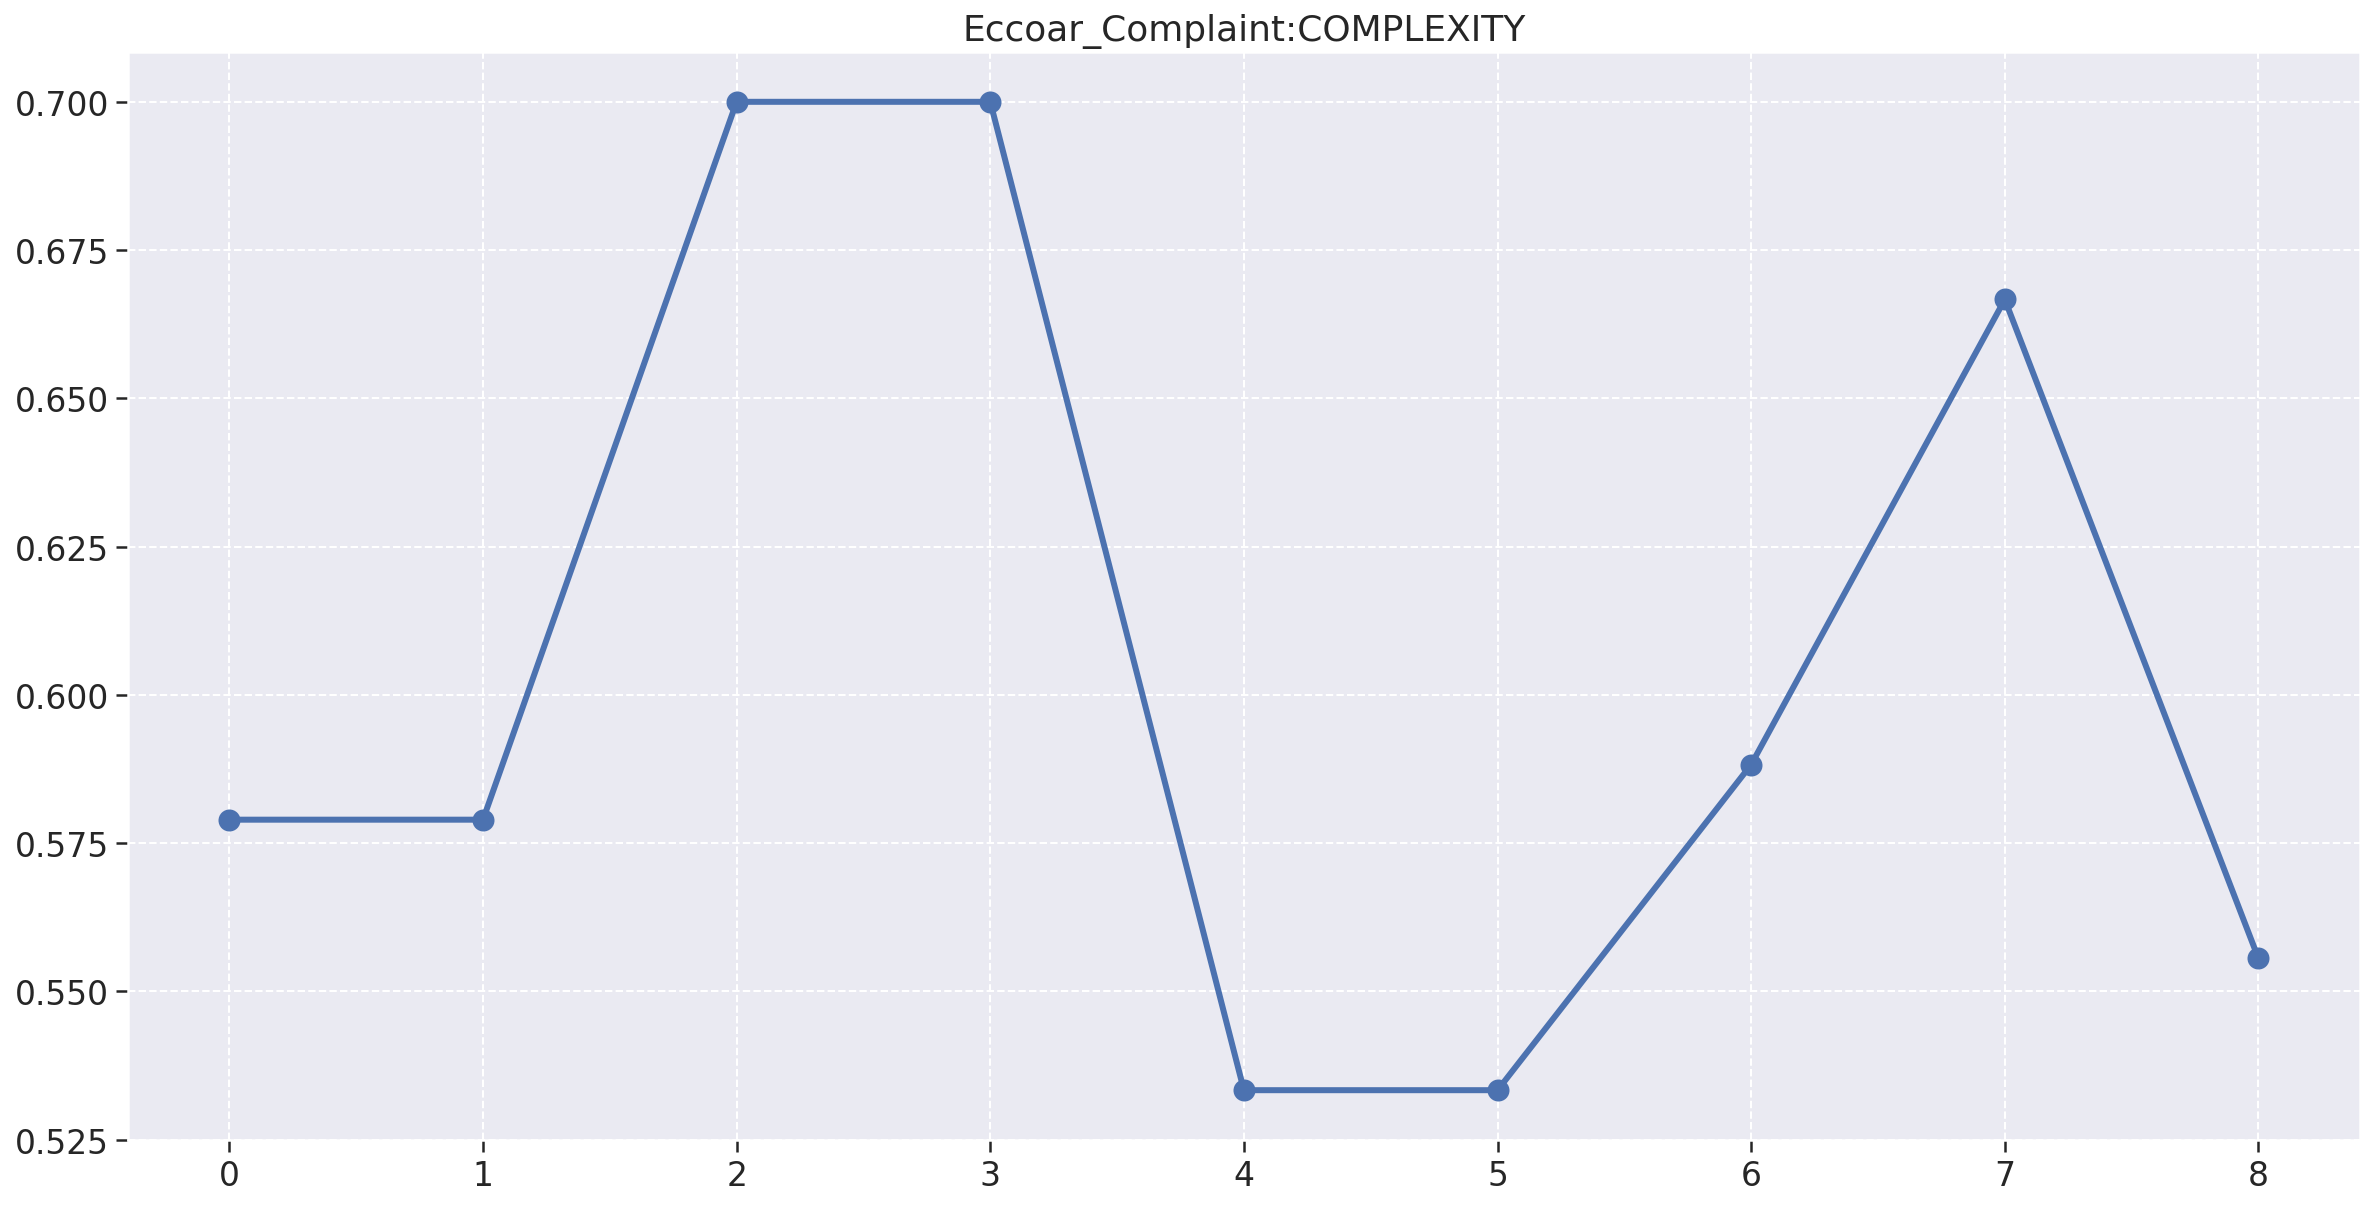

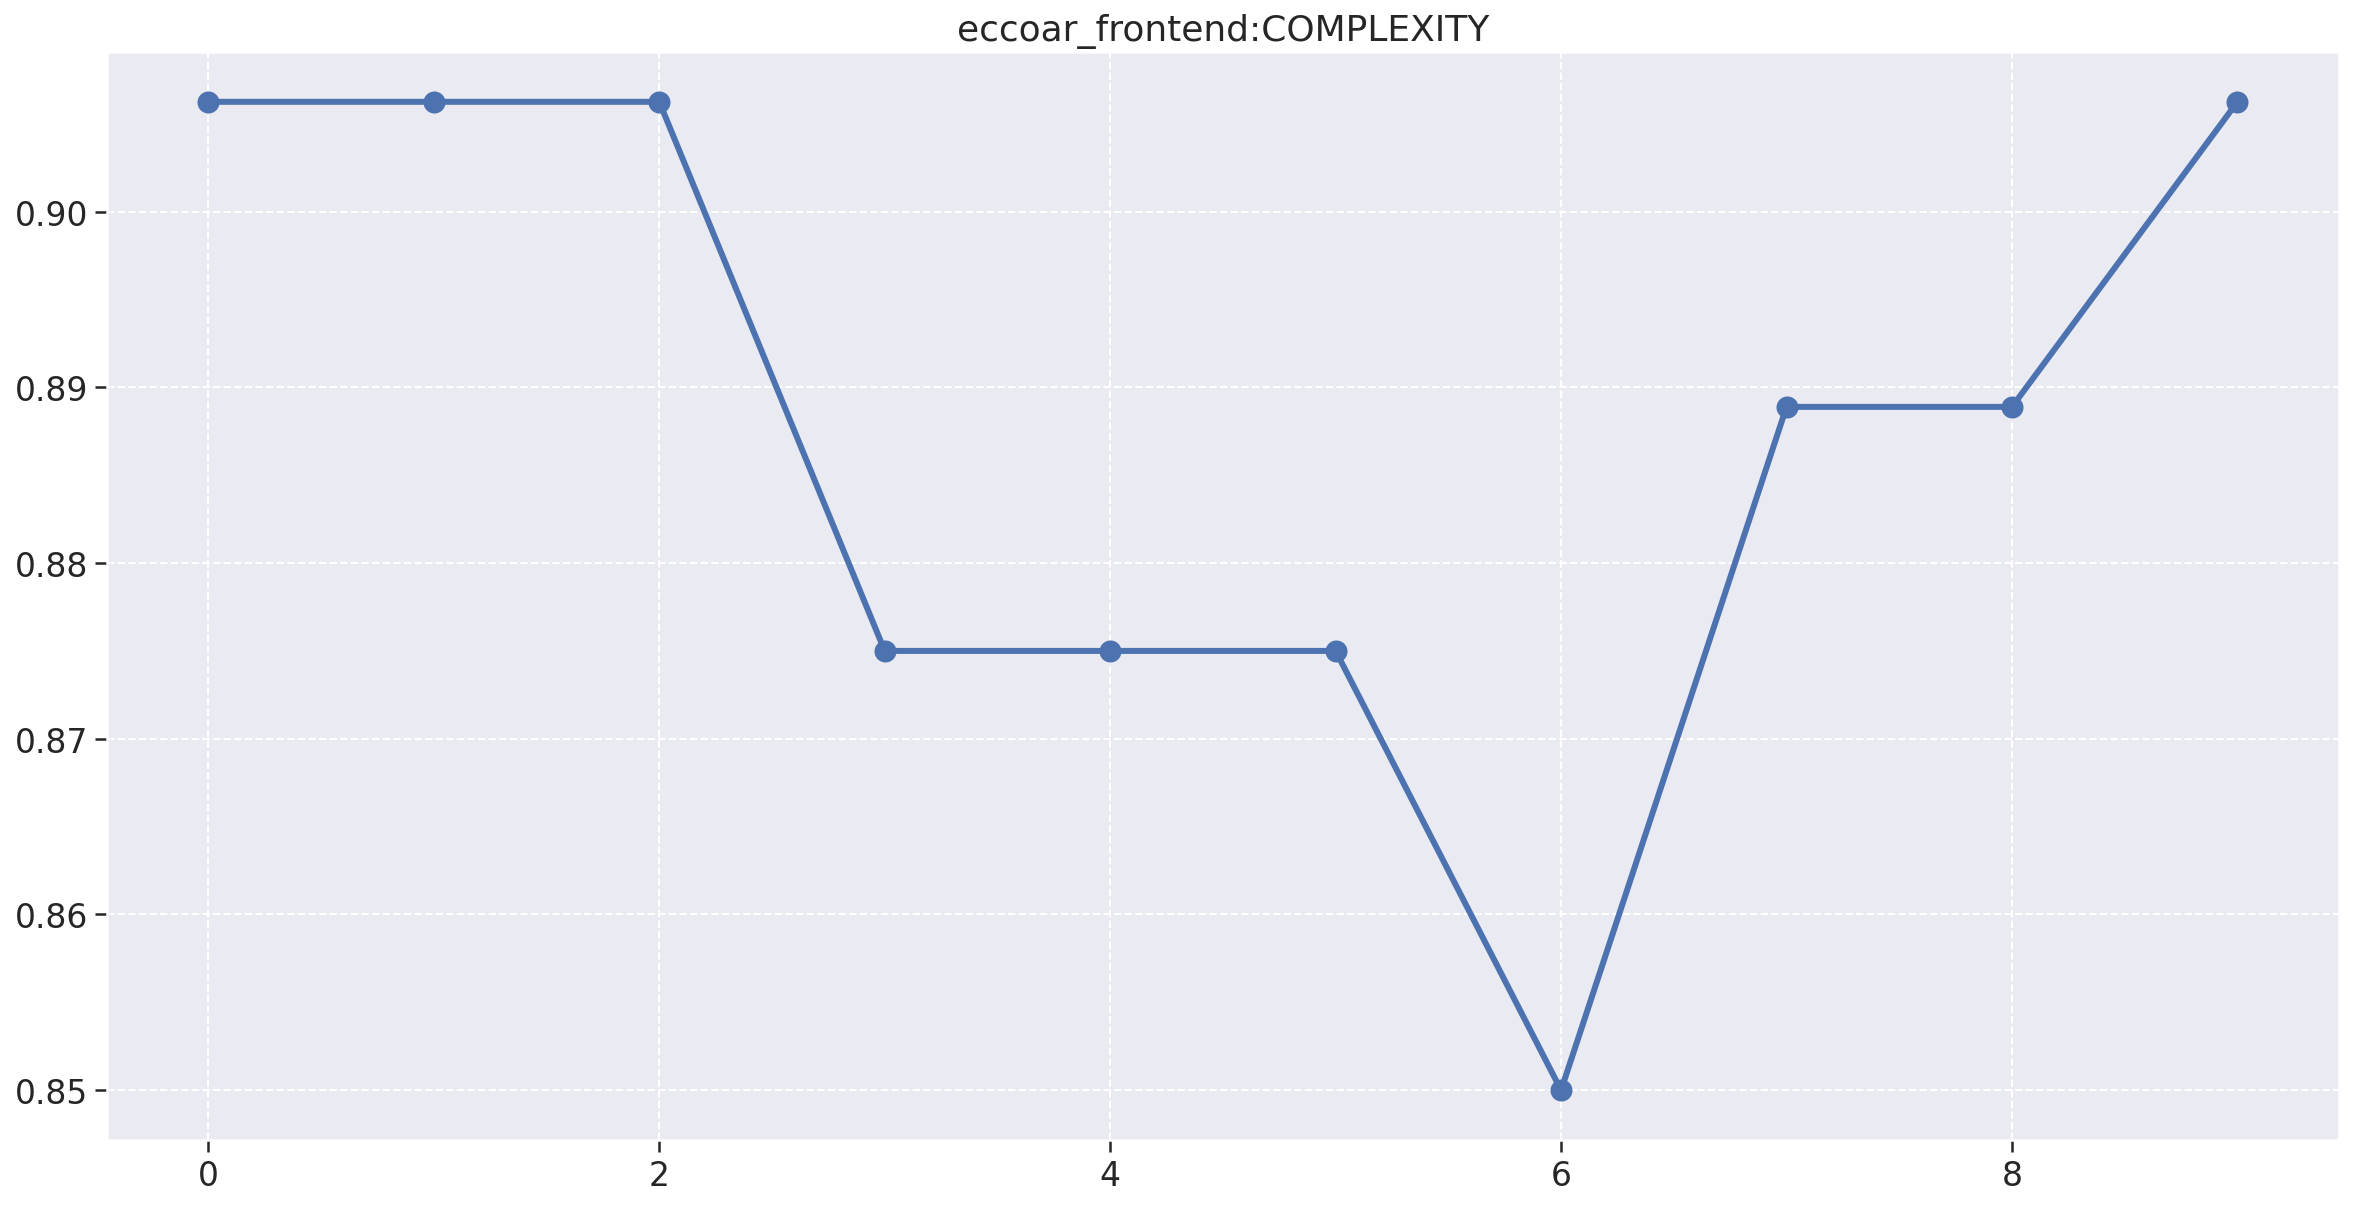

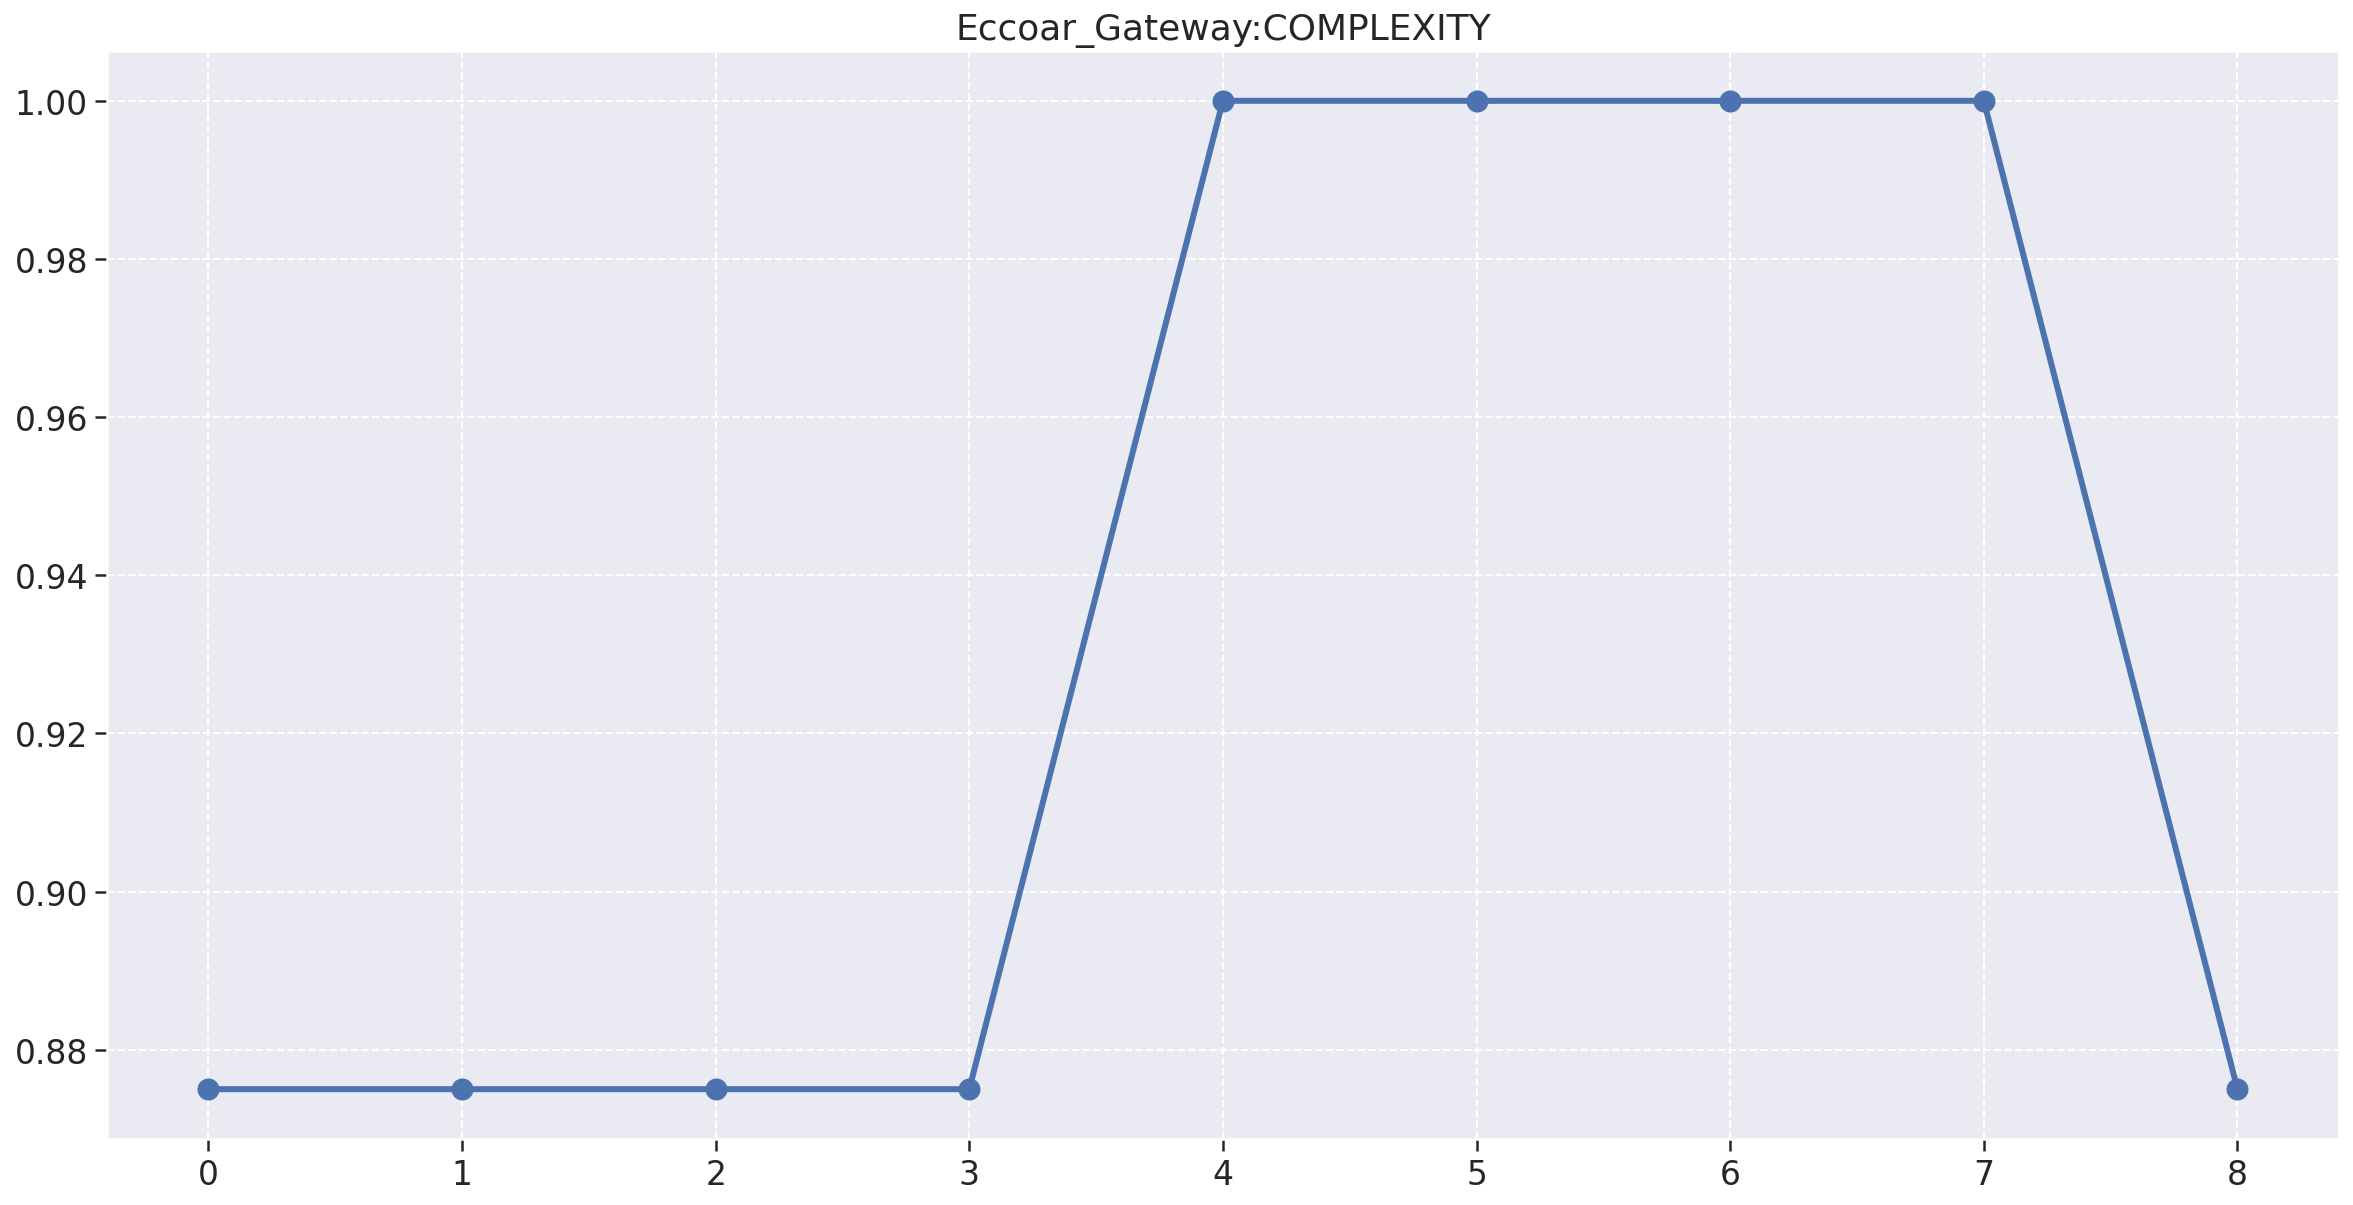

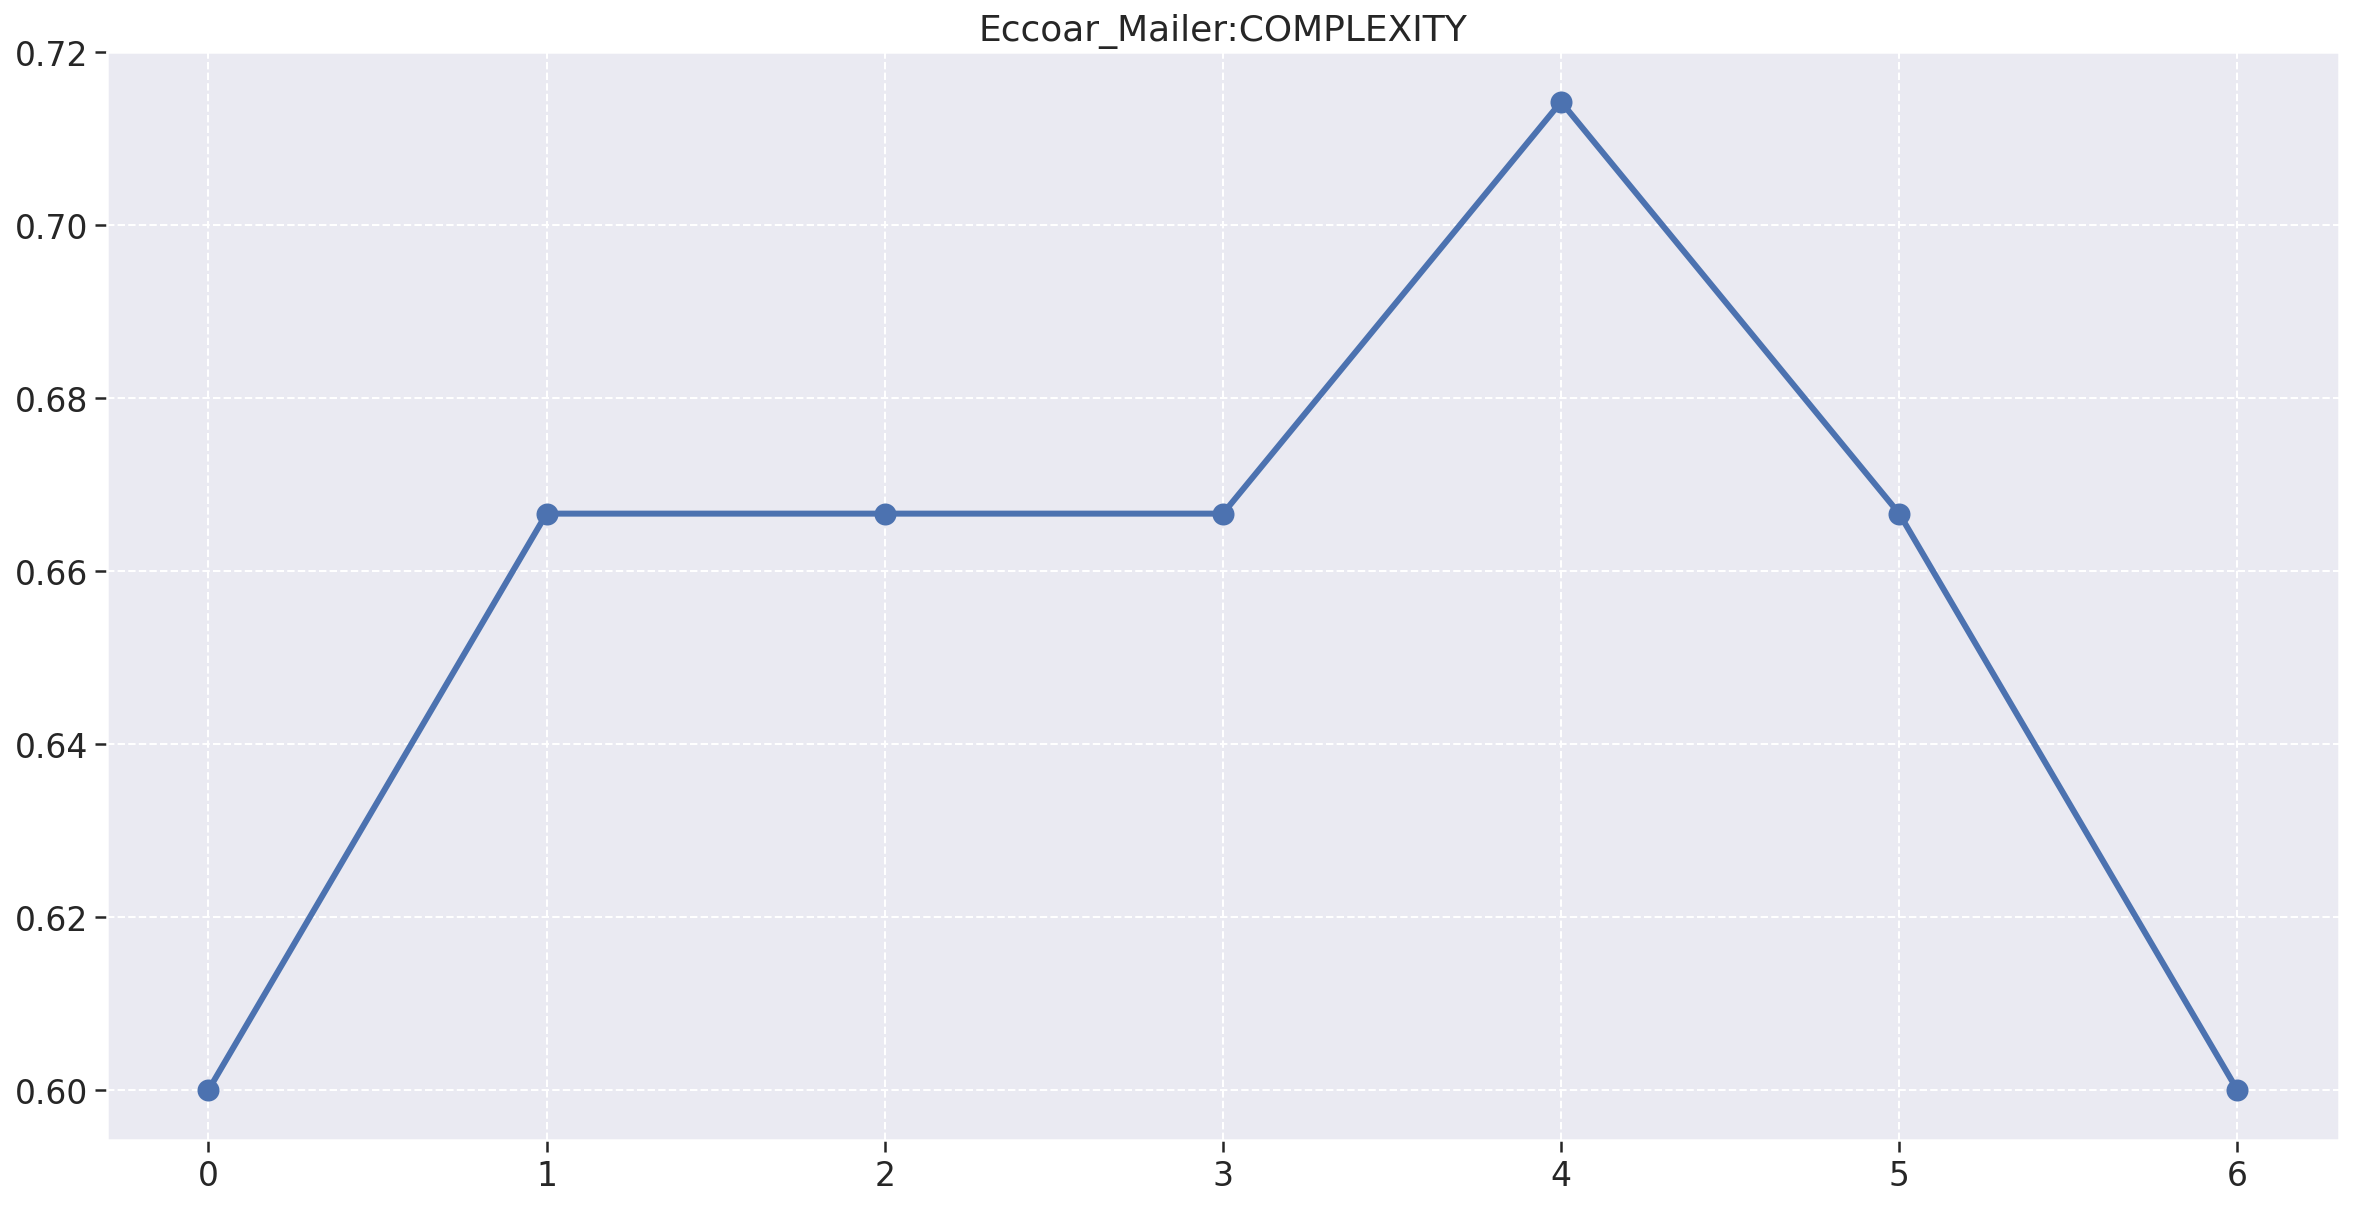

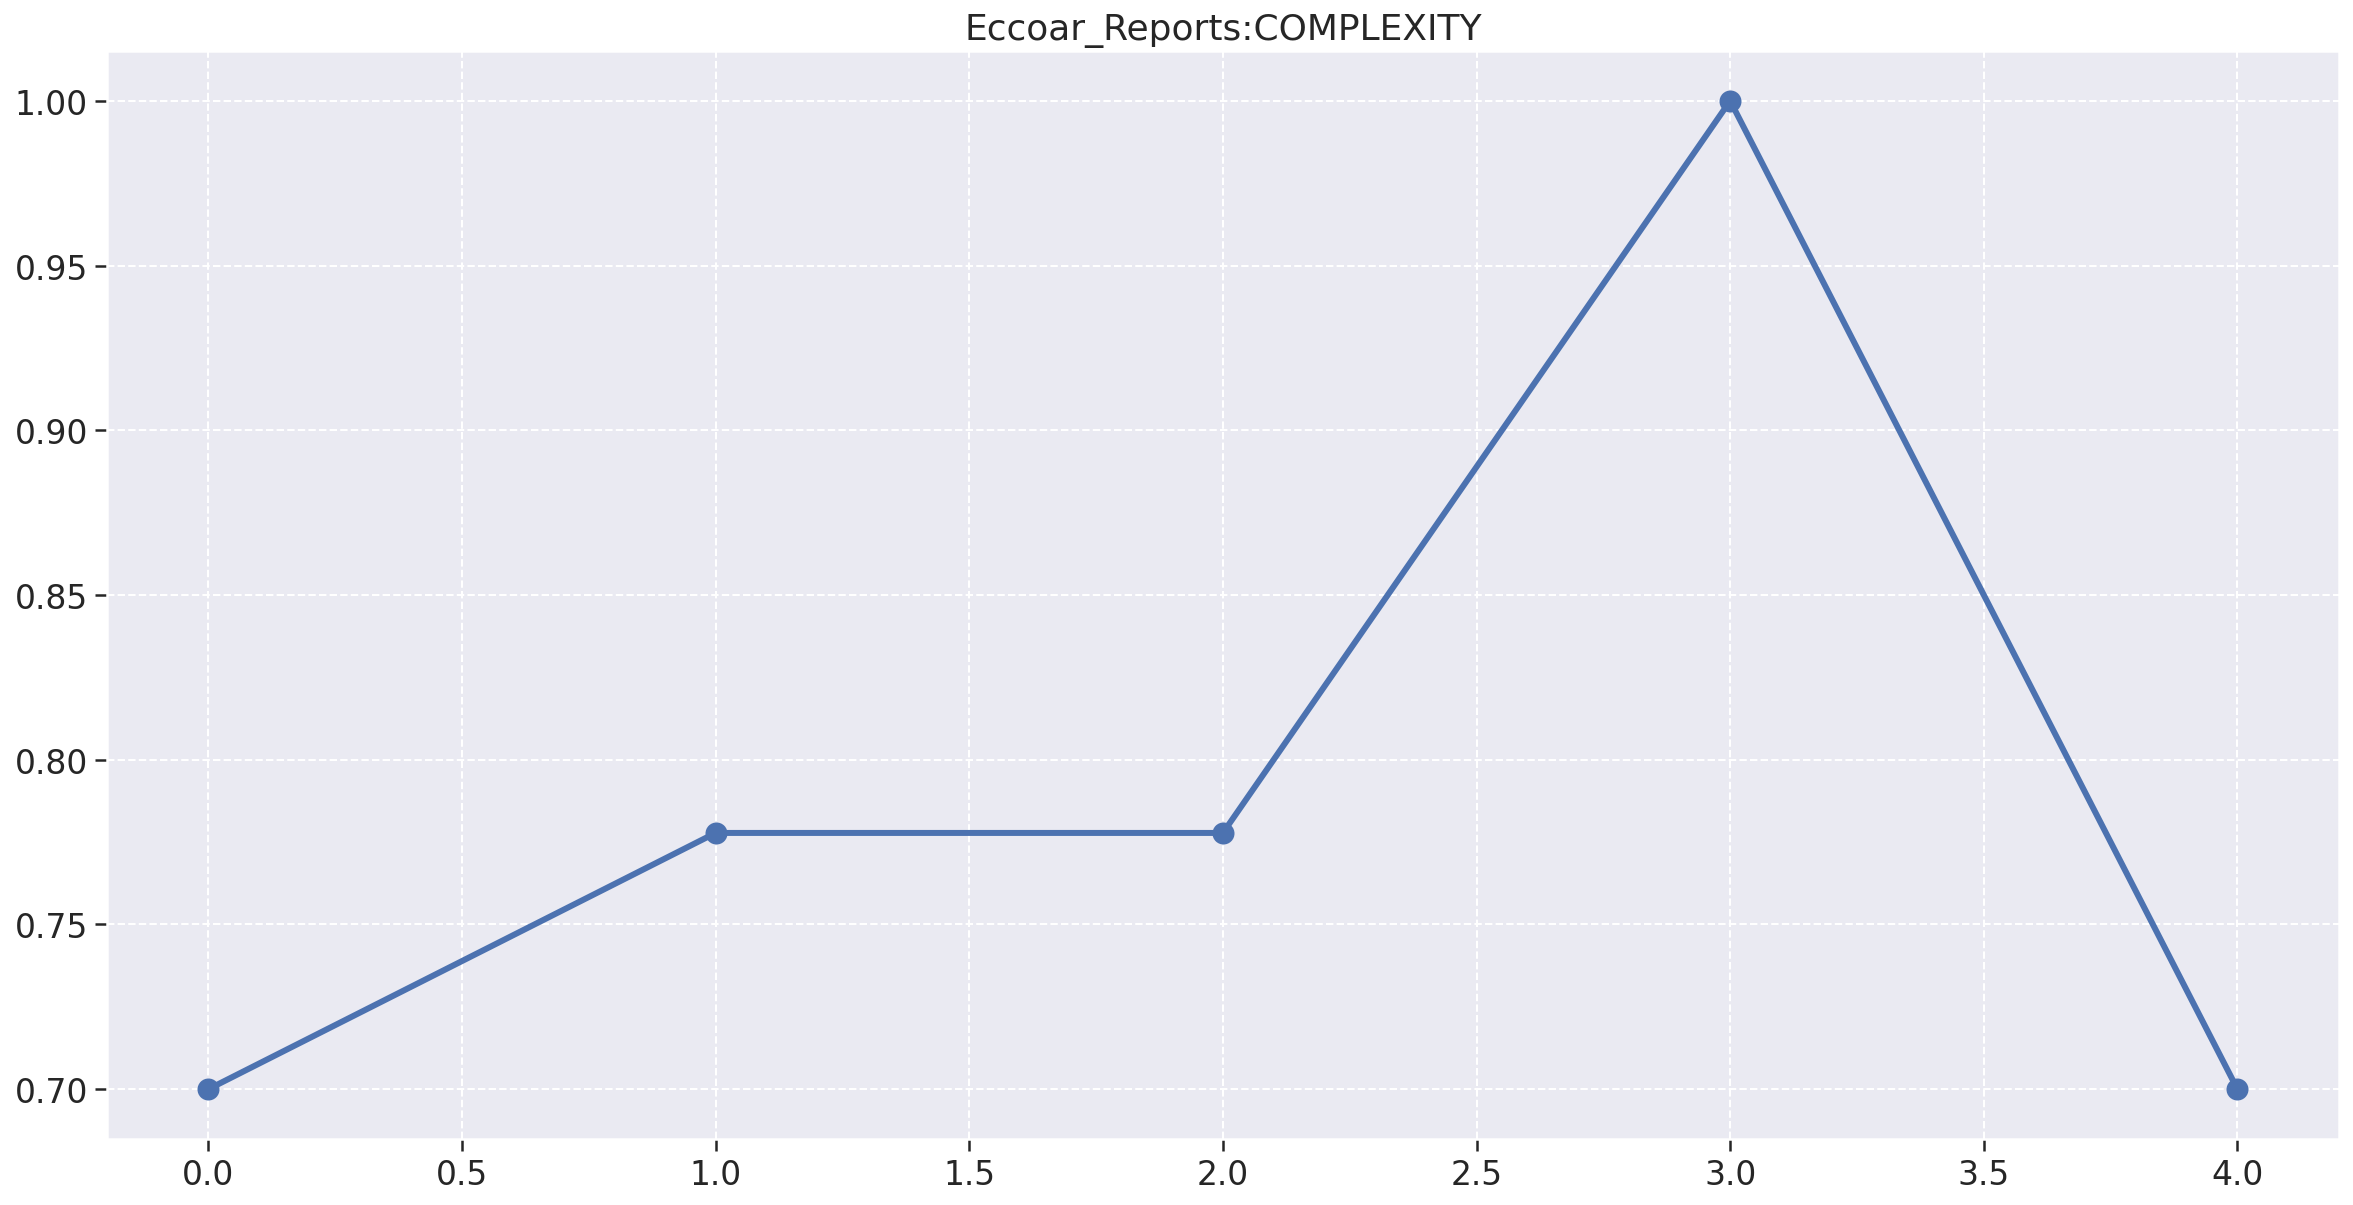

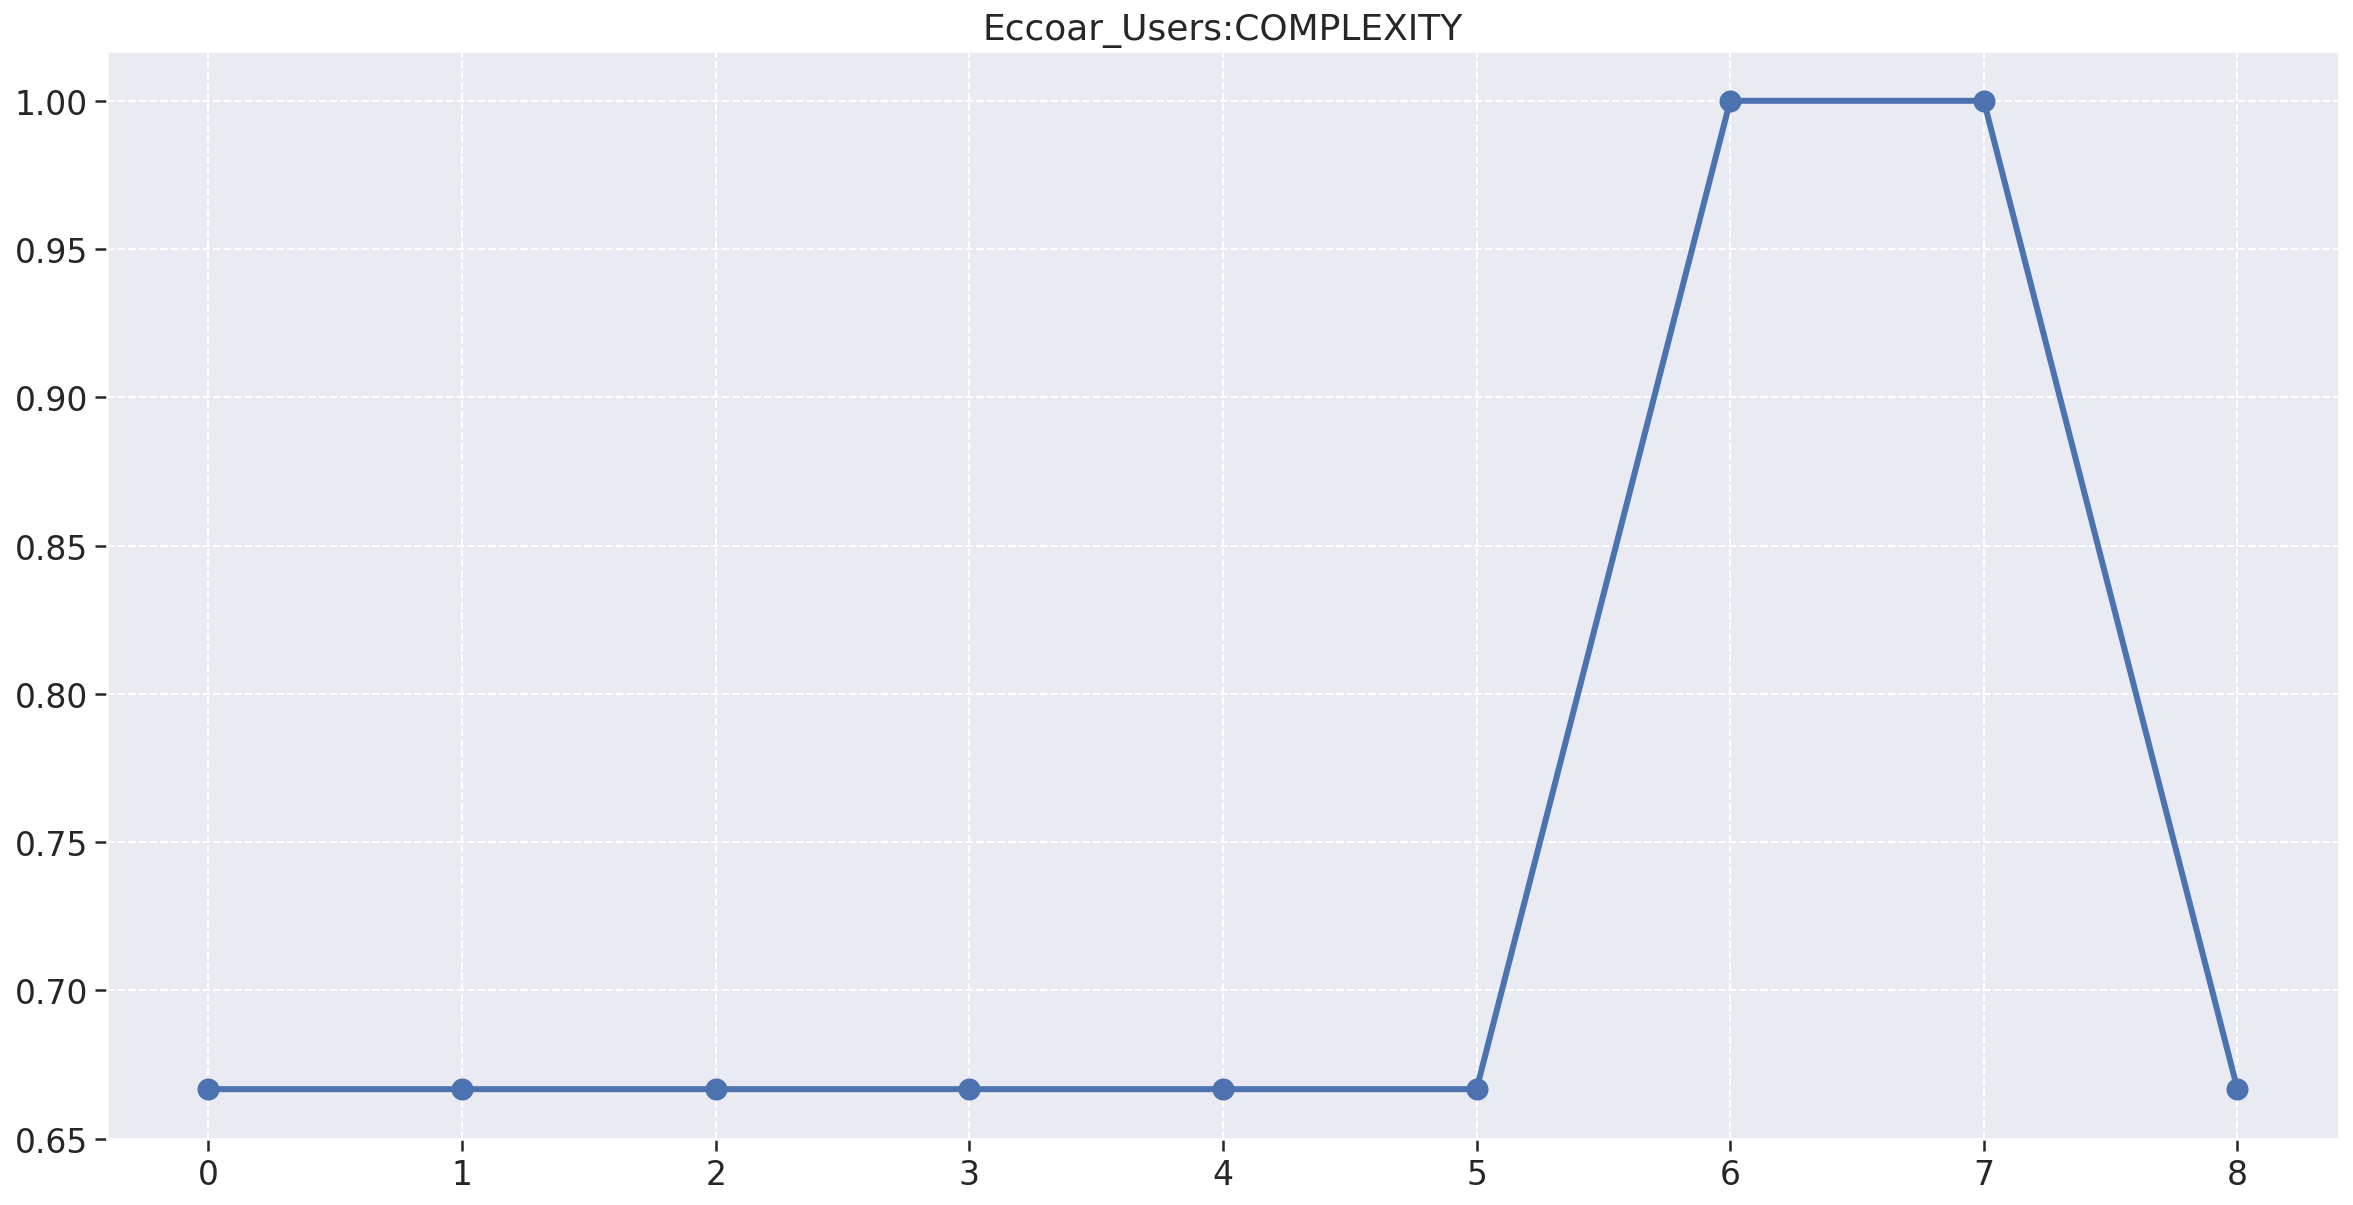

In [31]:

for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMPLEXITY")
    plt.plot(metrics_df['m1'], linewidth=3, marker='o', markersize=10)

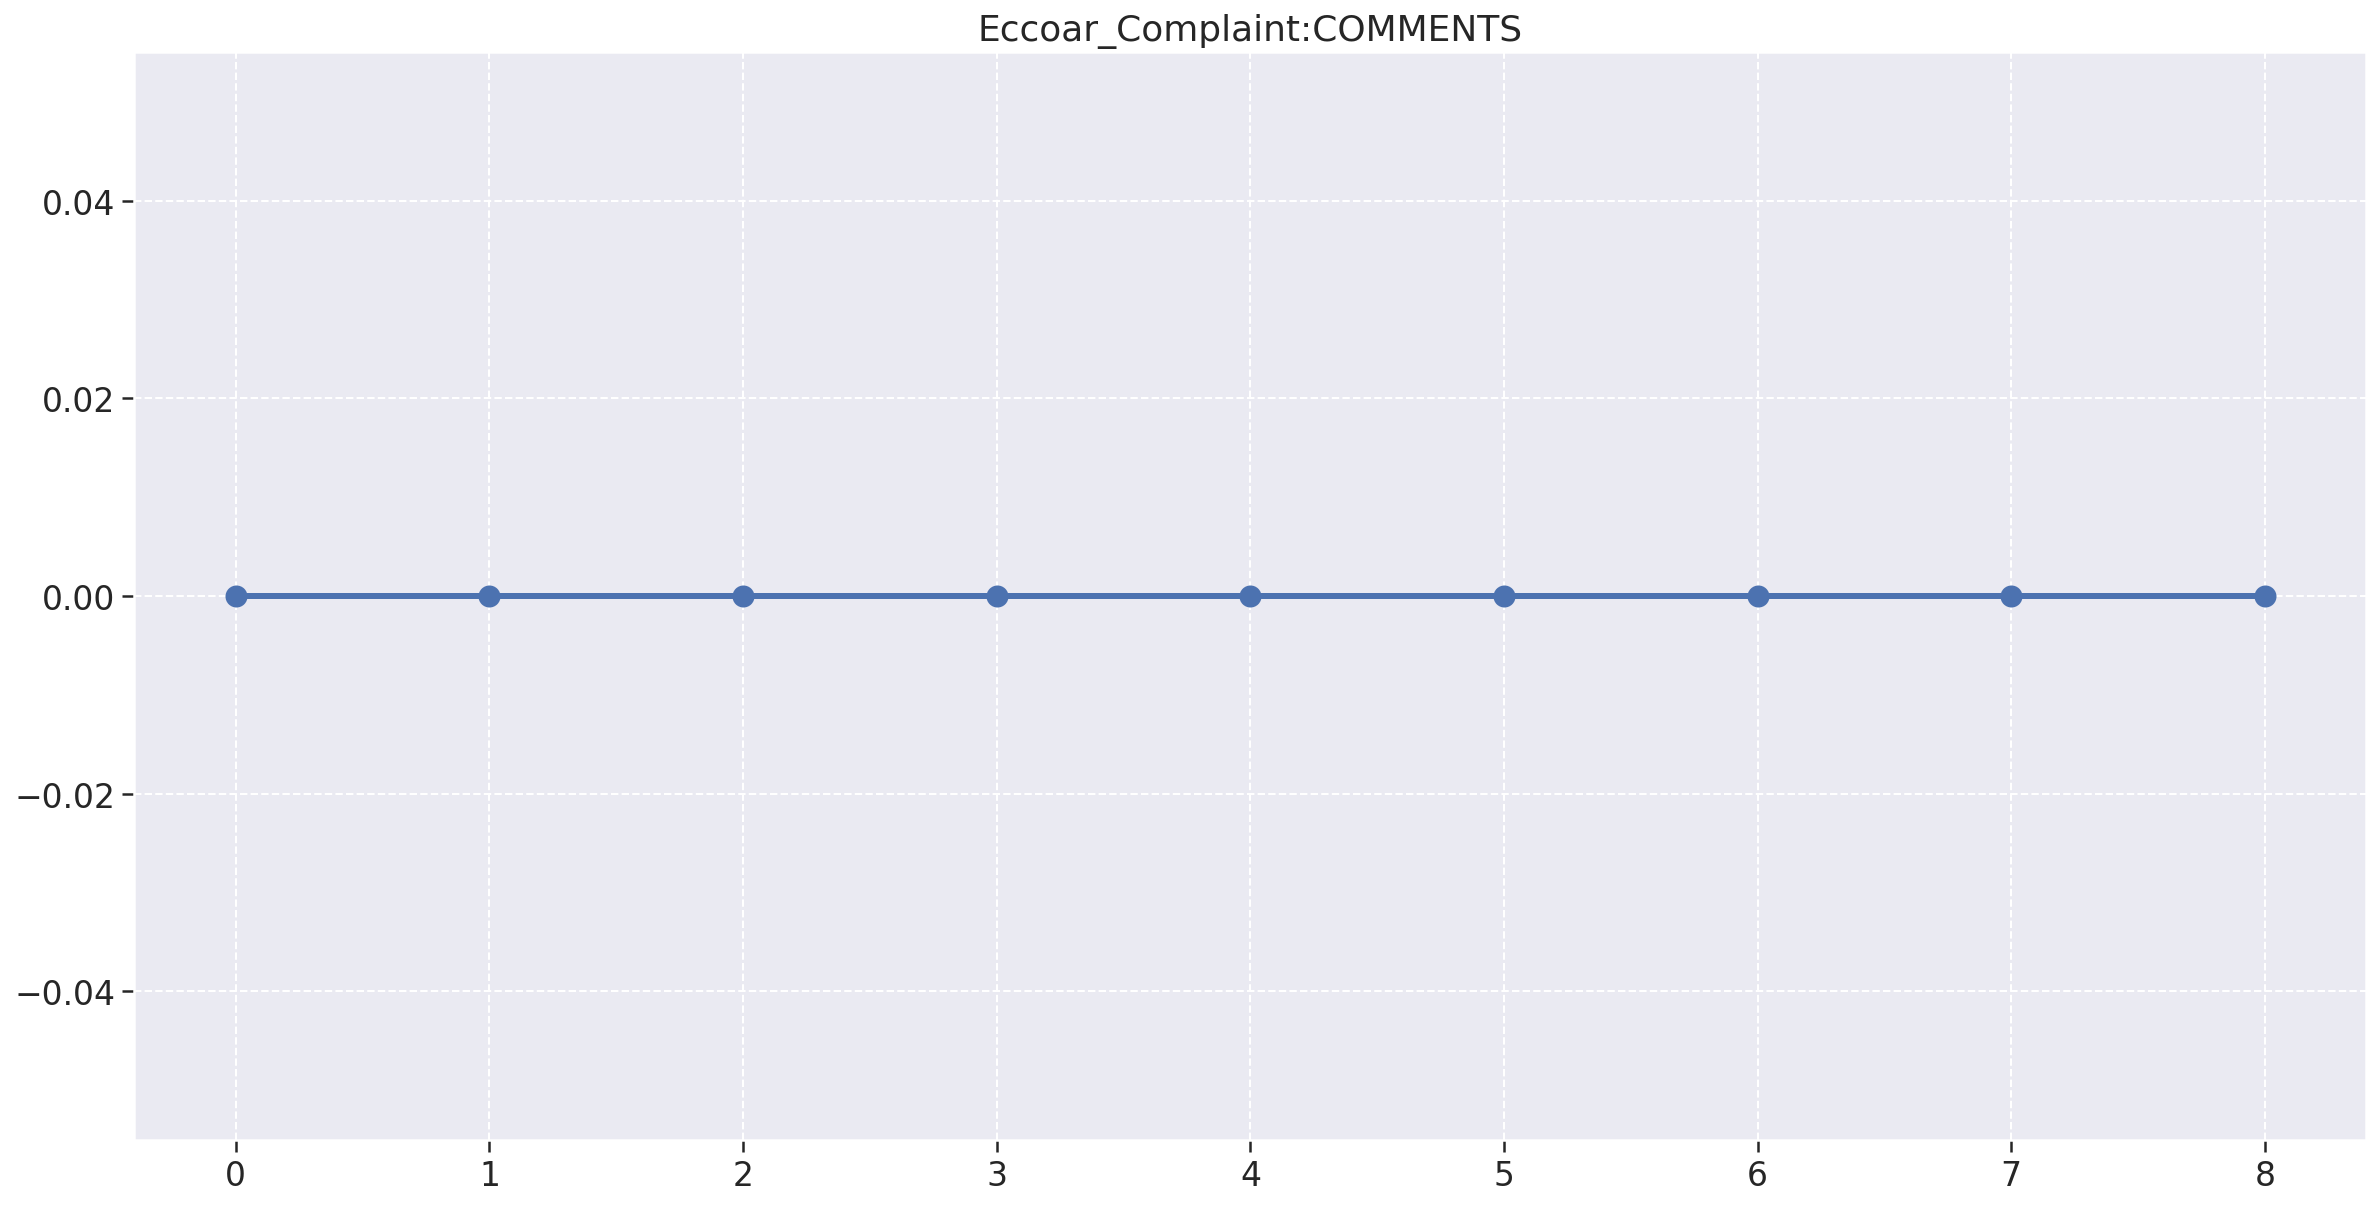

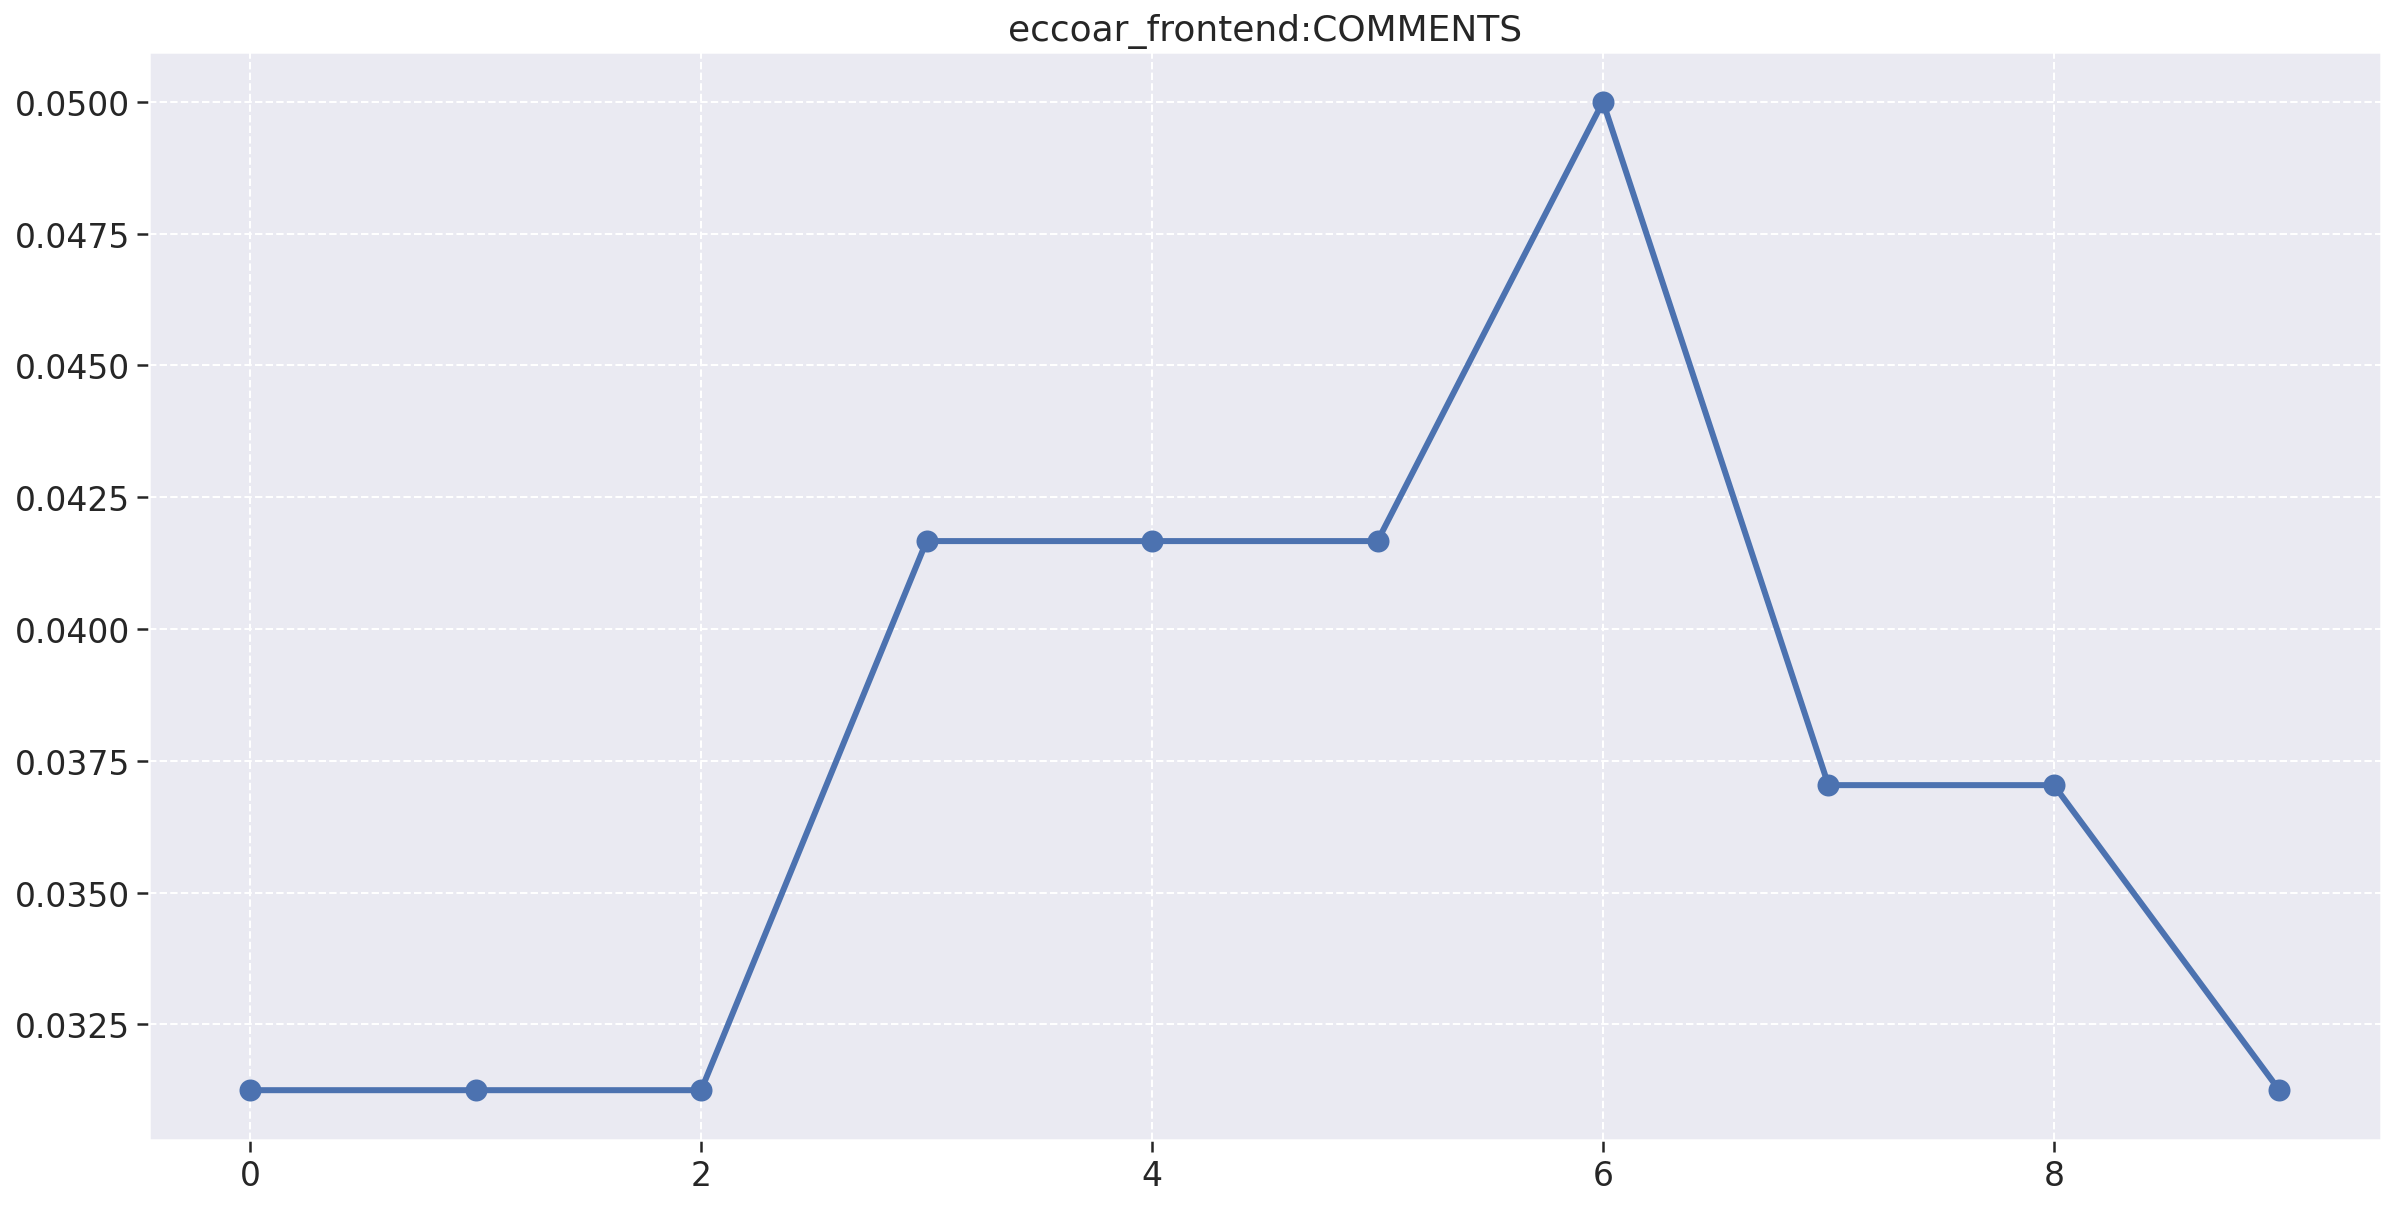

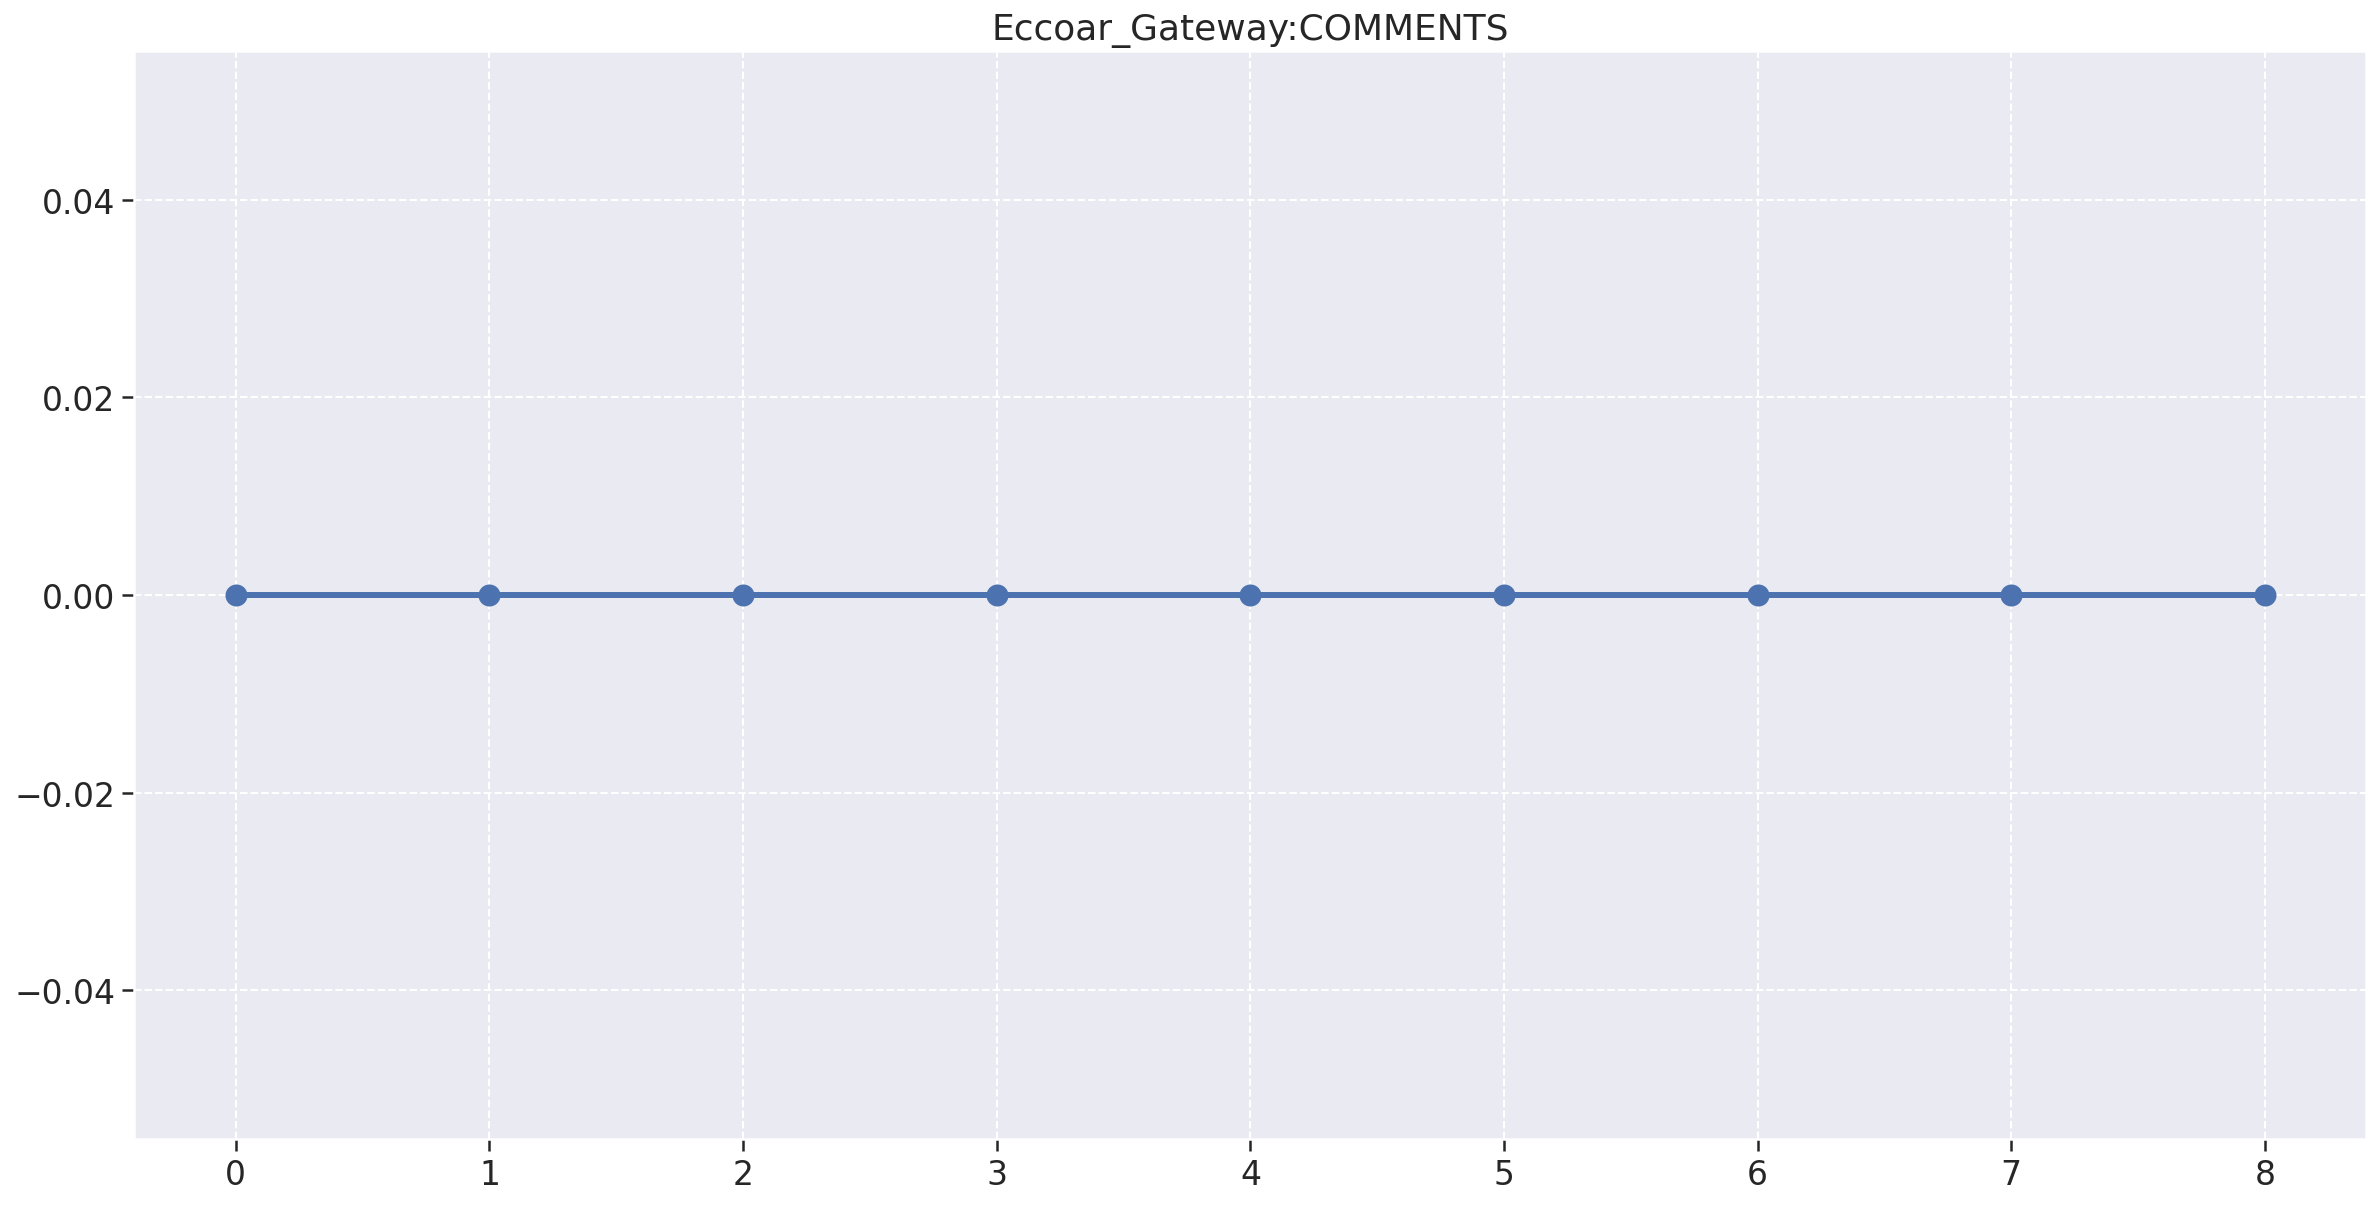

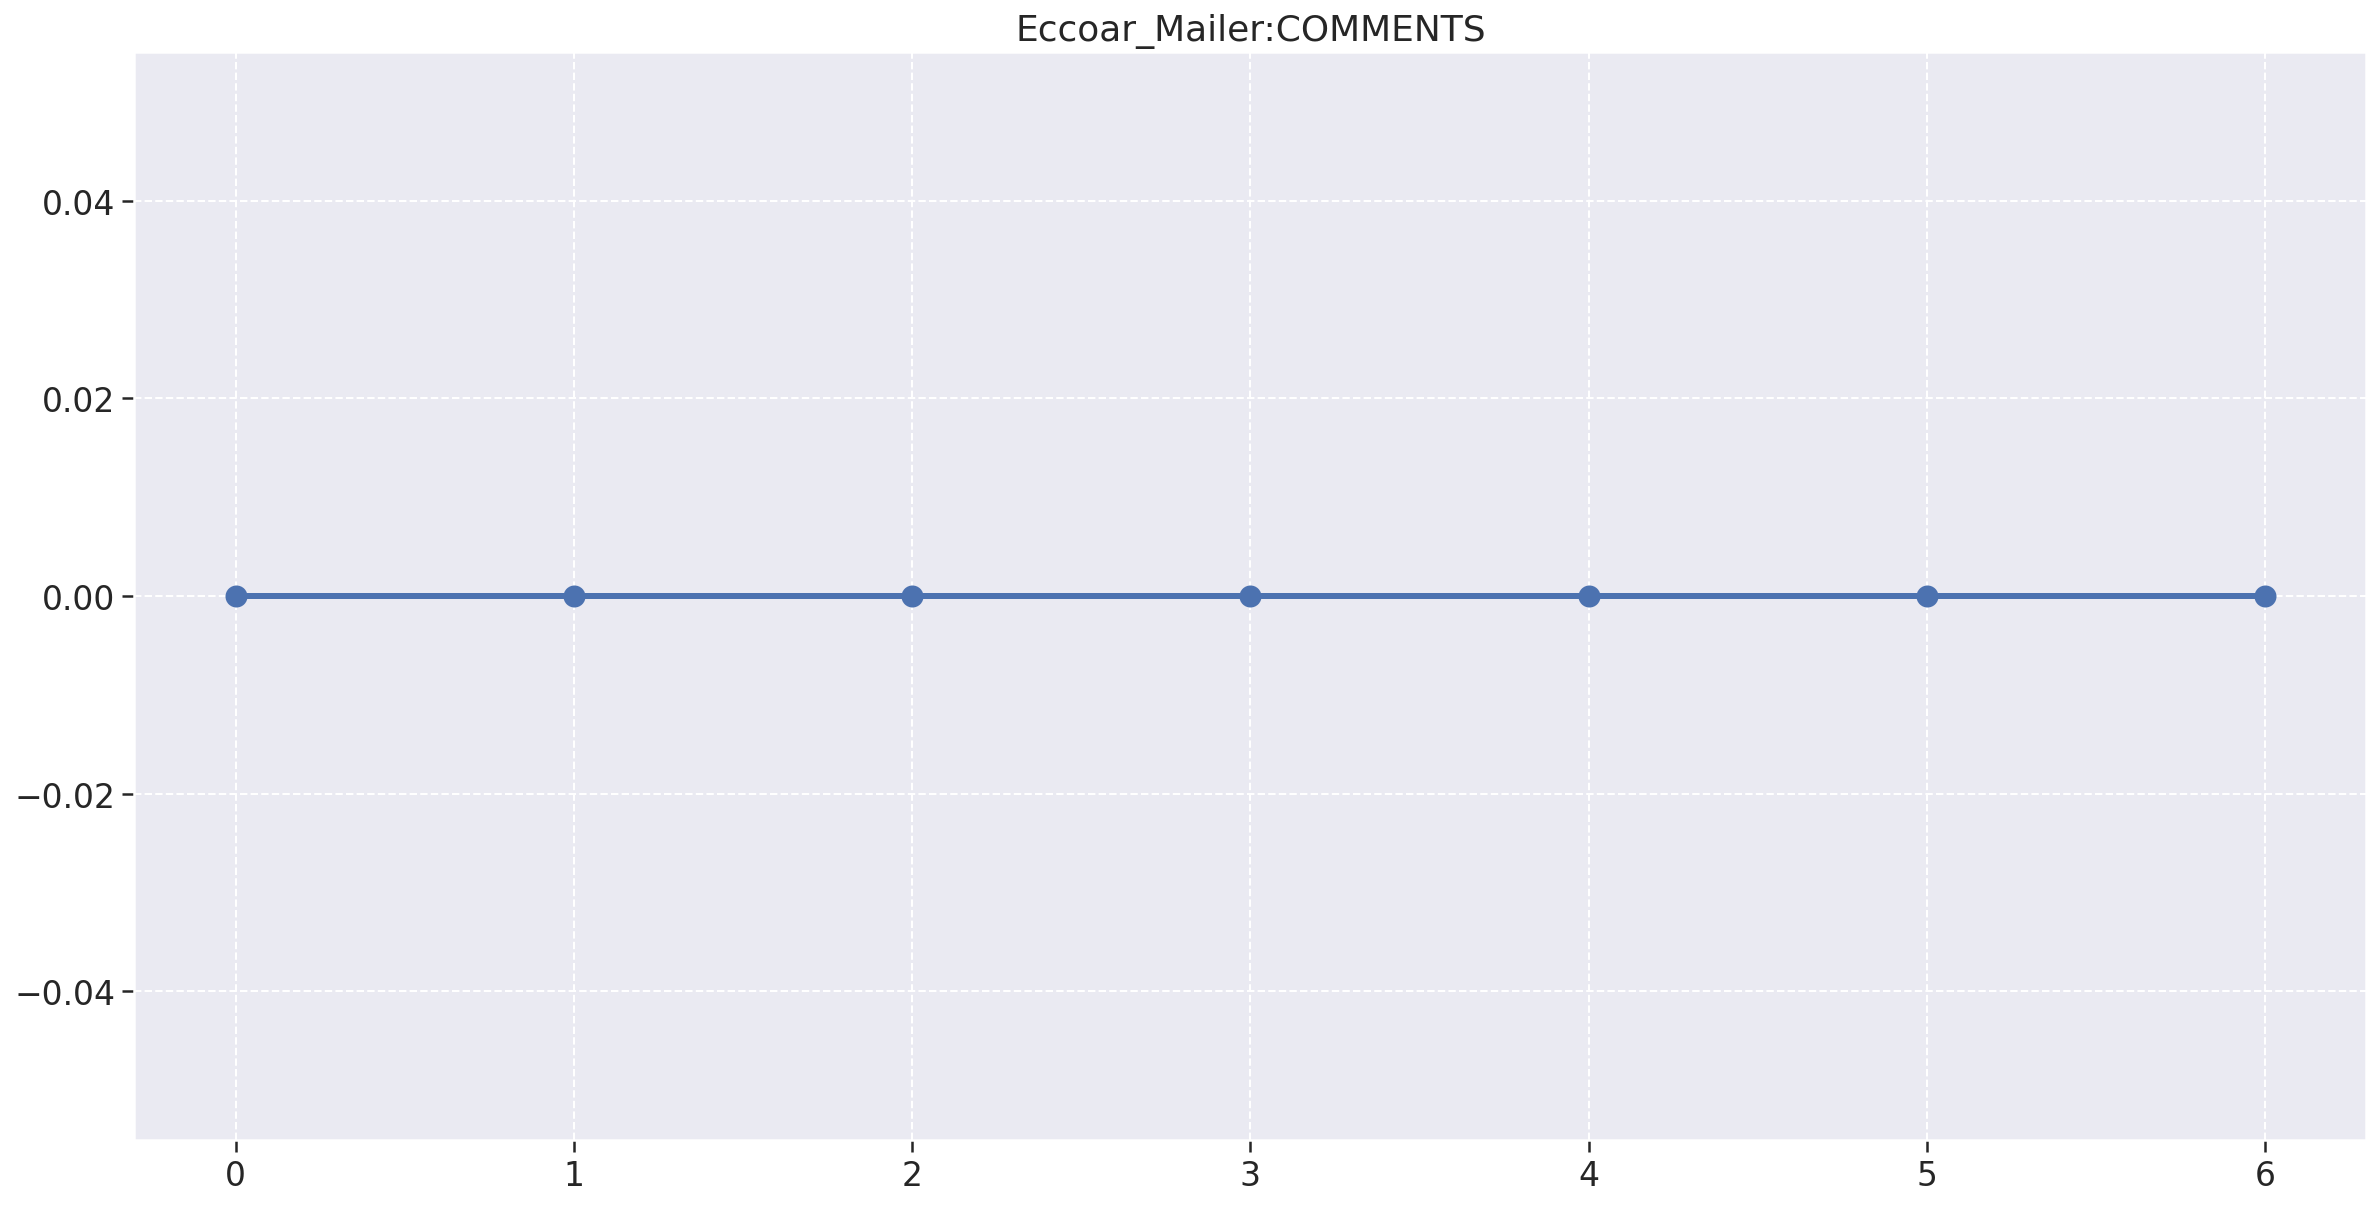

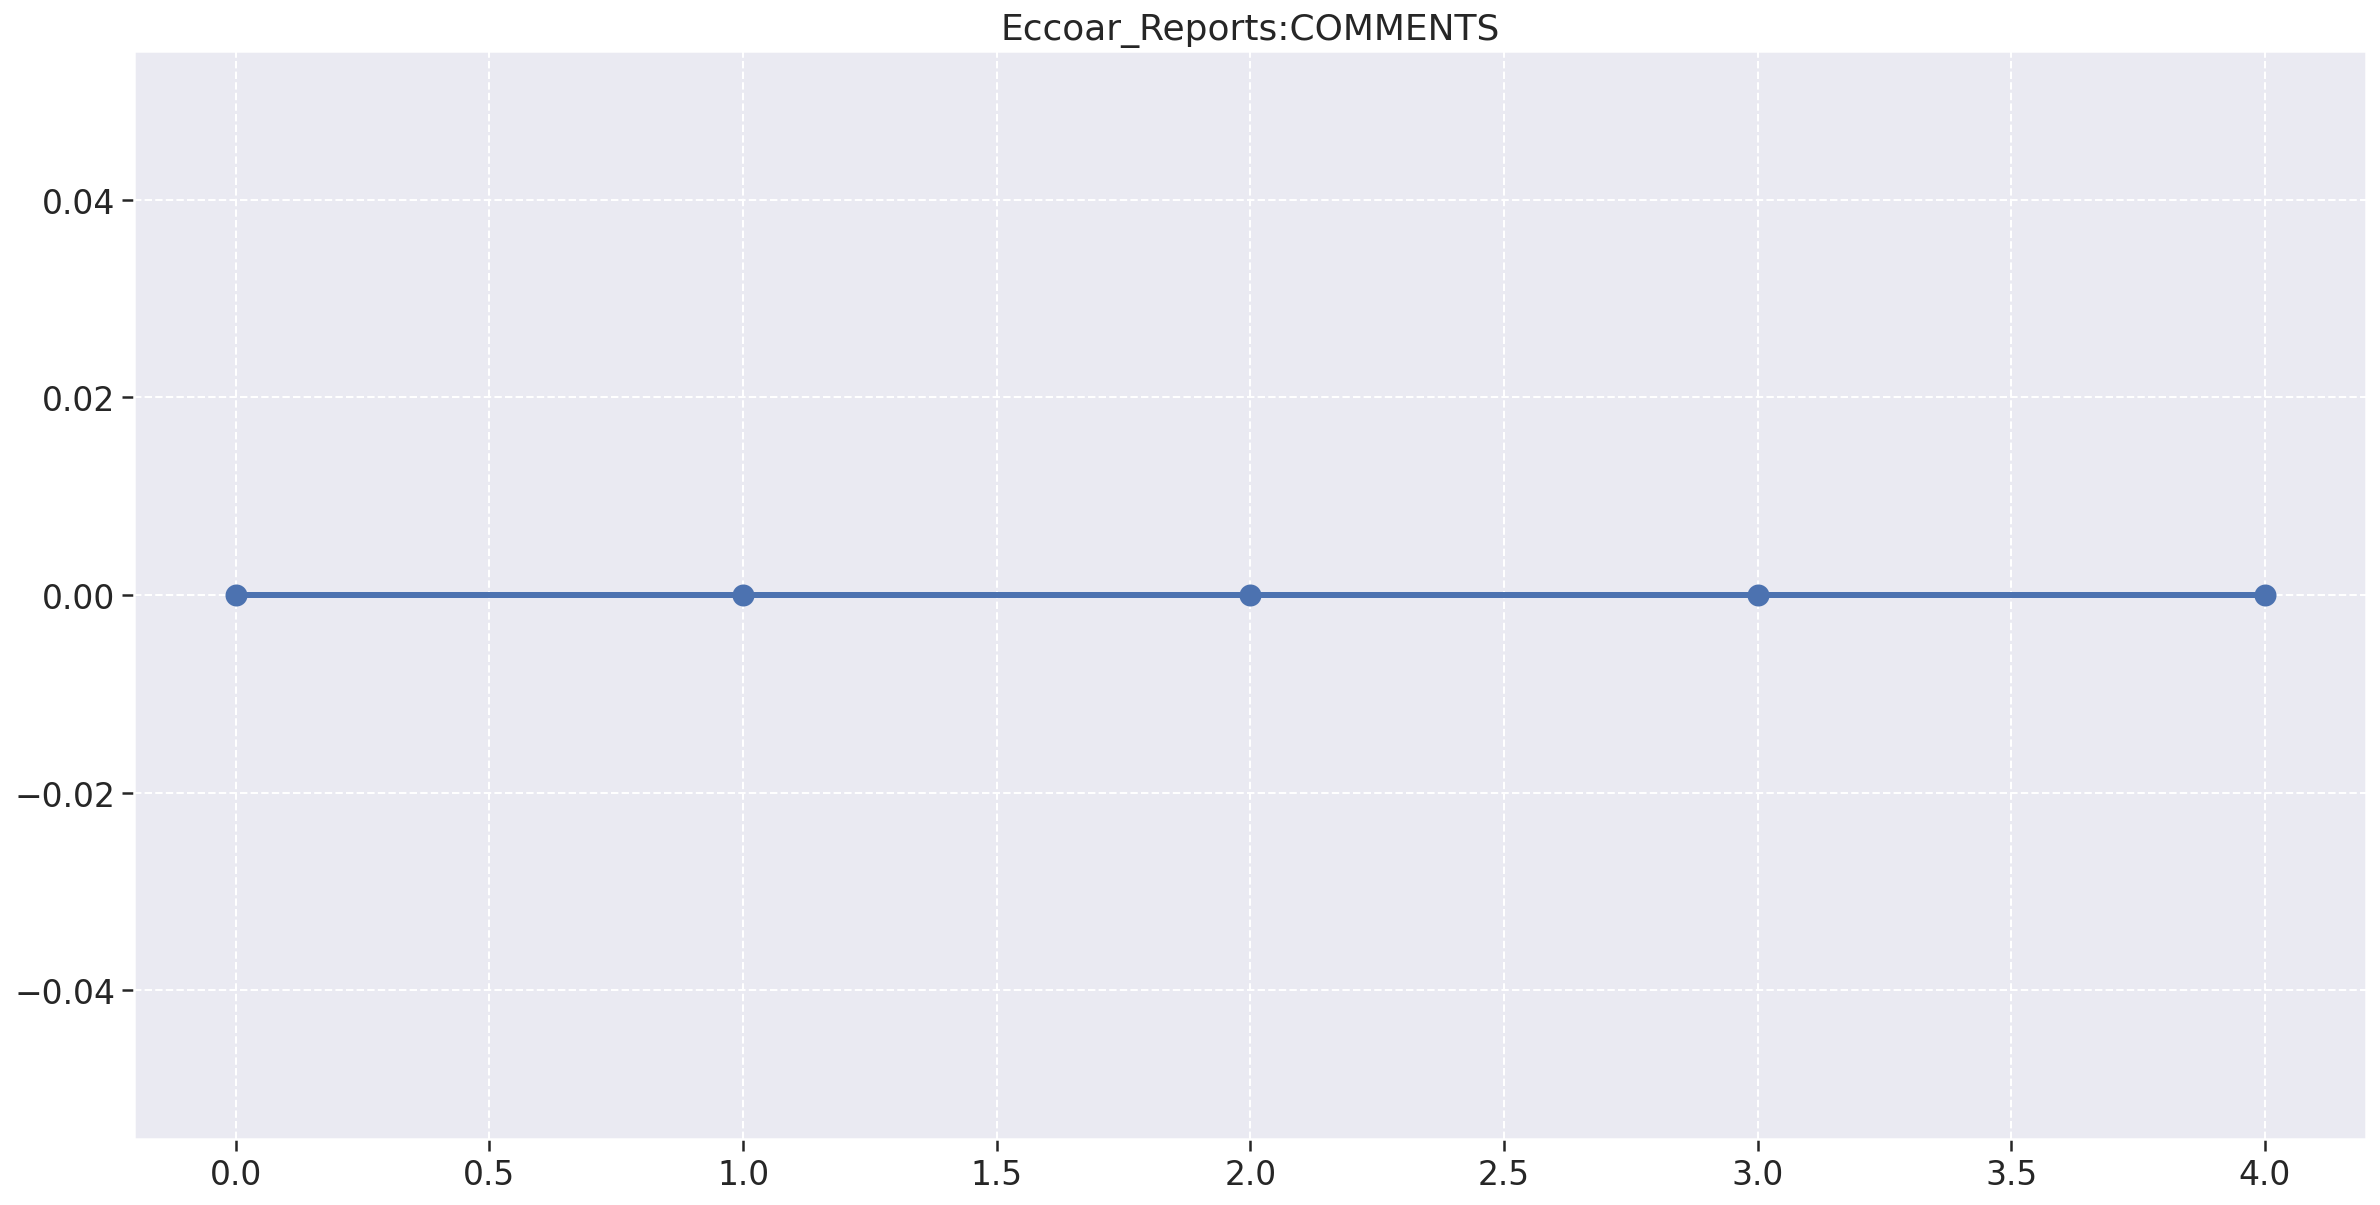

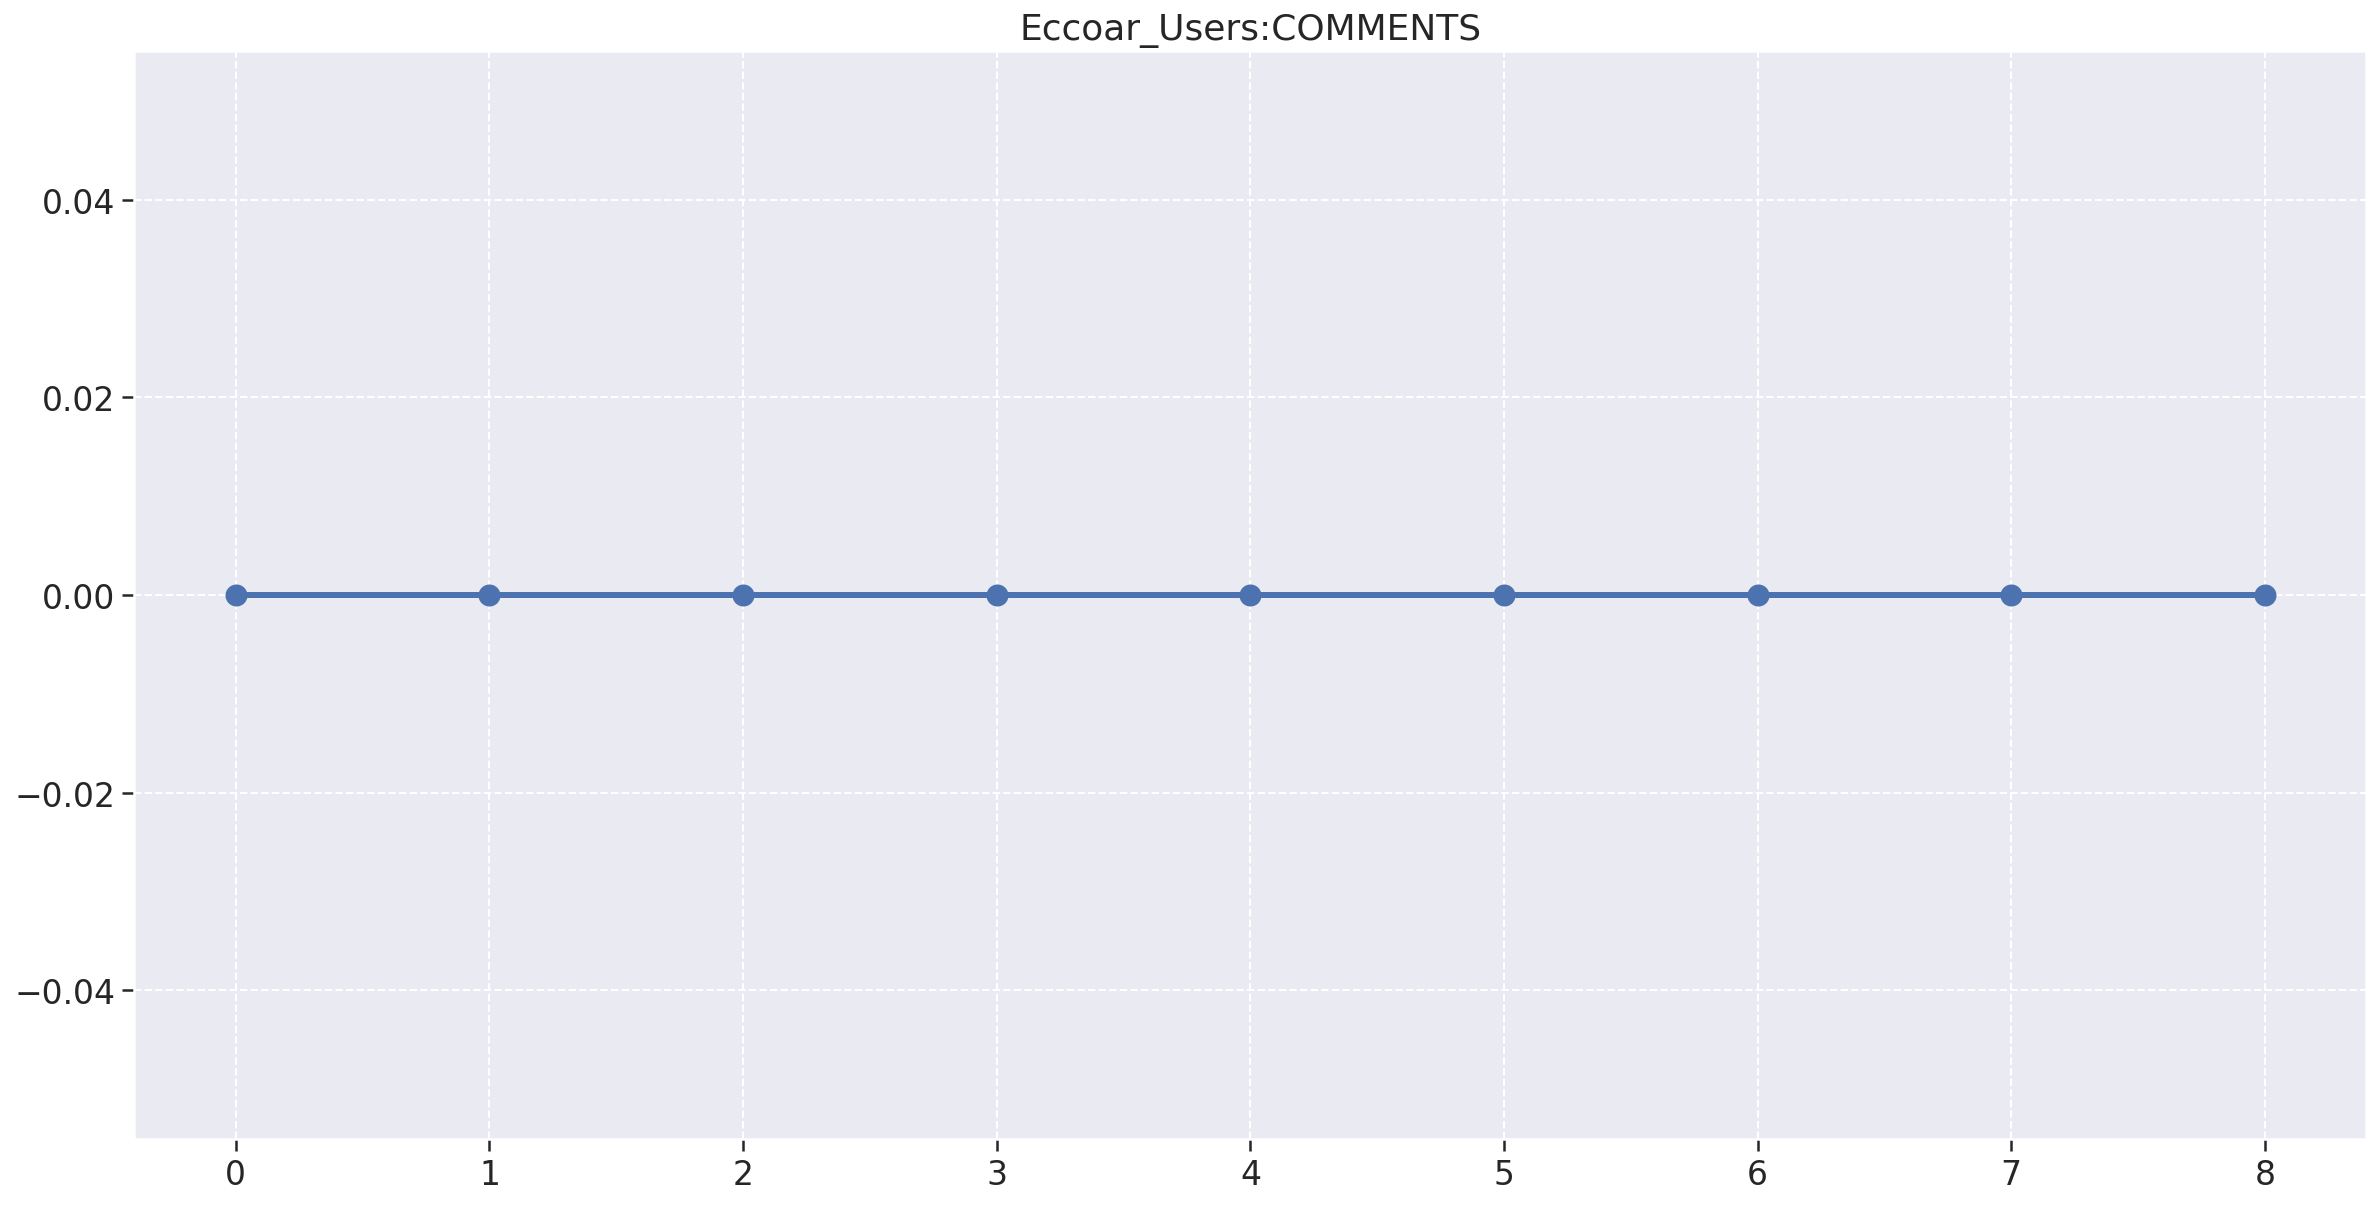

In [32]:

for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMMENTS")
    plt.plot(metrics_df['m2'], linewidth=3, marker='o', markersize=10)

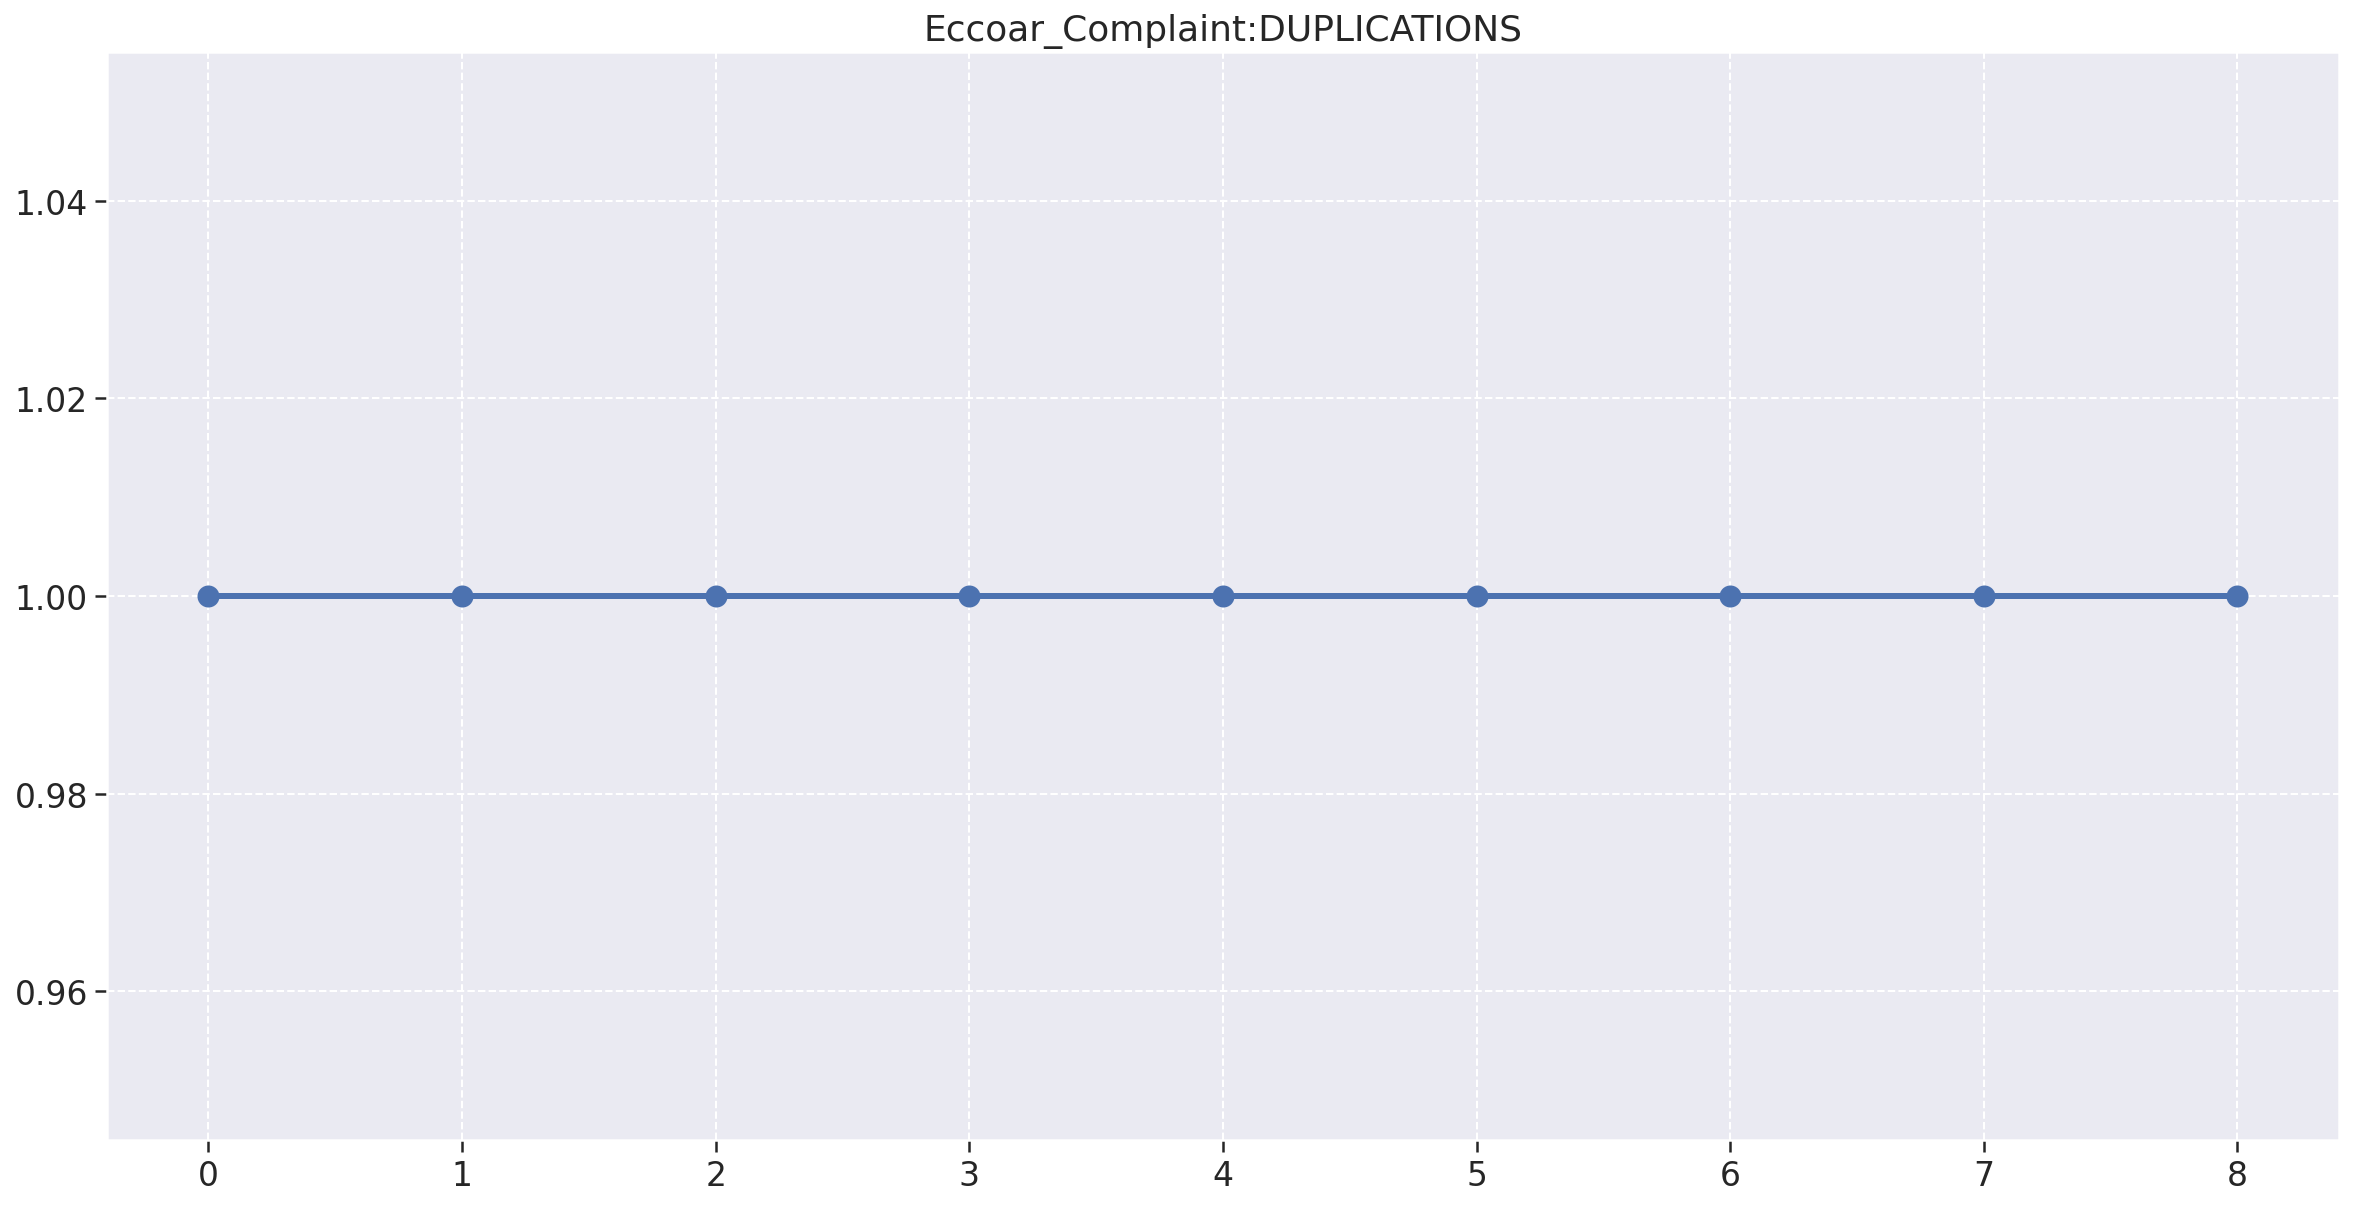

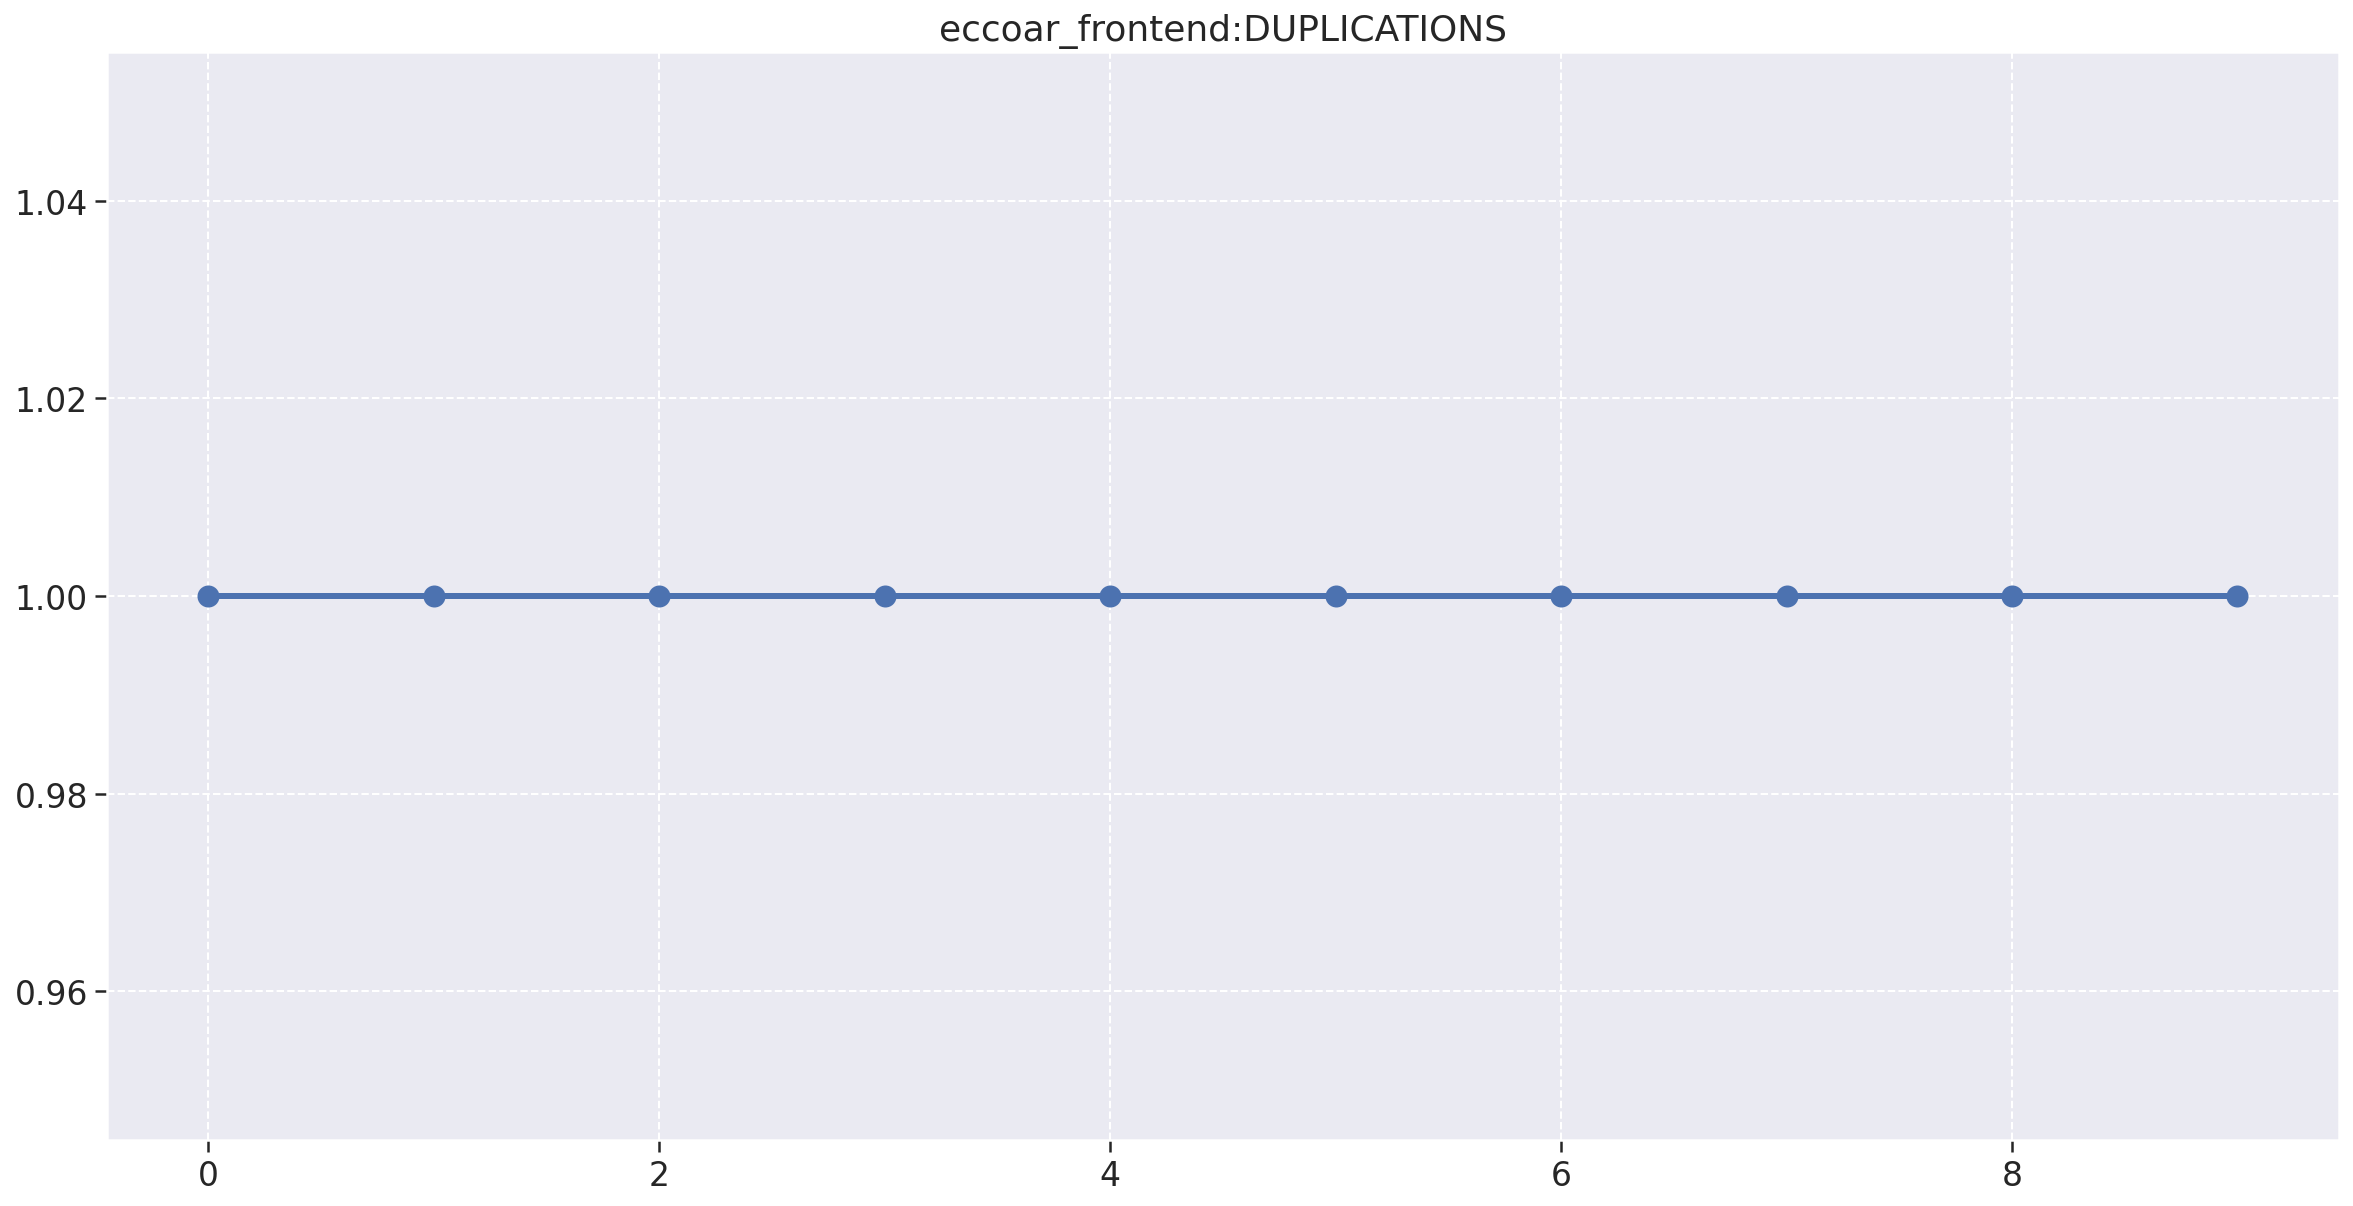

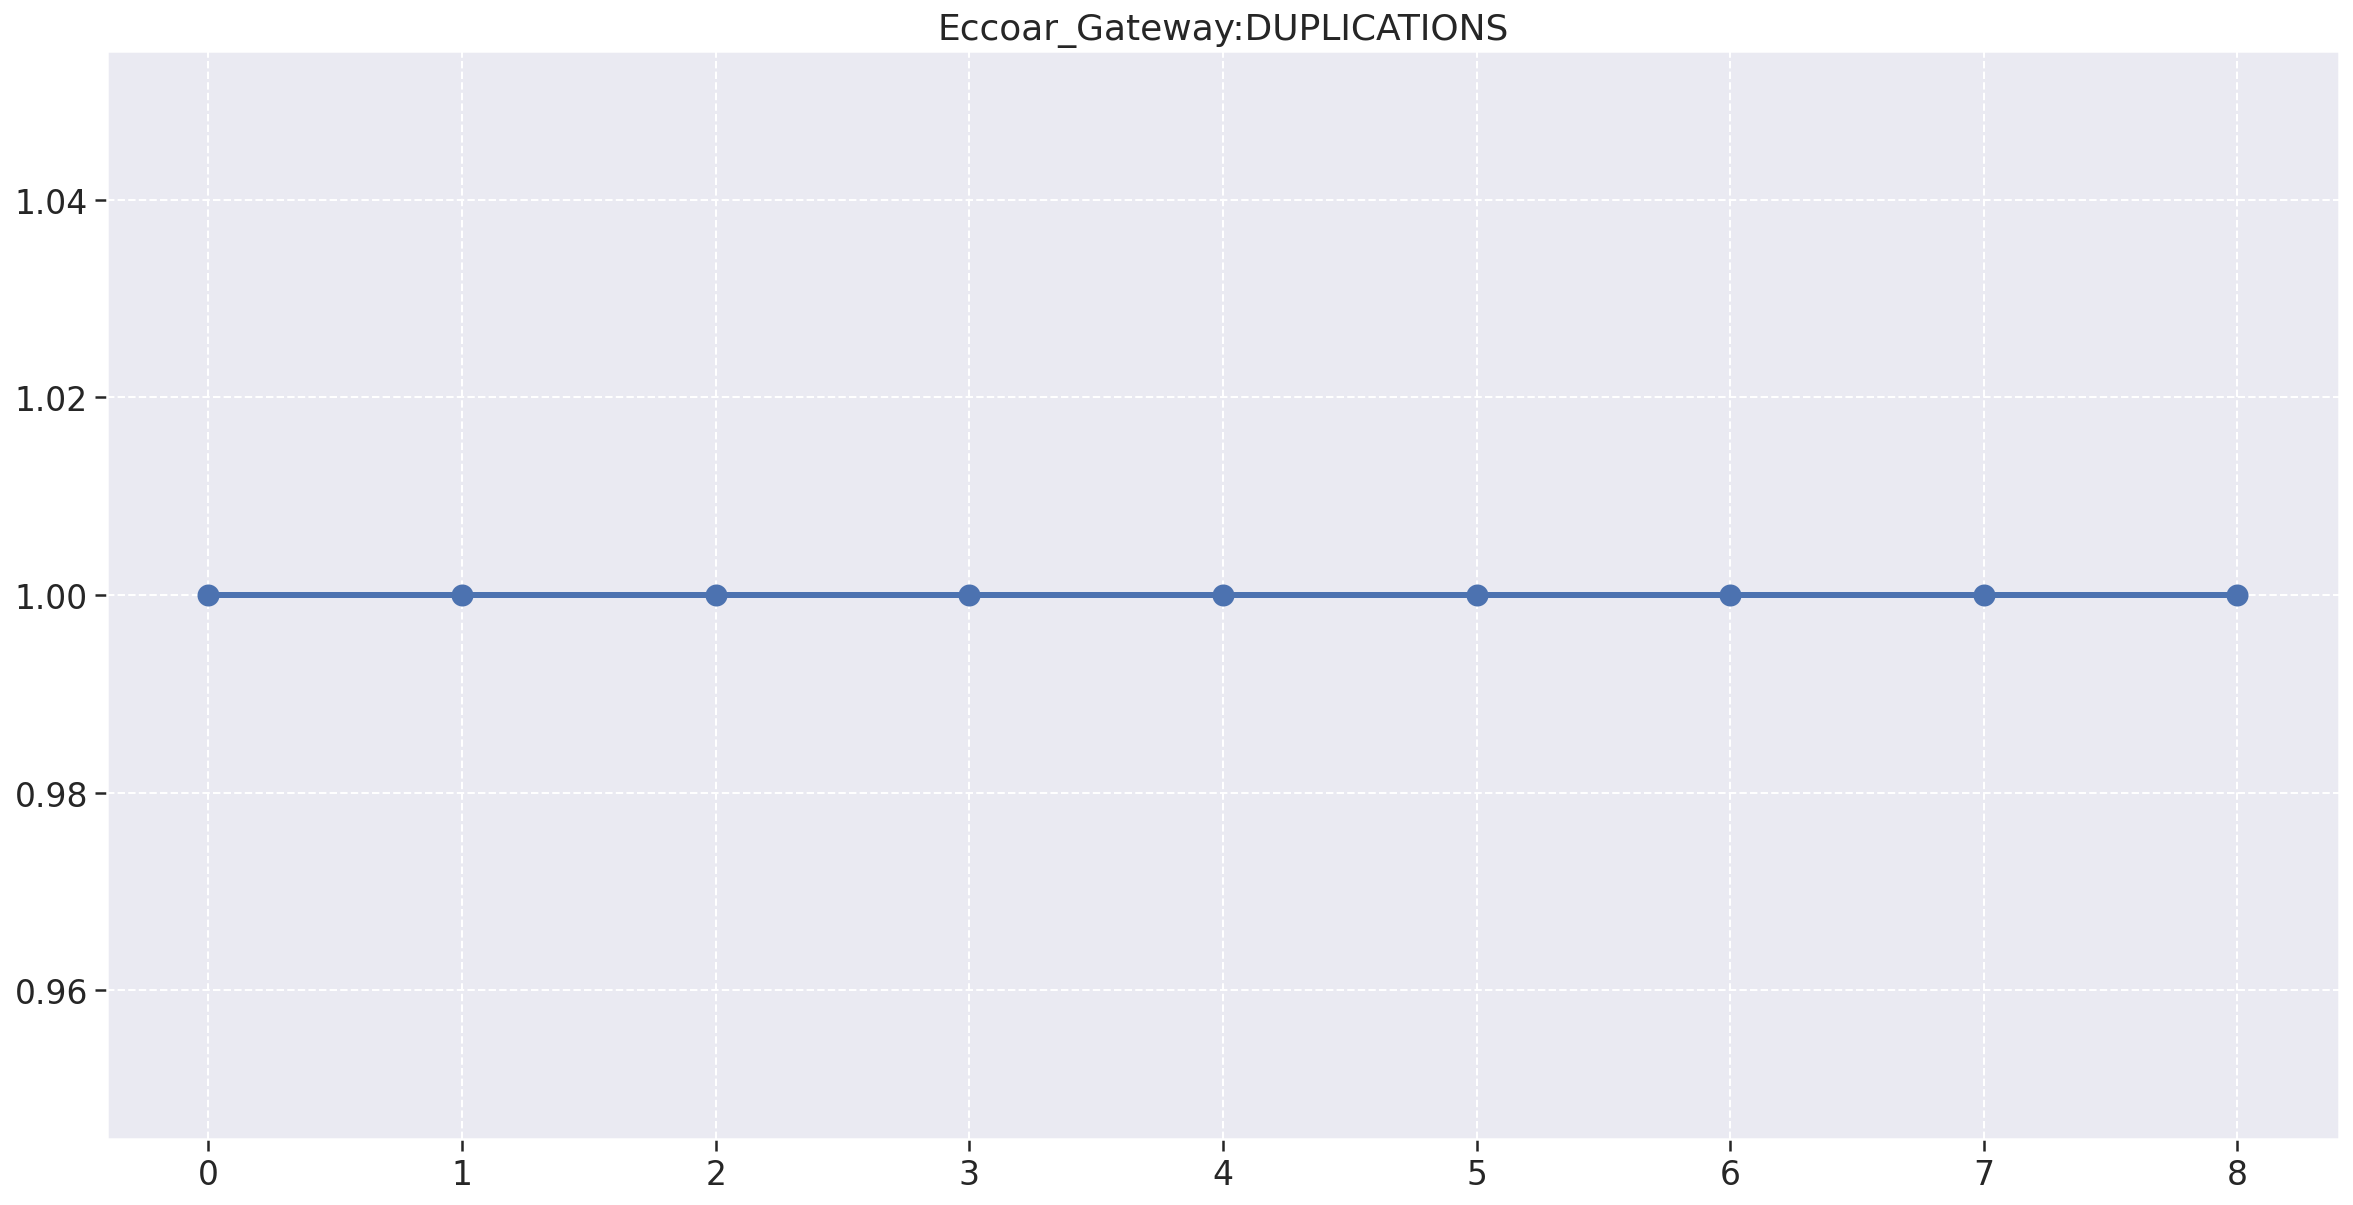

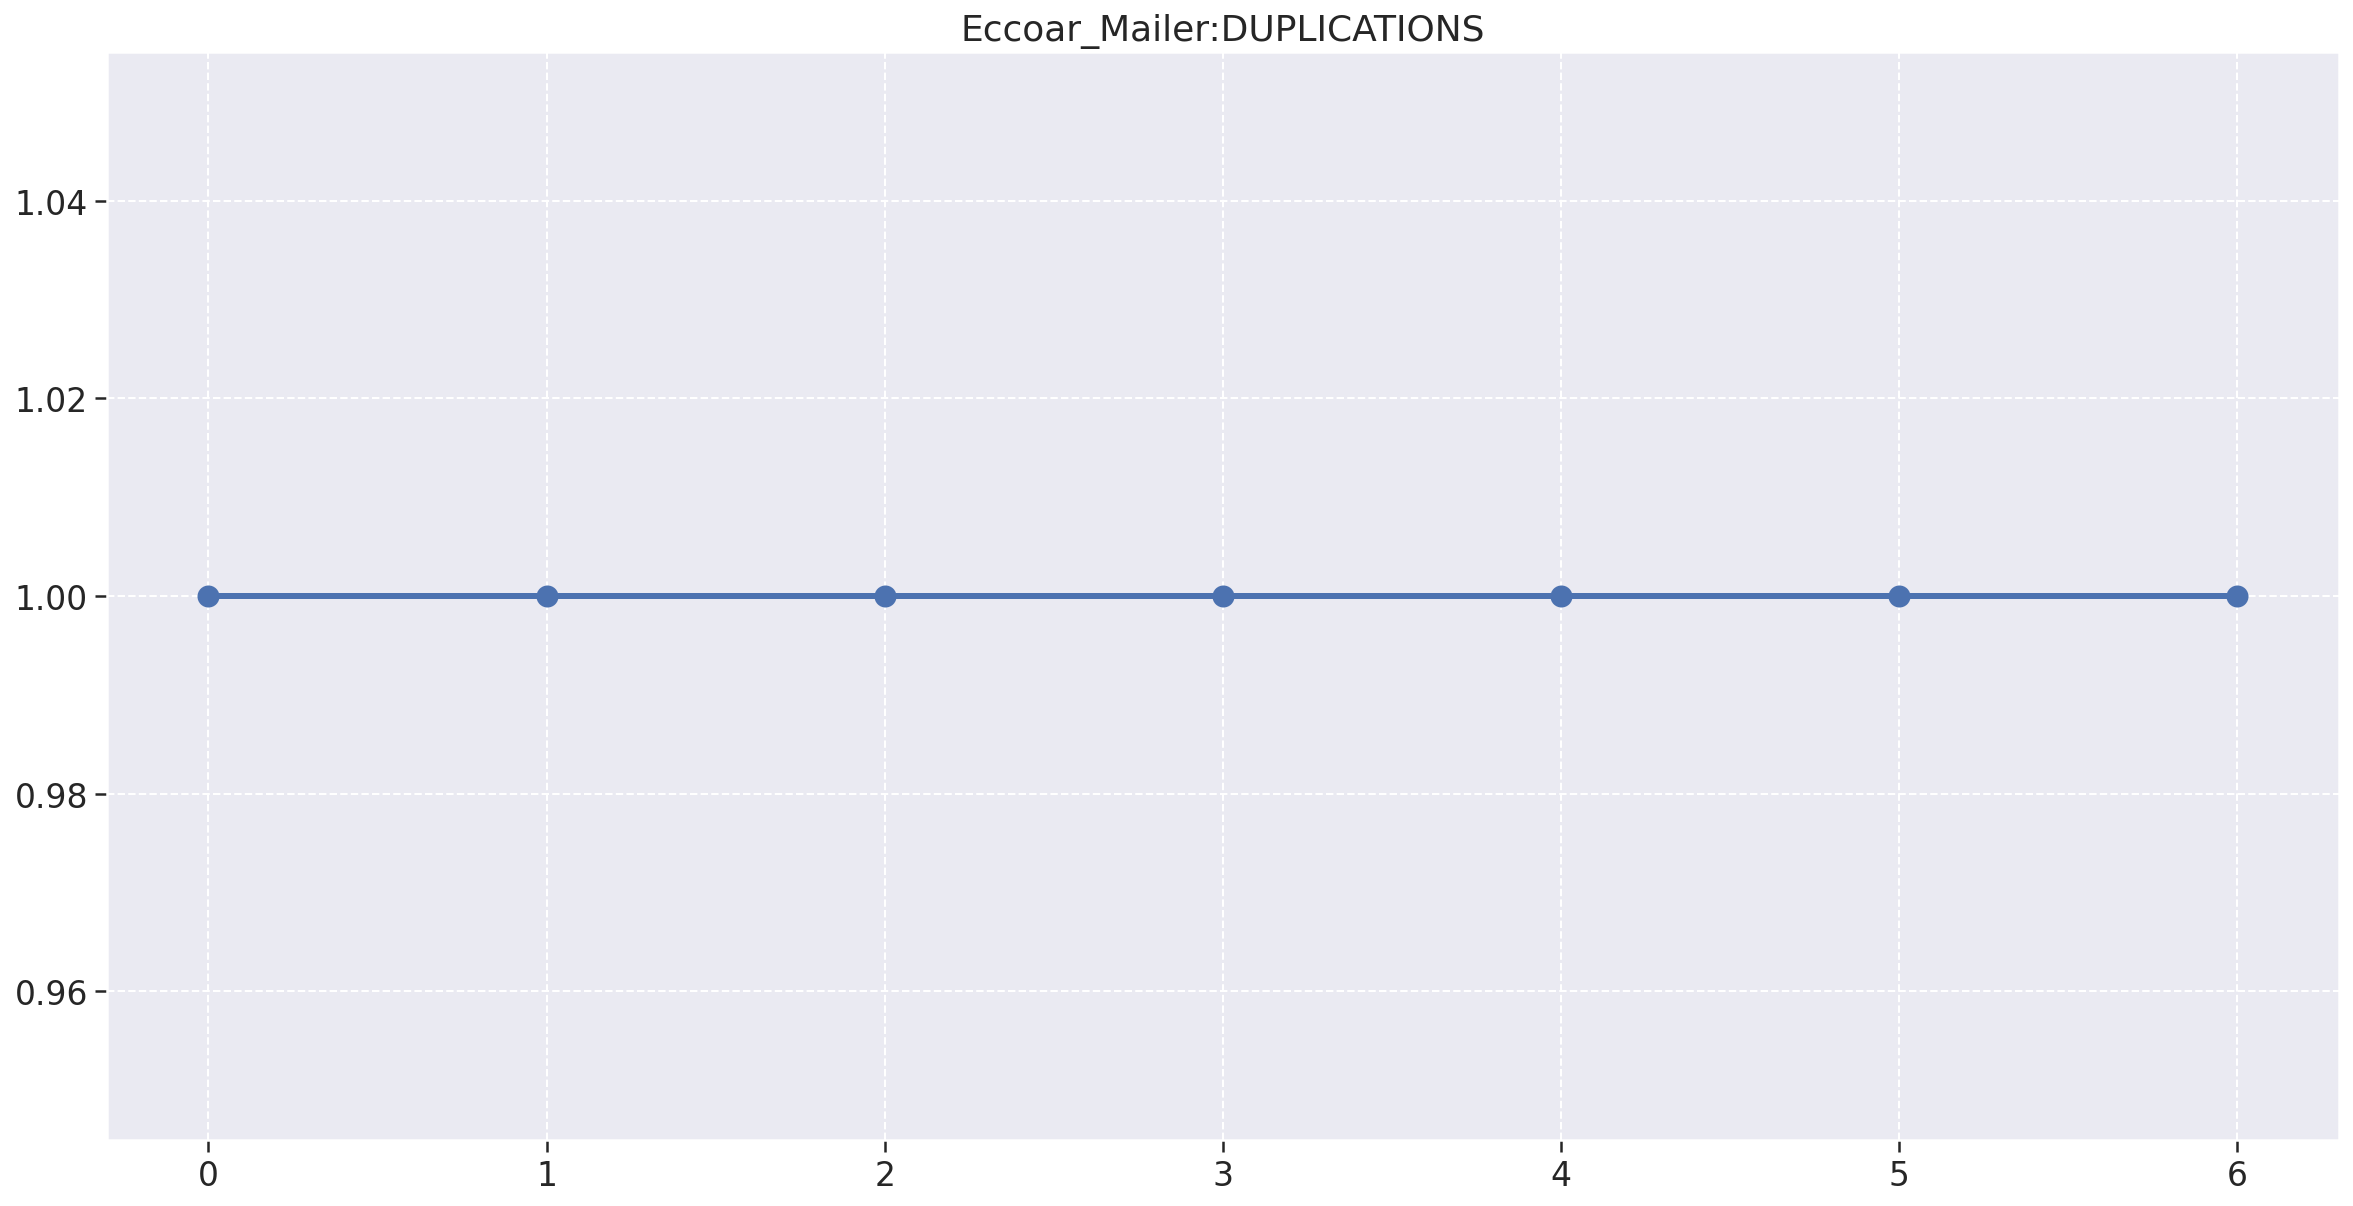

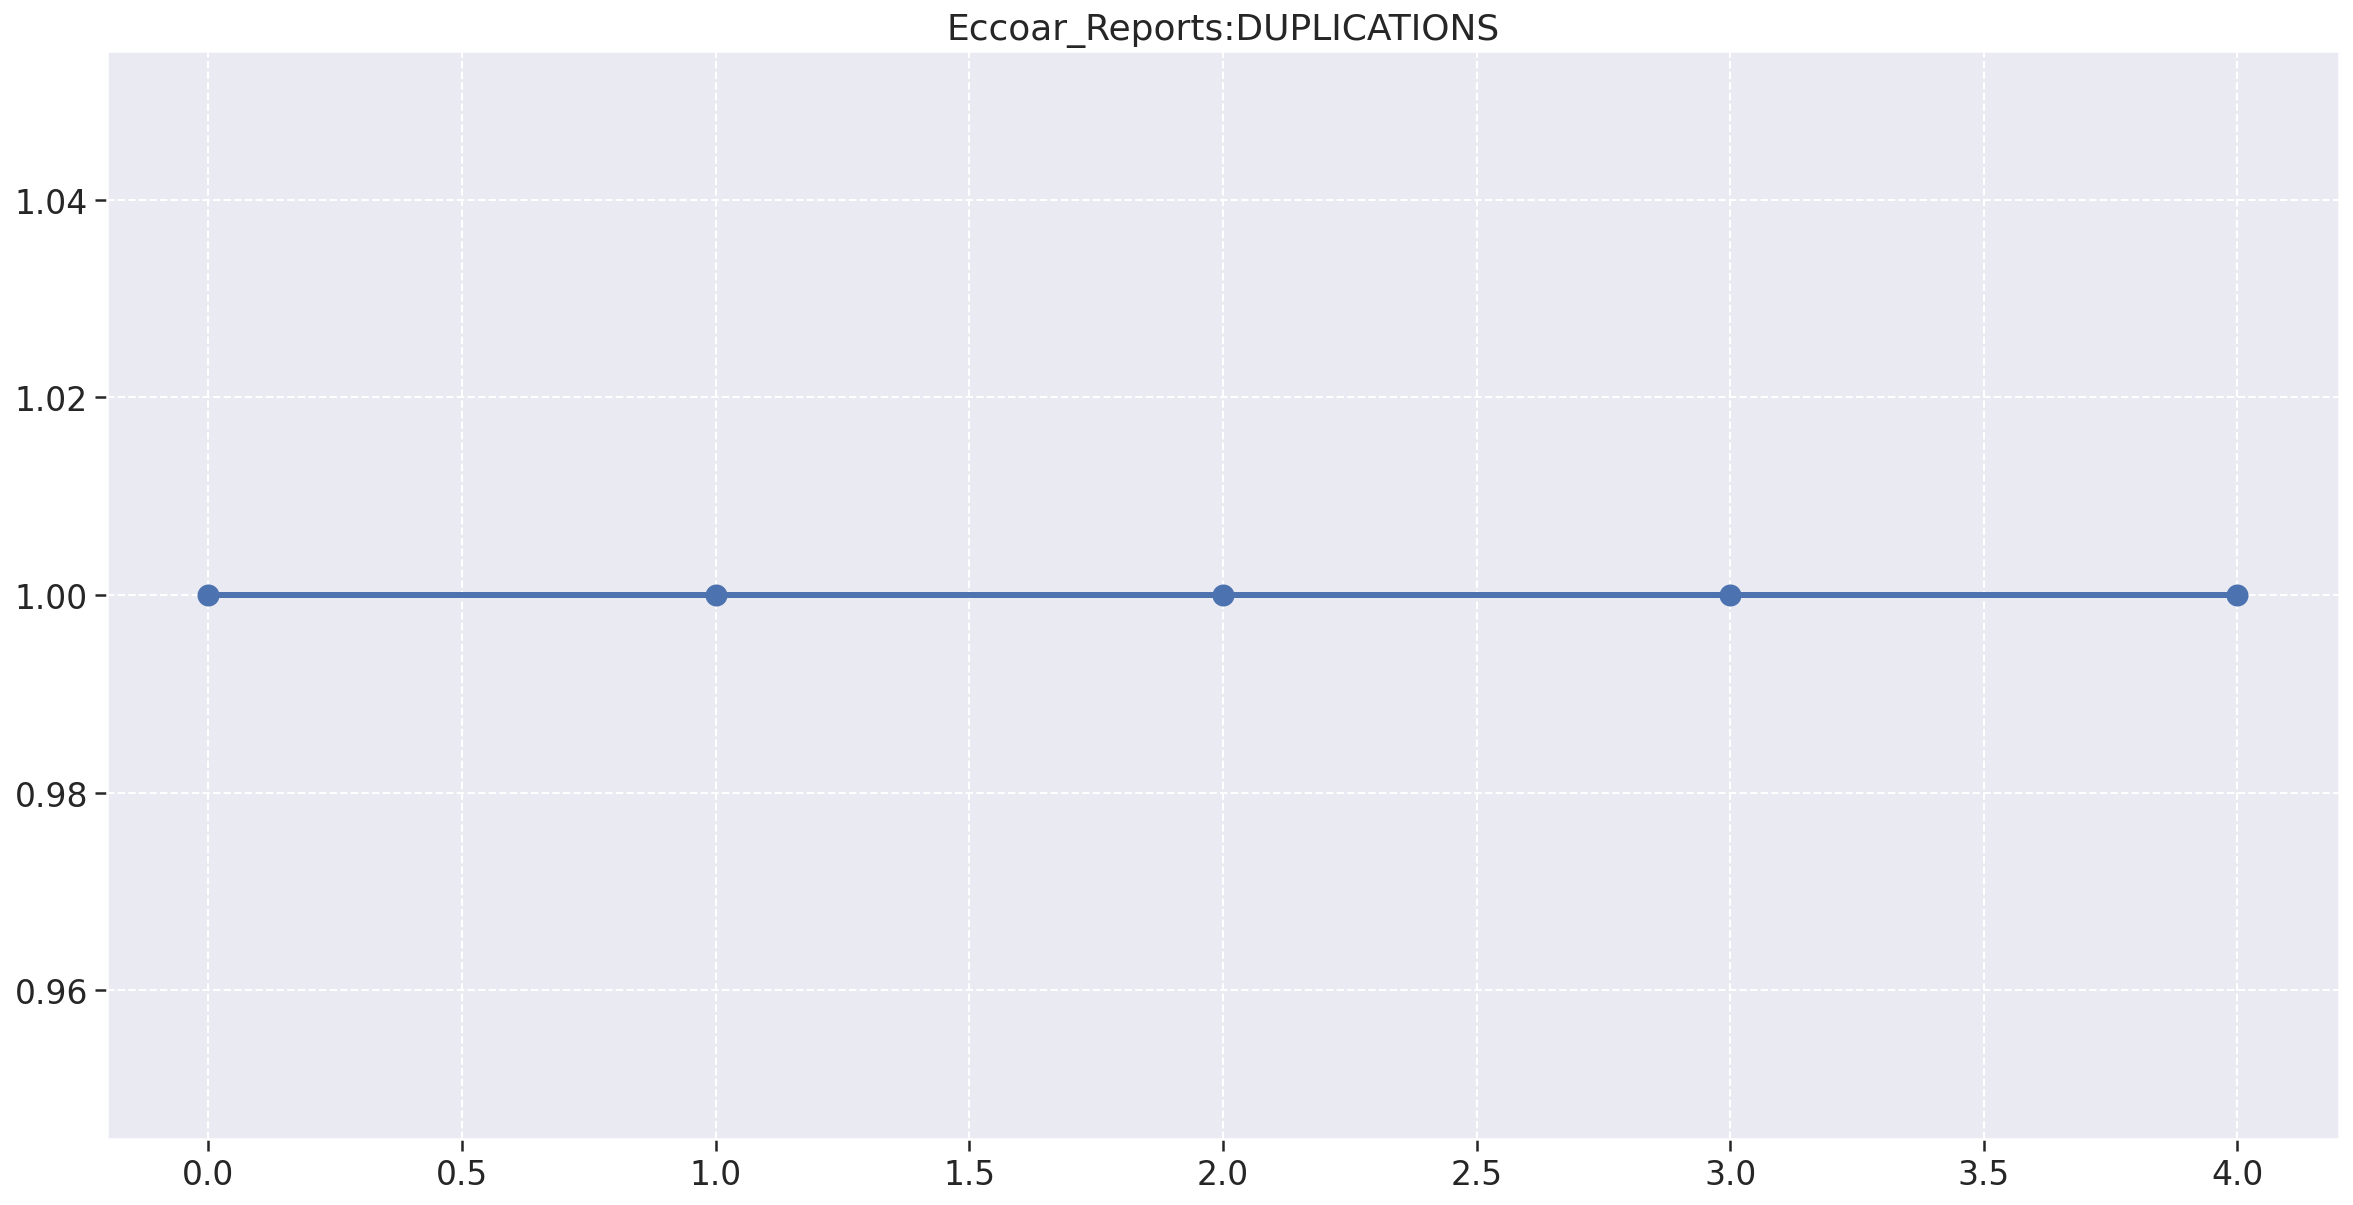

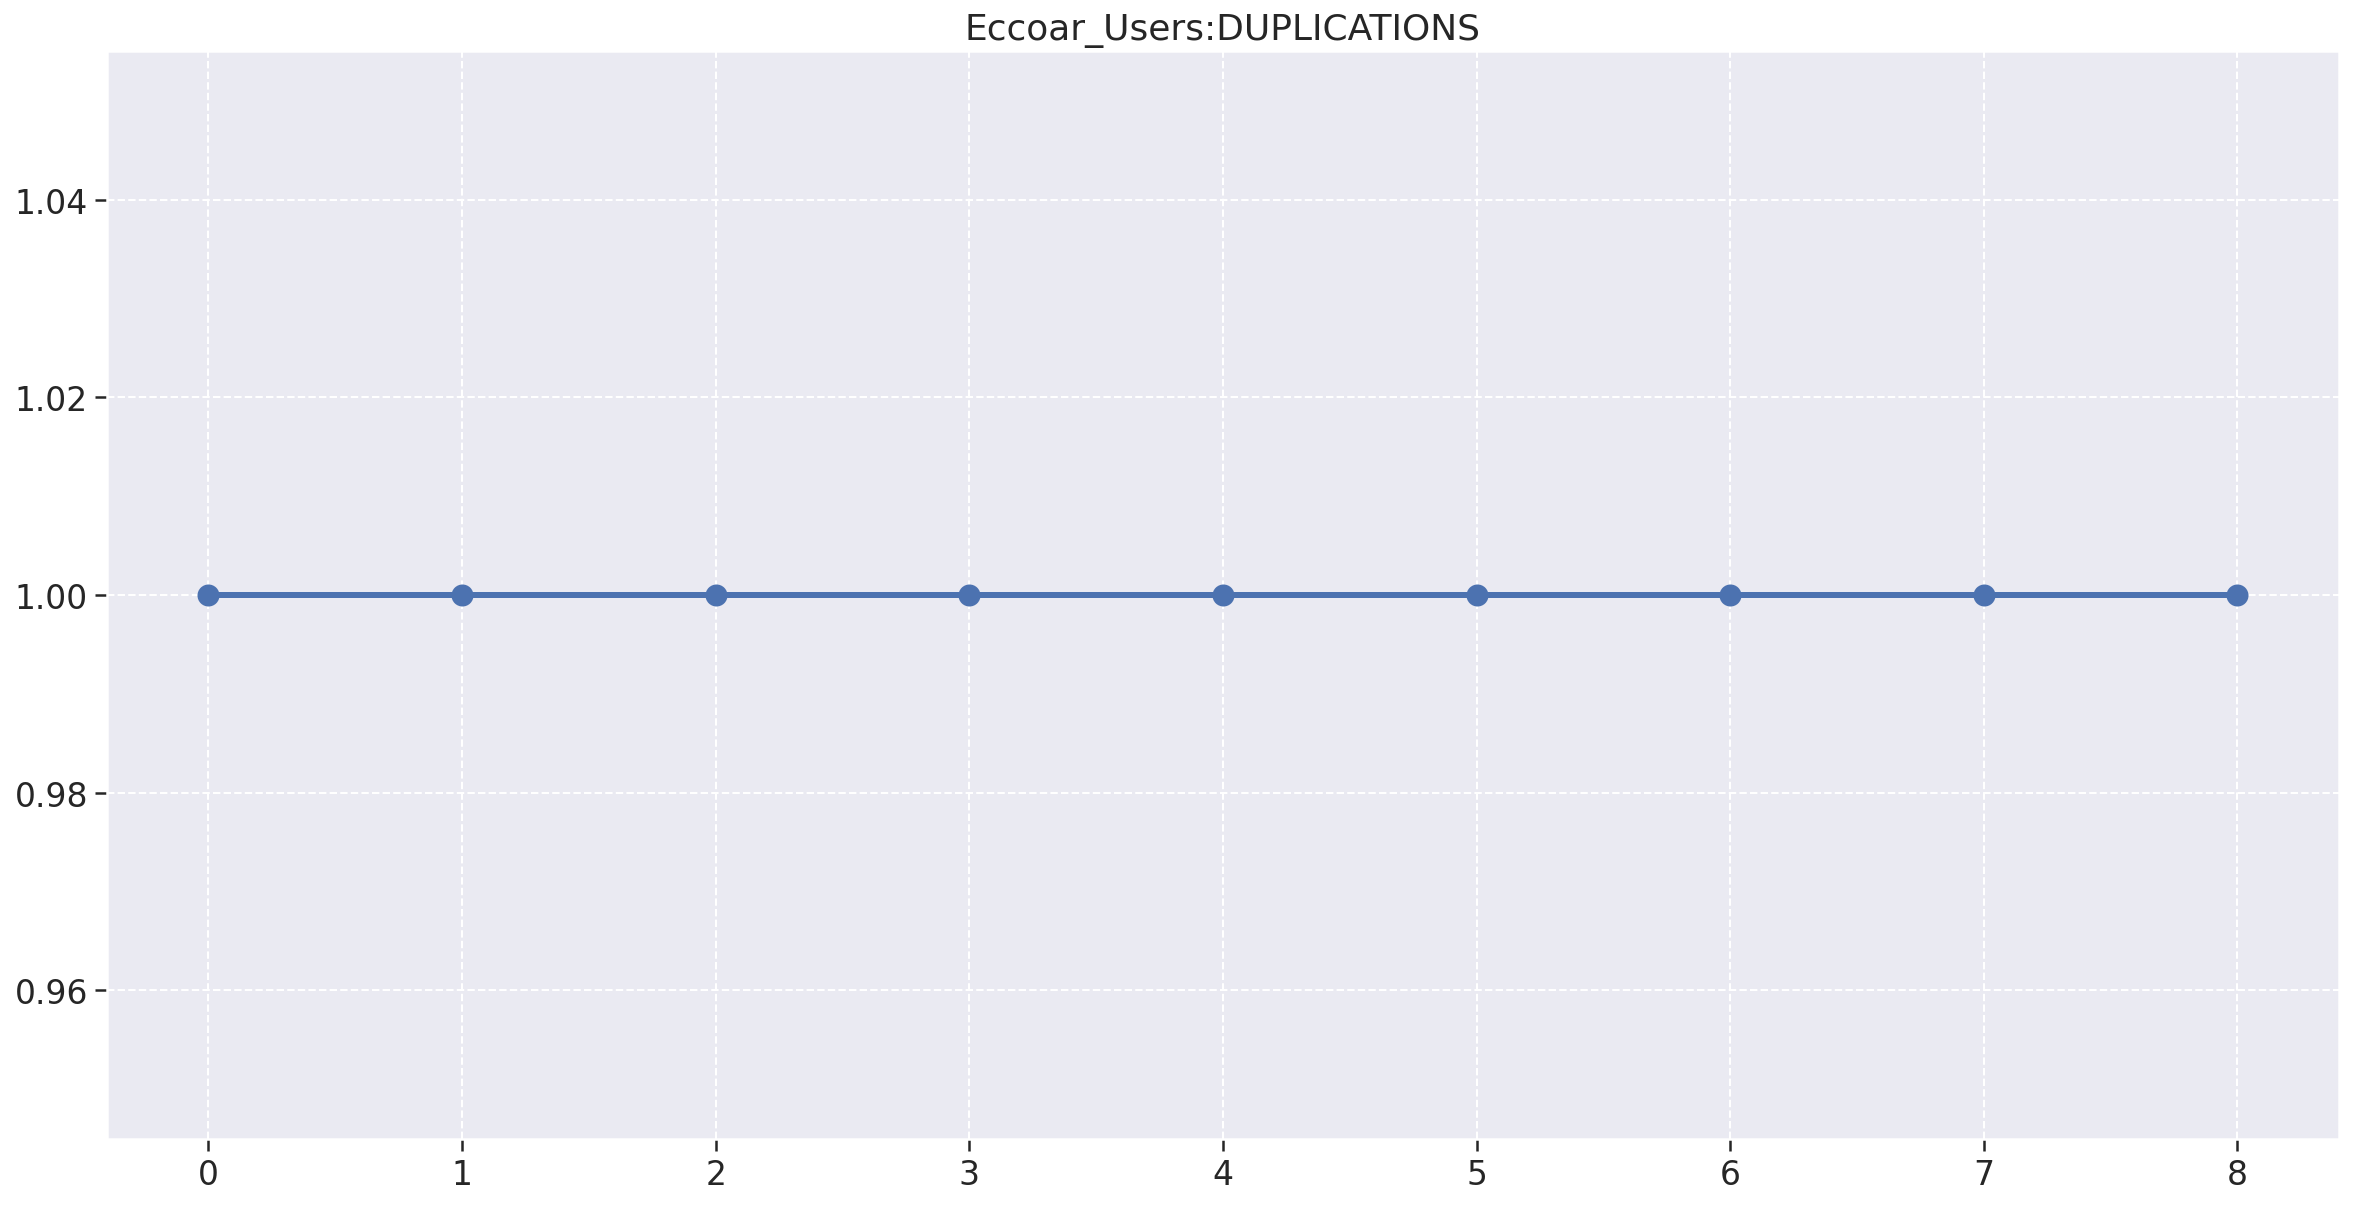

In [33]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:DUPLICATIONS")
    plt.plot(metrics_df['m3'], linewidth=3, marker='o', markersize=10)

### Sub characteristic aggregation

- You must do this for each of your repositories

In [34]:
psc1 = 1
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

for repository, metrics_df in repository_metrics.items(): 
    metrics_df['asc1'] = ((metrics_df['m1']*pm1)+(metrics_df['m2']*pm2)+(metrics_df['m3']*pm3))*psc1

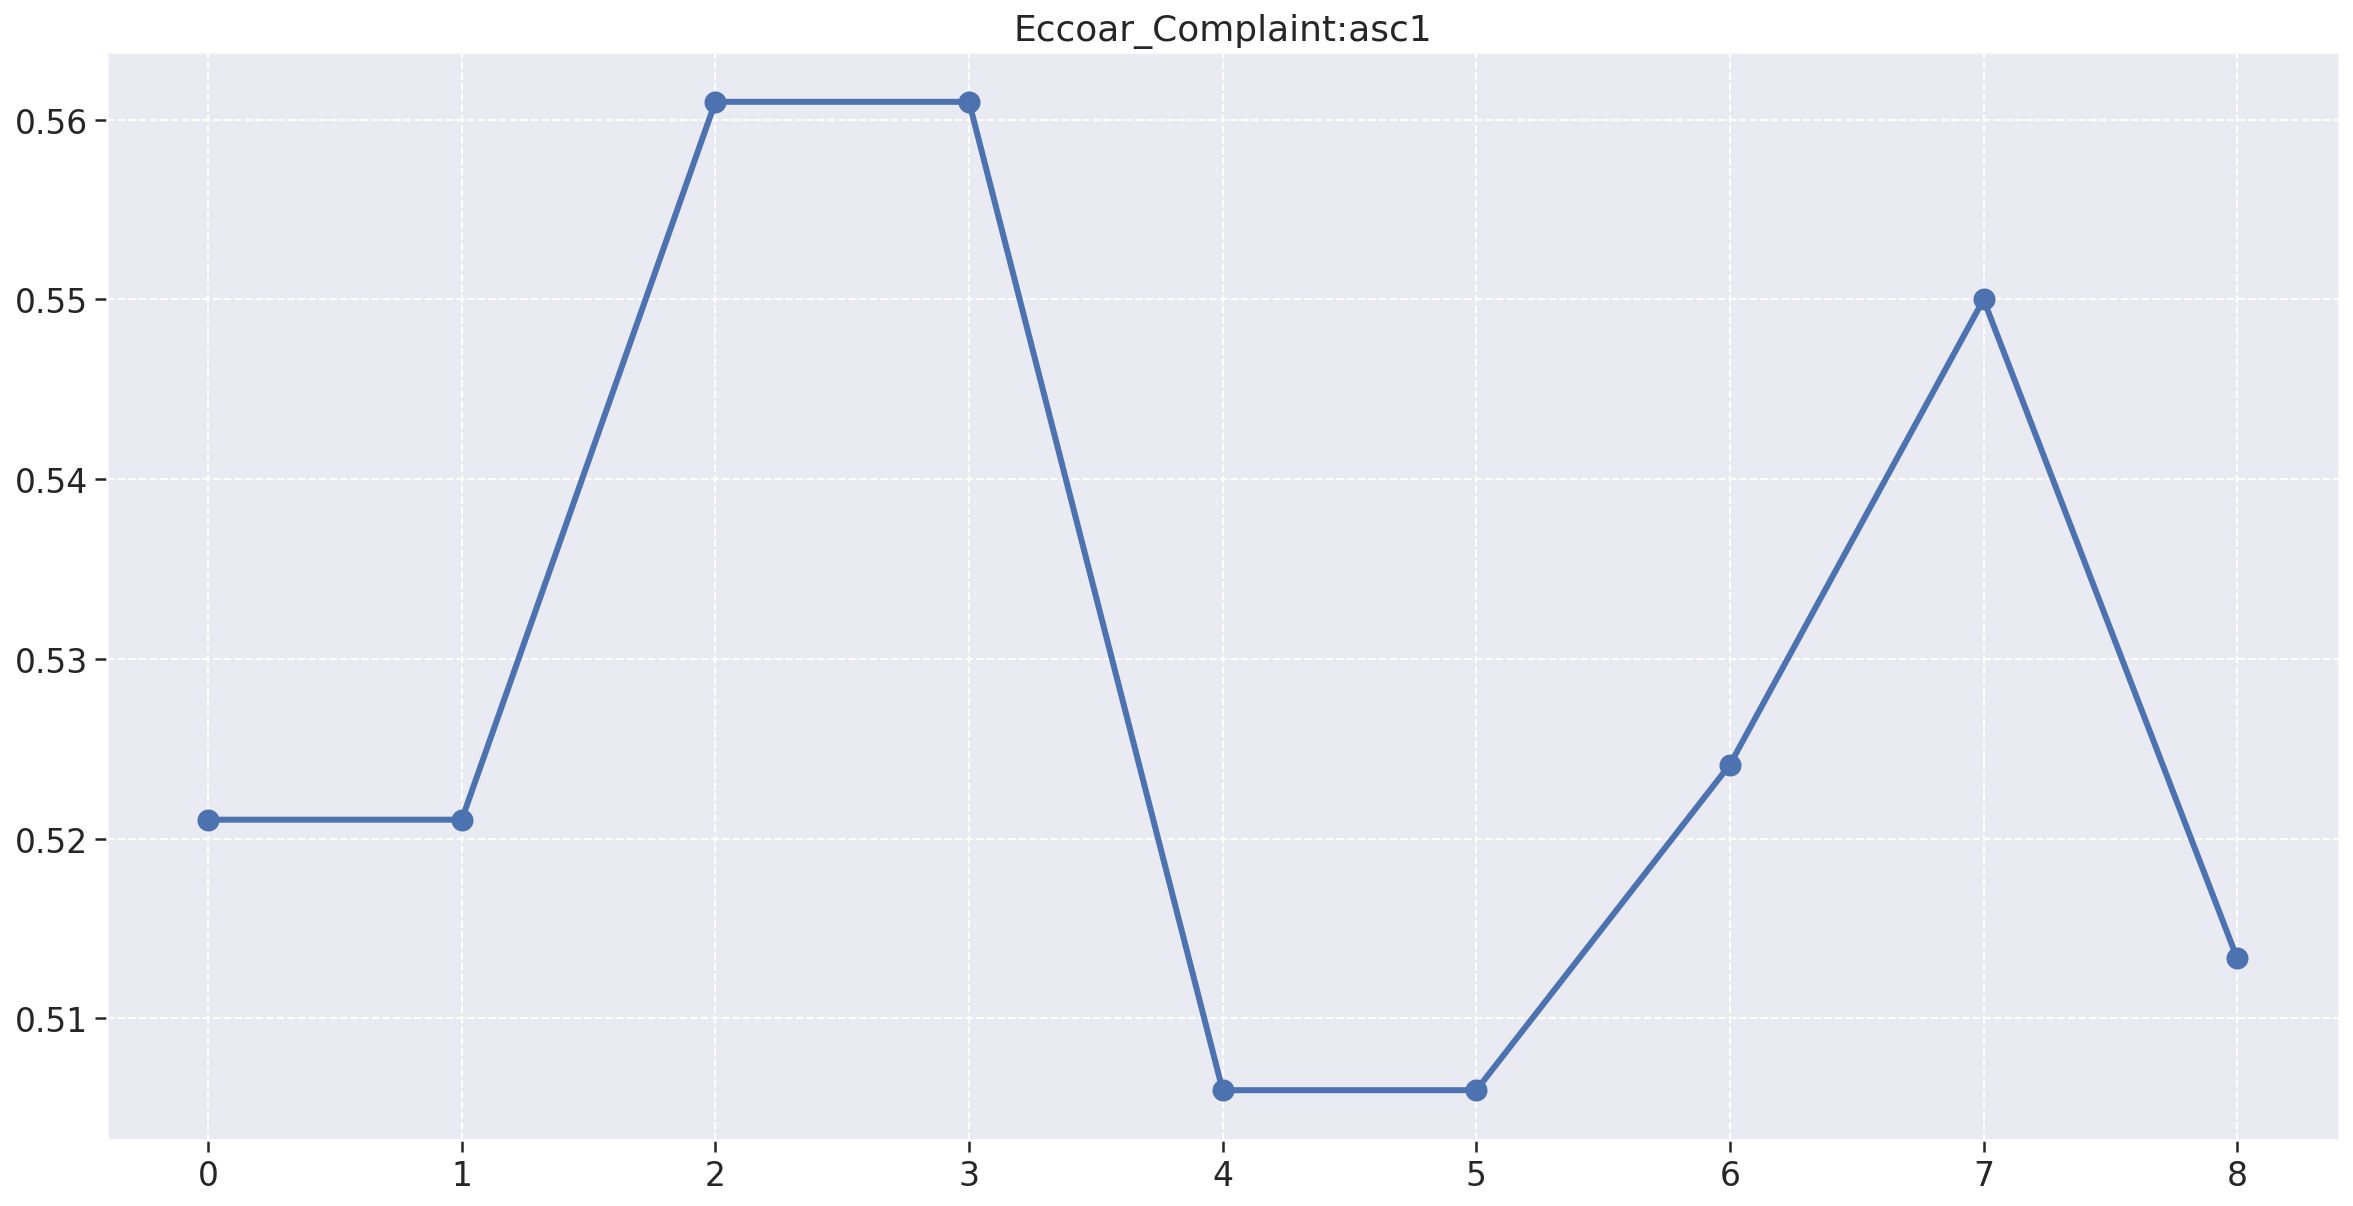

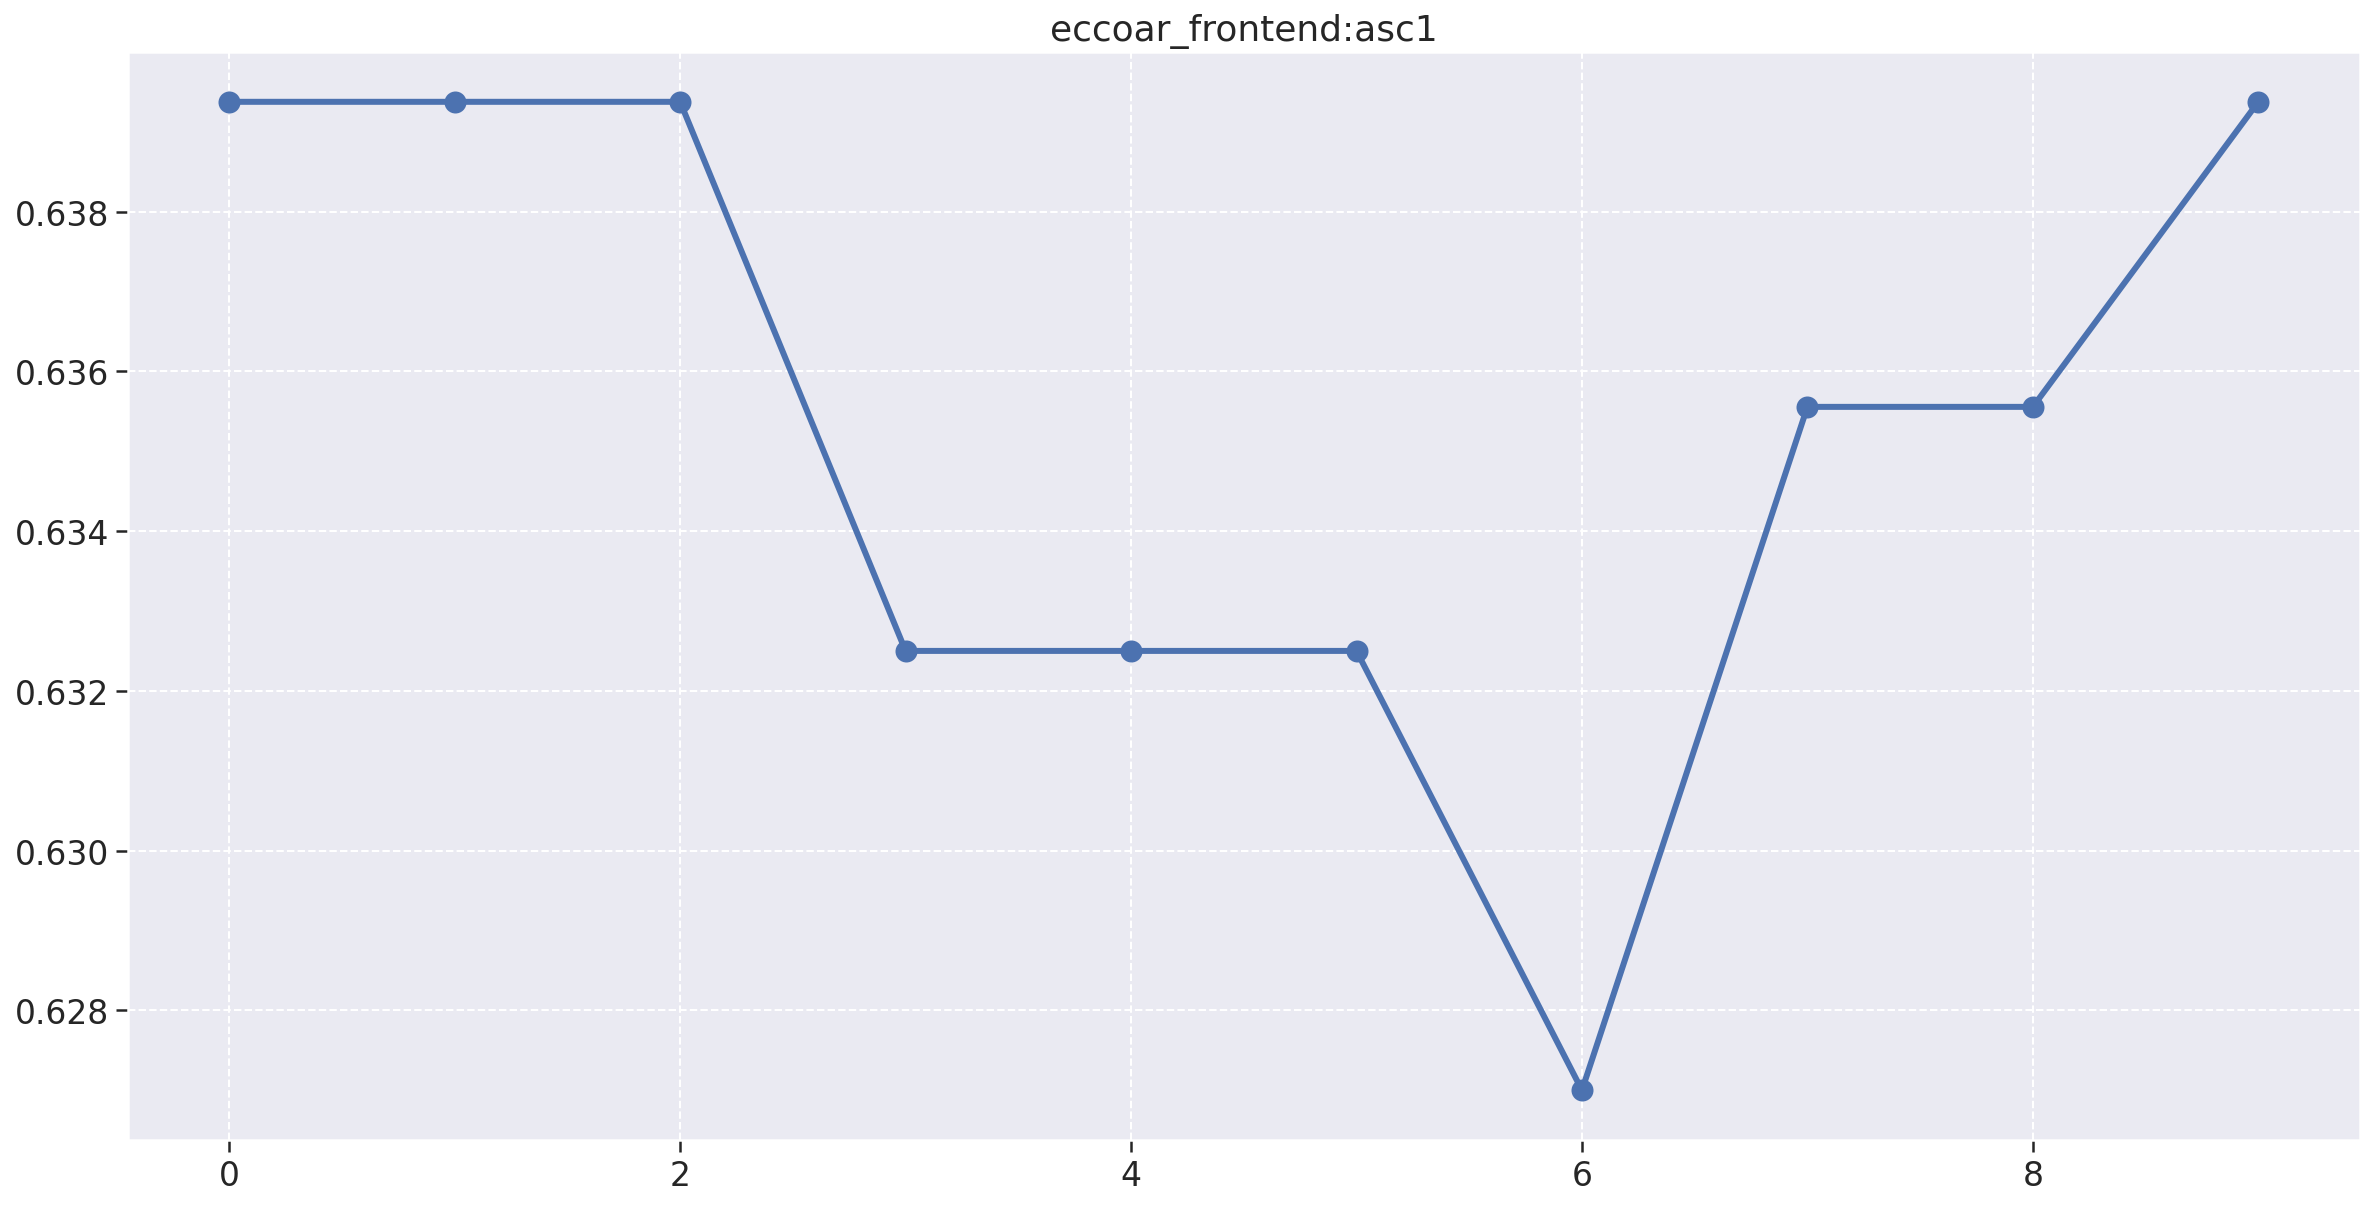

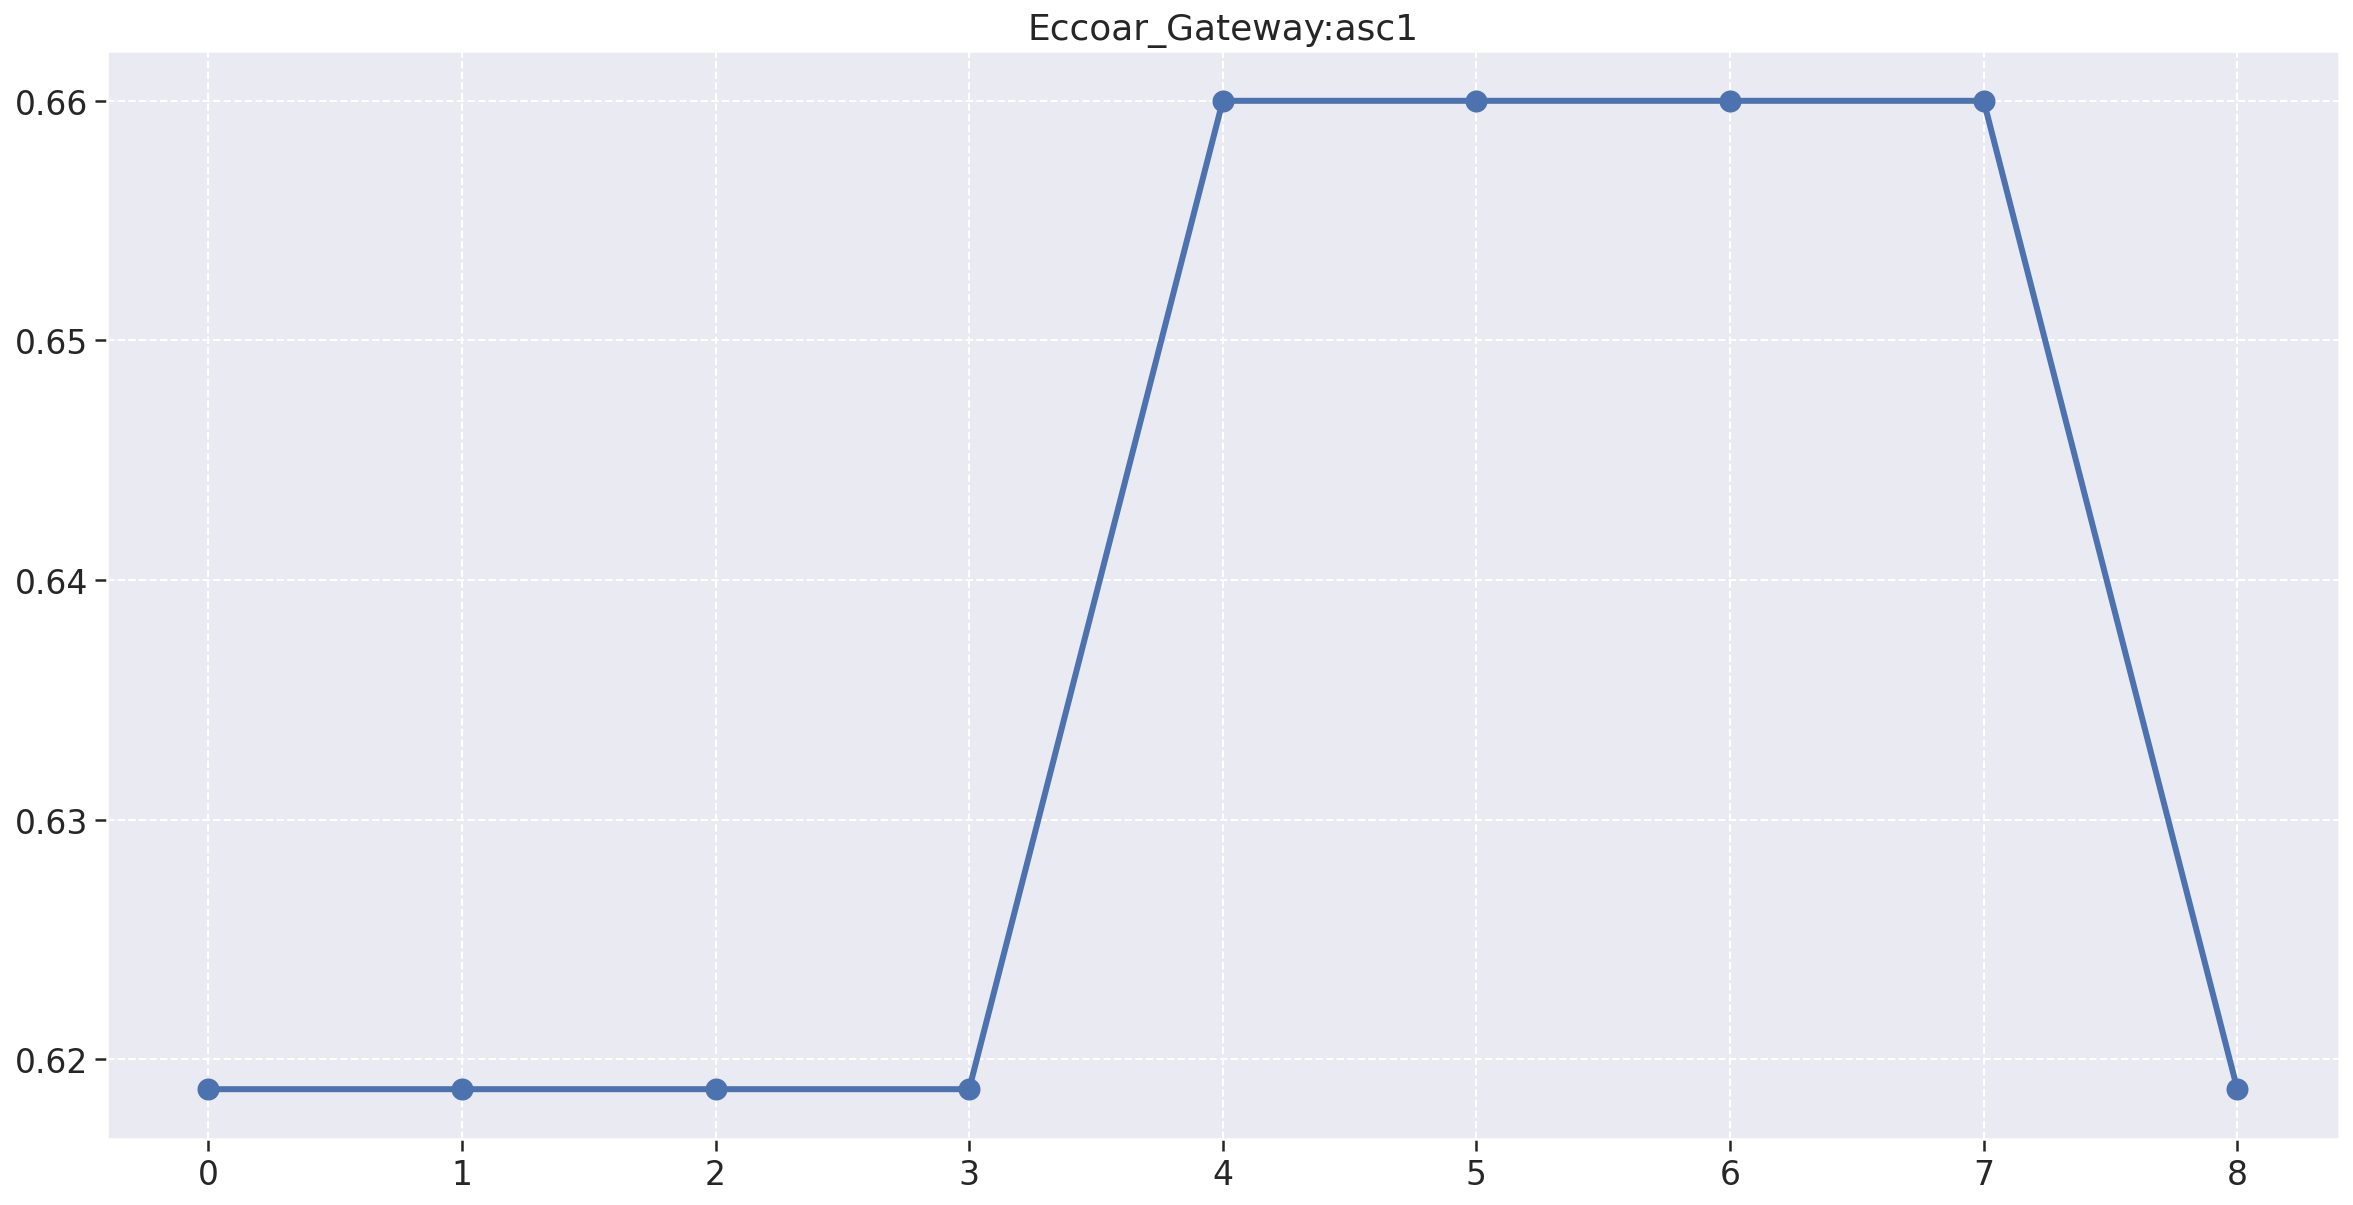

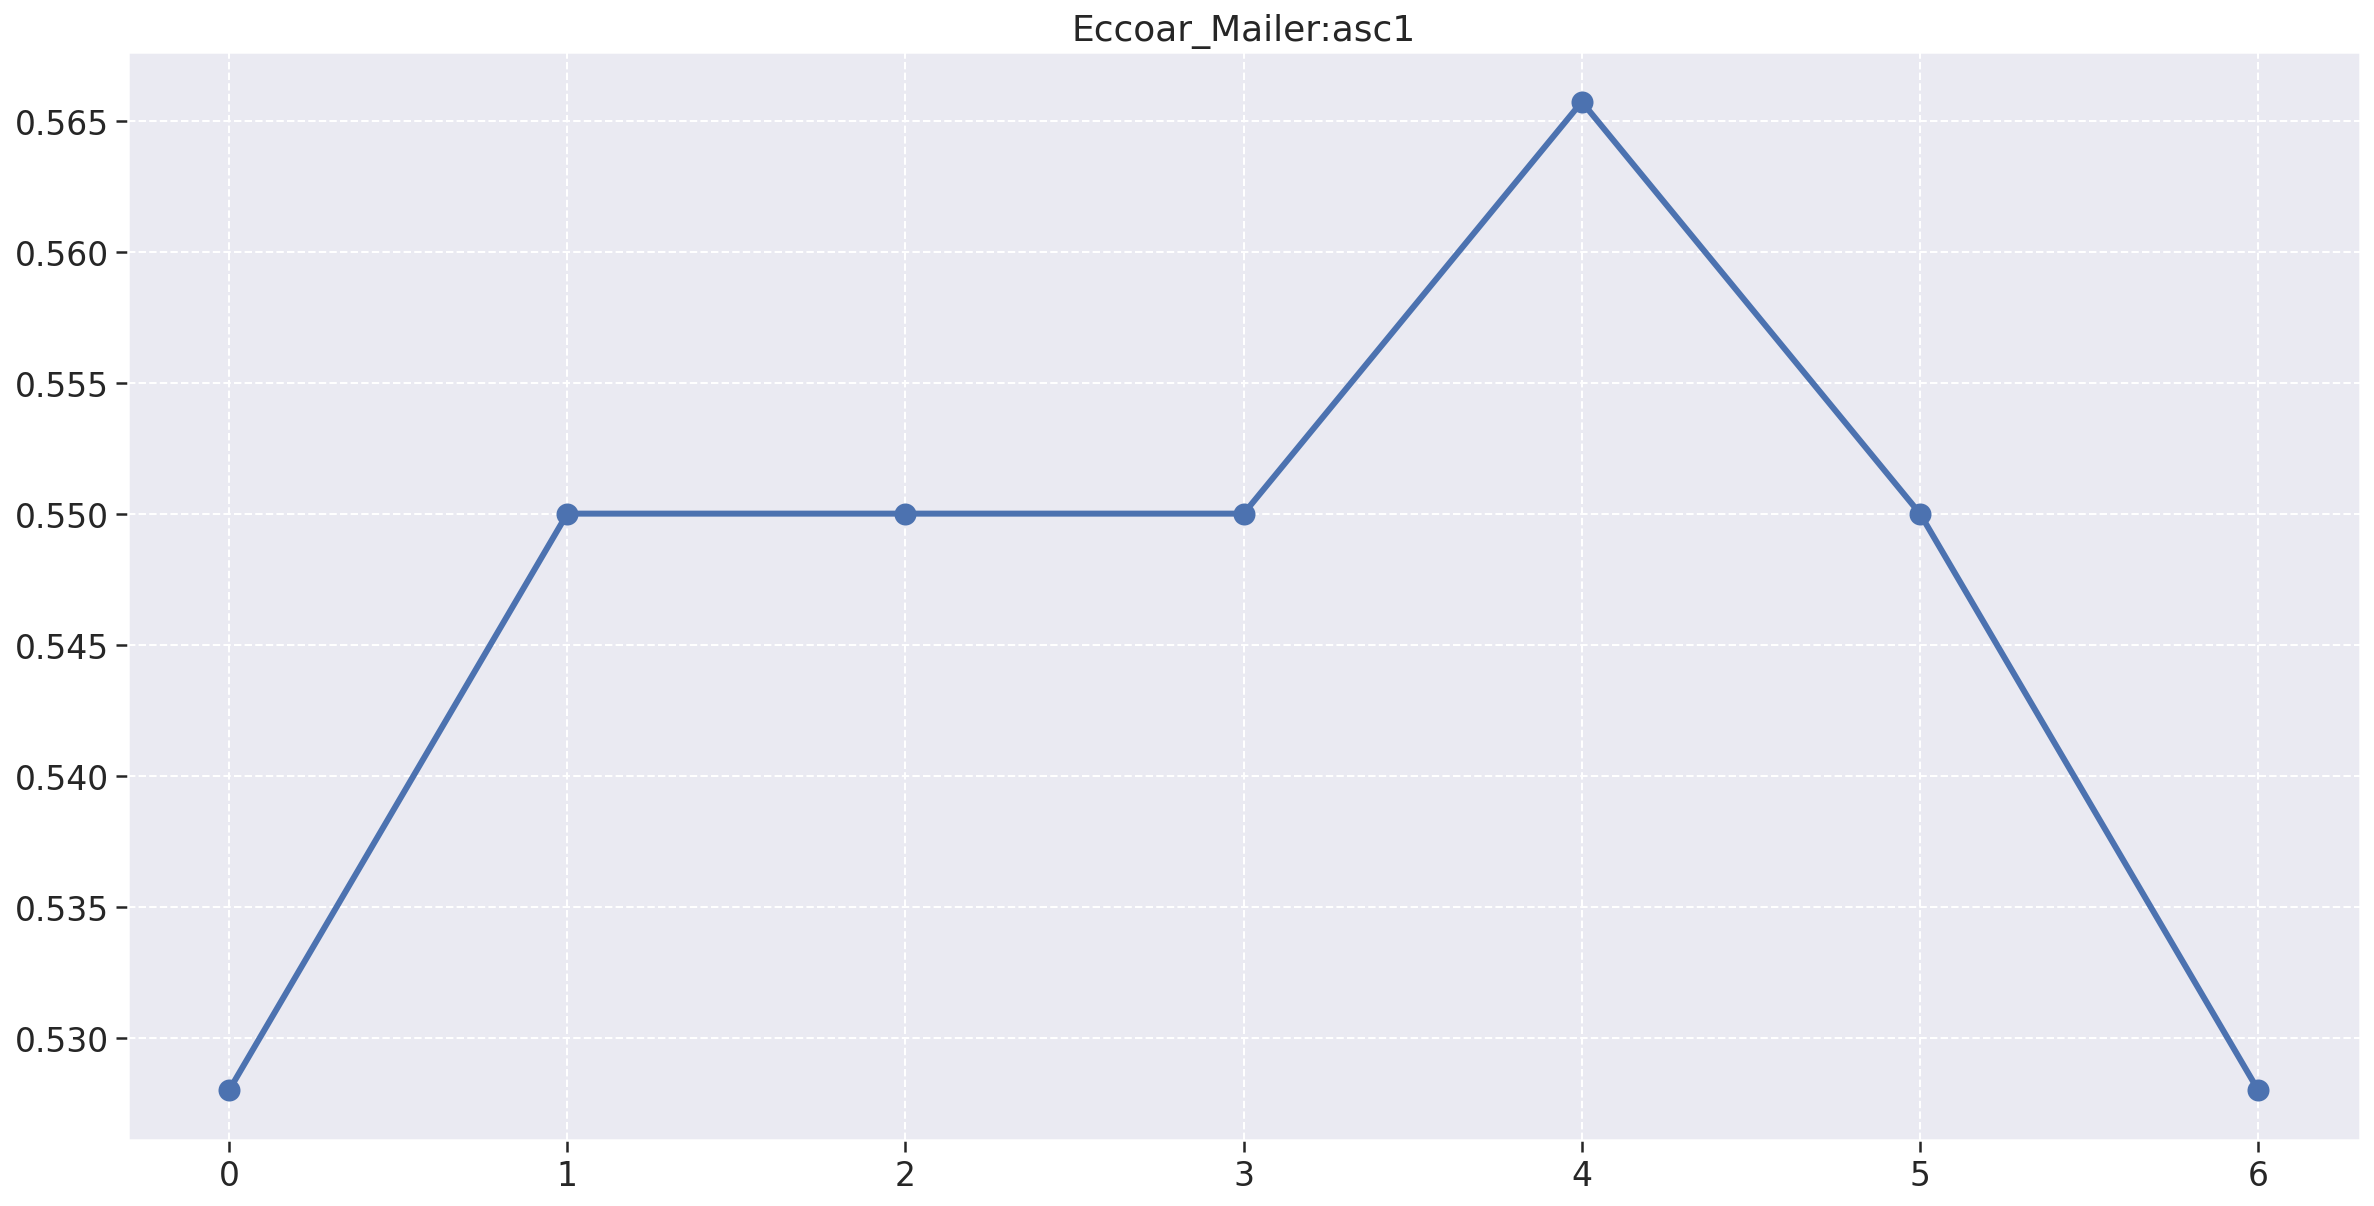

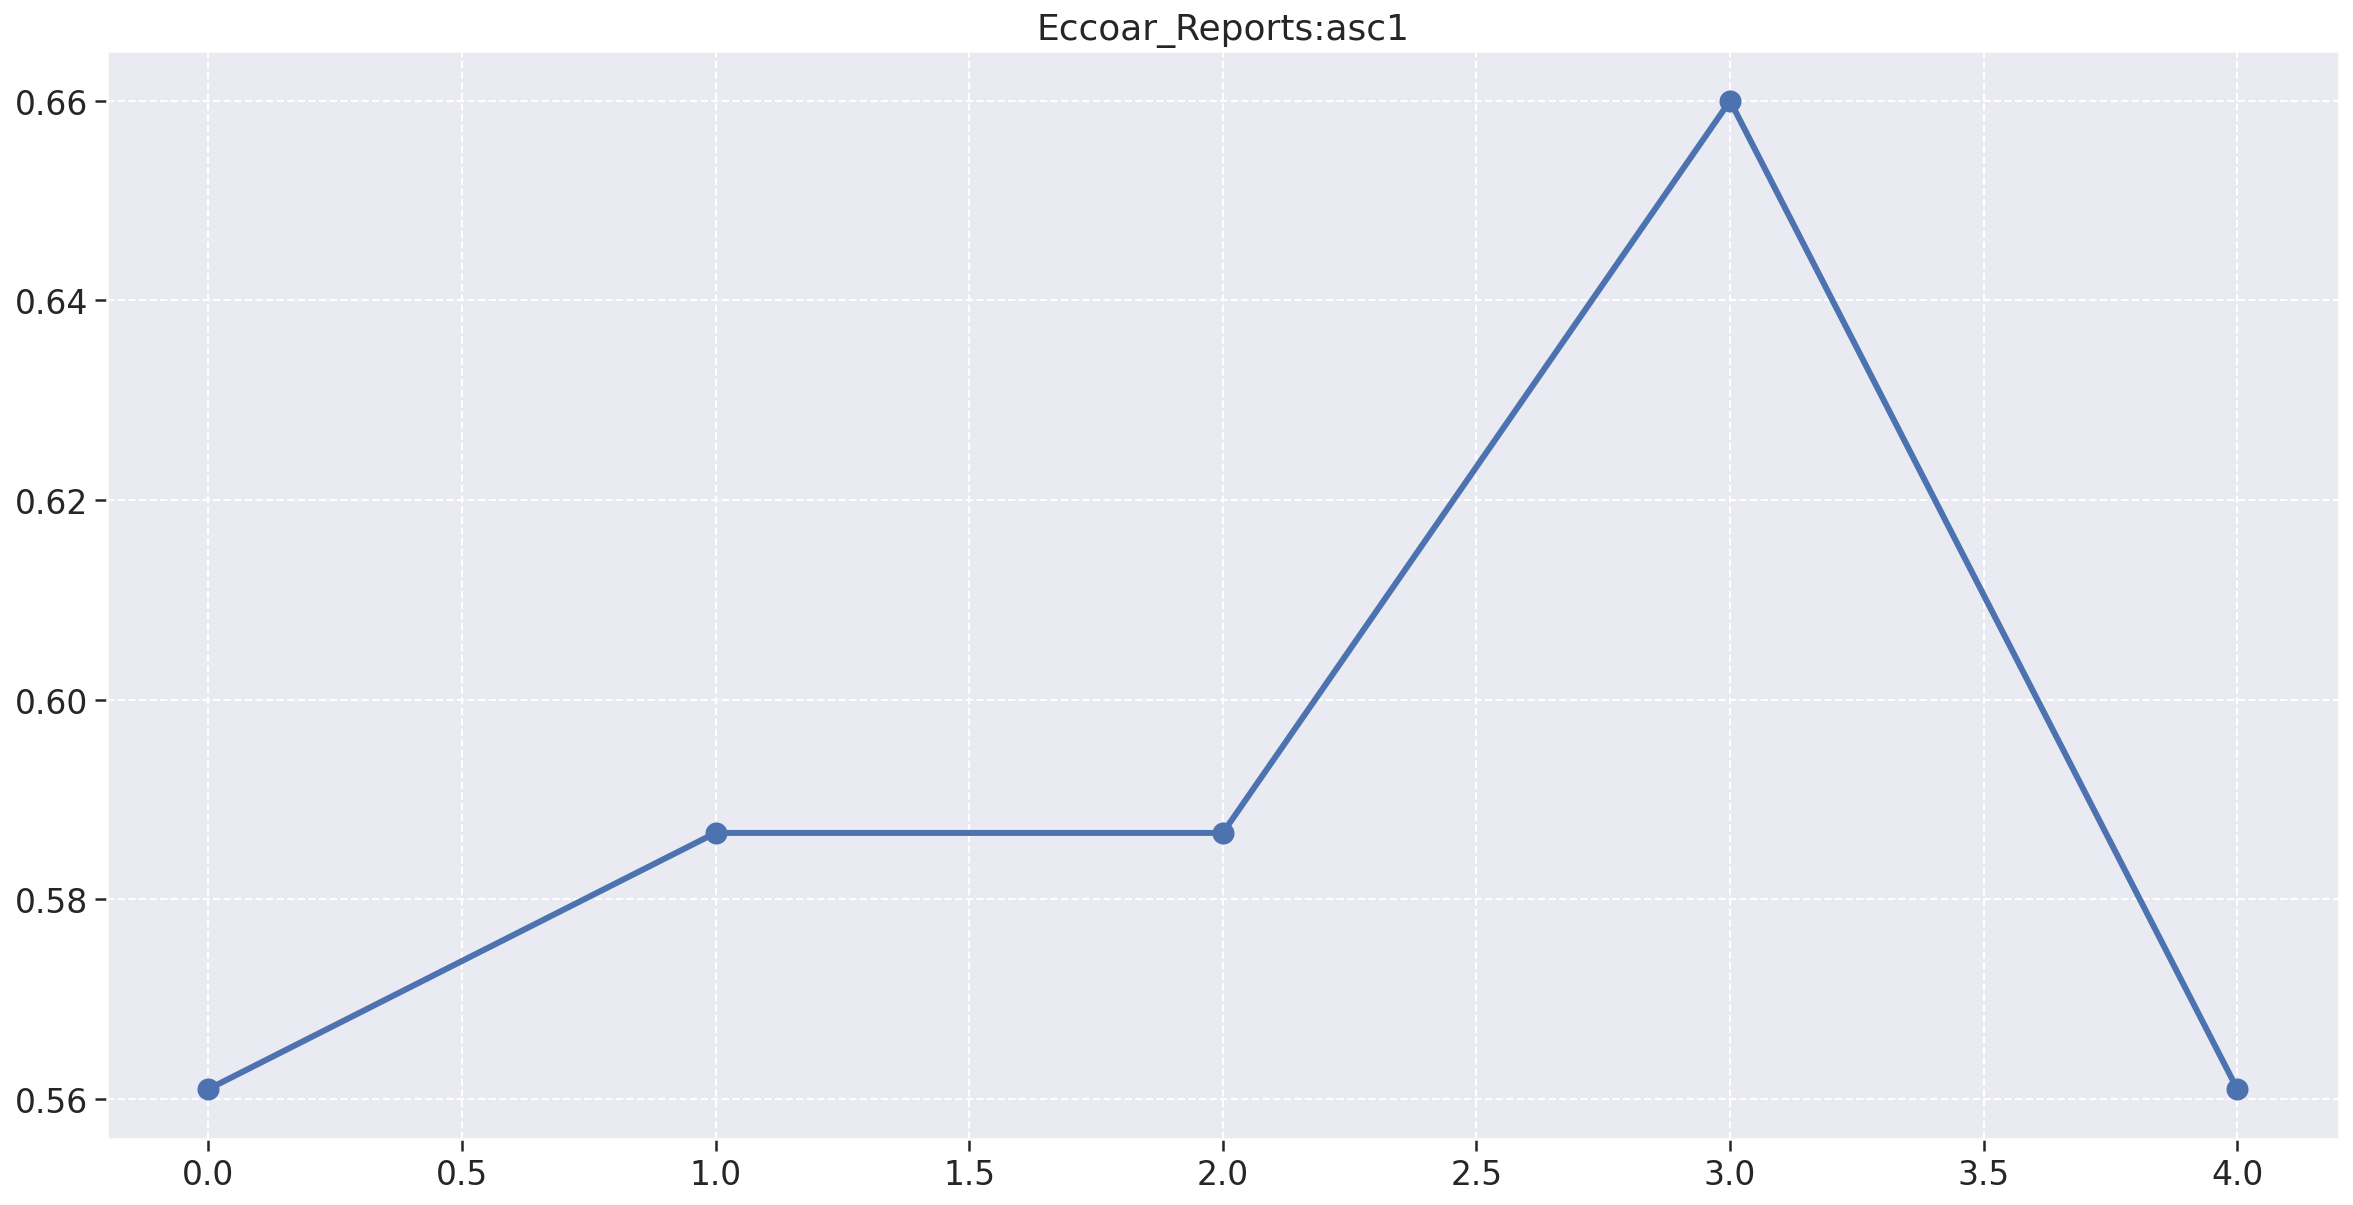

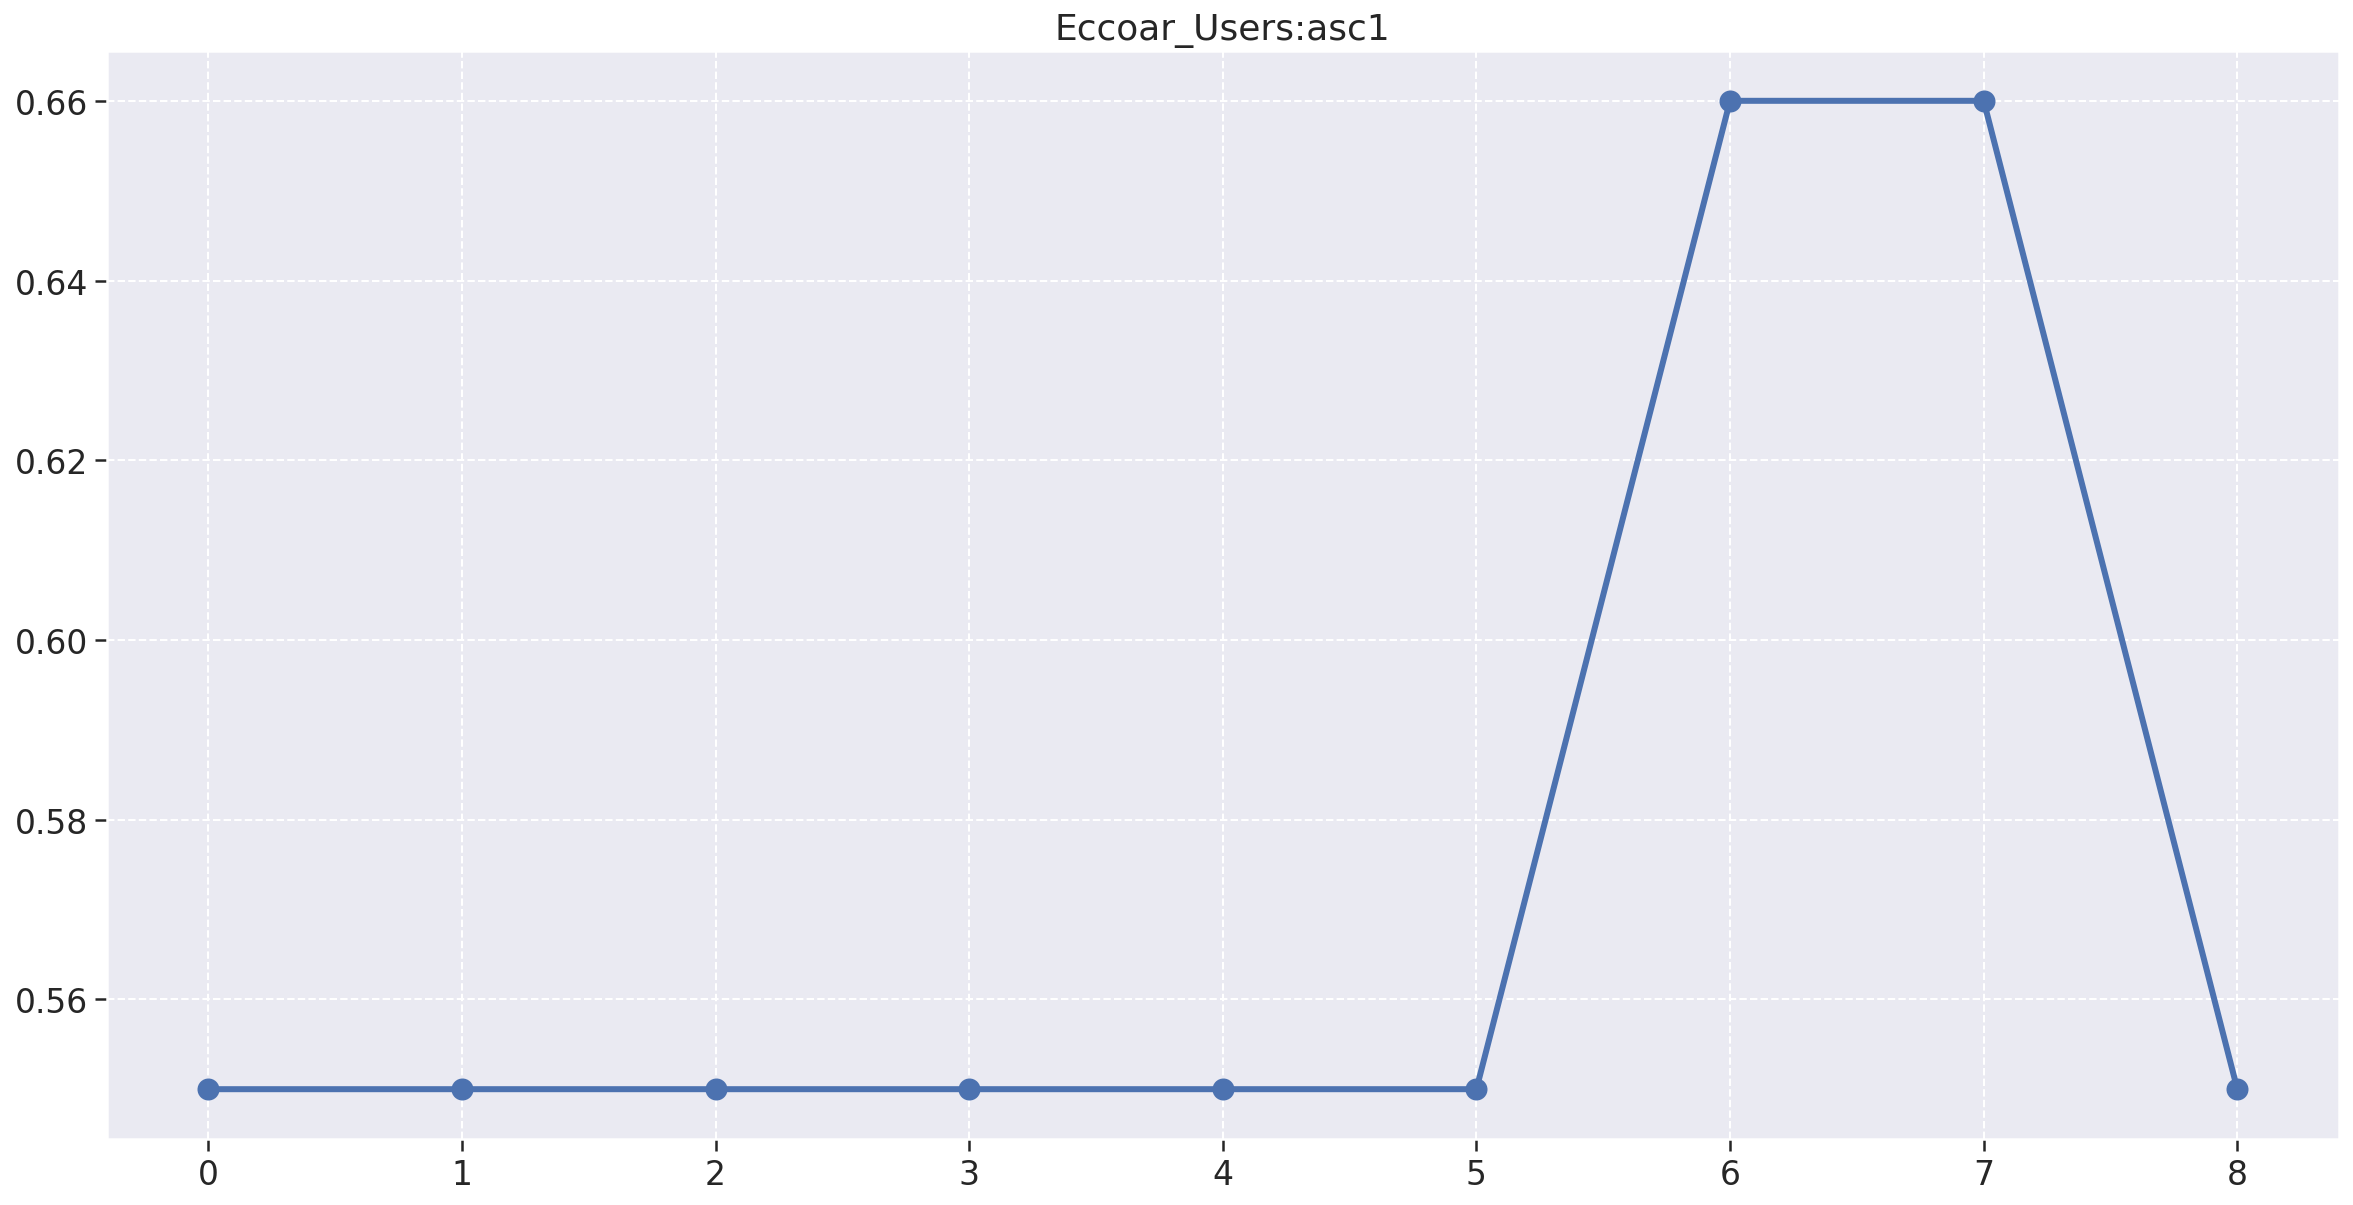

In [35]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:asc1")
    plt.plot(metrics_df['asc1'], linewidth=3, marker='o', markersize=10)

In [36]:
all_metrics_df = pd.DataFrame()

for repository, metrics_df in repository_metrics.items():
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

all_metrics_df['ac1'] = all_metrics_df['asc1'] * 1
all_metrics_df['total'] = all_metrics_df['asc1'] * 1

In [37]:
all_metrics_df

,m1,m2,m3,repository,version,asc1,ac1,total
0,0.578947,0.000000,1.0,Eccoar_Complaint,01-05-2021,0.521053,0.521053,0.521053
1,0.578947,0.000000,1.0,Eccoar_Complaint,03-05-2021,0.521053,0.521053,0.521053
2,0.700000,0.000000,1.0,Eccoar_Complaint,05-05-2021,0.561000,0.561000,0.561000
3,0.700000,0.000000,1.0,Eccoar_Complaint,10-05-2021,0.561000,0.561000,0.561000
4,0.533333,0.000000,1.0,Eccoar_Complaint,12-04-2021,0.506000,0.506000,0.506000
5,0.533333,0.000000,1.0,Eccoar_Complaint,17-04-2021,0.506000,0.506000,0.506000
6,0.588235,0.000000,1.0,Eccoar_Complaint,21-04-2021,0.524118,0.524118,0.524118
7,0.666667,0.000000,1.0,Eccoar_Complaint,23-03-2021,0.550000,0.550000,0.550000
8,0.555556,0.000000,1.0,Eccoar_Complaint,27-04-2021,0.513333,0.513333,0.513333
9,0.906250,0.031250,1.0,eccoar_frontend,03-05-2021,0.639375,0.639375,0.639375


In [38]:
metrics_df.to_excel('metrics_df.xlsx', index = False)